In [ ]:
from operator import inv
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import random
import numpy as np
import numpy.random as rnd
import copy
from numpy.linalg import inv, norm
import numpy.linalg as linalg

PADDING_RATE = 1/5
# METRIC_DISTANCE = 'Canberra'
METRIC_DISTANCE = 'L2'

# Fuzzy Rule Base

## Import Fuzzy

### Input

In [ ]:
class Input():
  observation_dim:int
  n_gen:int
  n_ind:int
  n_clone:int
  n_inf:int
  boundaries:List
  observations:list
  desired_outputs:List
  nr_rules:int
  THETA:int
  lm_prob: float
  lm_iter: int
  gamma_init: float


### Trapmf

In [ ]:
def trapmf(x:np.array, abcd:list):
  """
  Trapezoidal membership function

  Parameters
  ----------
  x: 1d array
    Independent var
  abcd: 1d array, length 4
    [a, b, c, d] Breakpoints. Ensure a <= b <= c <= d.
  
  Returns
  -------
  y: 1d array
    Trapezoidal membership function
  """
  a, b, c, d = np.r_[abcd]

  y = np.zeros(len(x)) # 0 if x < a or d < x

  idx = np.nonzero(np.logical_and(a < x, x < b))[0] 
  y[idx] = (x[idx] - a) / float(b - a)

  idx = np.nonzero(np.logical_and(b <= x, x <=c))[0]
  y[idx] = 1

  idx = np.nonzero(np.logical_and(c < x, x < d))[0]
  y[idx] = (d - x[idx]) / float(d - c)

  return y

trapmf(np.array([1,2,2.5,6.7]), [1,3,6,10])

array([0.   , 0.5  , 0.75 , 0.825])

In [ ]:
def antes(rule: np.ndarray) -> np.ndarray:
  """ Returns the antecedents of the rule system """
  return rule[:-1]

### w_min

In [ ]:
def w_min(rule, observations):
  """
  W_min calculator

  Parameters
  ----------
  observations: nd array, size: (dim of input) x (number of input) 
    Observations

  Returns
  -------
  w: 1d array, size: number of inputs (observations)
    W_min for each input
  """
  obs = observations.T
  tmp = list(map(lambda ante, obs: trapmf(obs, ante), antes(rule), obs))
  return np.array(list(map(lambda out: min(out), np.array(tmp).T)))


### MamdaniInference

In [ ]:
# MamdaniInference
def mamdaniInference(frbs:np.ndarray, observations):
  """
  We calculate the outputs as the formula above shows!
  Output membership functions
  Oservations, Rules => Outputs
  len(Outputs) will be the same as len(Observations)
  !!! Exception: Dividing by zero !!!
  """
  _observation_len = observations.shape[0]

  Ys = np.zeros(len(observations))
  _numerator = np.zeros(len(observations))
  _denumerator = np.zeros(len(observations))

  w_mins = np.empty((0, _observation_len), float)

  w_mins = np.array([np.vstack([w_mins, w_min(rule=rule, observations=observations)]) for rule in frbs])
  w_mins = np.reshape(w_mins, (frbs.shape[0], _observation_len))

  consequents_mtx = frbs[:,-1]

  A = np.array([consequents_mtx[:,0]]).T
  B = np.array([consequents_mtx[:,1]]).T
  C = np.array([consequents_mtx[:,2]]).T
  D = np.array([consequents_mtx[:,3]]).T

  _numerator_mtx = 3*w_mins * (D**2 - A**2) * (1-w_mins) + 3 * w_mins**2 * (C*D - A*B) + w_mins**3 * (C-D+A-B)*(C-D-A+B)
  _denominator_mtx = 2*w_mins * (D-A) + w_mins**2 * (C + A - D - B)

  _numerator = np.sum(_numerator_mtx, axis=0)
  _denominator = np.sum(_denominator_mtx, axis=0)
  Ys = np.divide(_numerator, _denominator, out=np.zeros_like(_numerator), where=_denominator!=0)
  Ys *= (1/3)
  return Ys


### Error (Canberra distance, L2)

In [ ]:
def error_canberra(Ys, Ds):
  e = abs(Ys - Ds) / ( abs(Ys) + abs(Ds) )
  return np.sum(e)

def error_L2(Ys, Ds):
  e = Ys - Ds
  return np.linalg.norm(e)

def error(Ys, Ds):
  if METRIC_DISTANCE=='Canberra':
    return error_canberra(Ys, Ds)
  elif METRIC_DISTANCE=='L2':
    return error_L2(Ys, Ds)
  else:
    raise ValueError(f'[-] There is no such metric!(Available metrics: Canberra, L2)')

def __err__(frbs:np.ndarray, inp:Input):
  return error(Ys=mamdaniInference(frbs=frbs, observations=inp.observations), Ds=inp.desired_outputs)

In [ ]:
print(error_L2(np.array([1,2,3]), np.array([2,3,3])))

1.4142135623730951


In [ ]:
def error_canberra_piecewise(Ys, Ds):
  return abs(Ys - Ds) / ( abs(Ys) + abs(Ds) )

def error_L2_piecewise(Ys, Ds):
  return Ys-Ds

def error_piecewise(Ys, Ds):
  if METRIC_DISTANCE=='Canberra':
    return error_canberra_piecewise(Ys, Ds)
  elif METRIC_DISTANCE=='L2':
    return error_L2_piecewise(Ys, Ds)
  else:
    raise ValueError(f'[-] There is no such metric!(Available metrics: Canberra, L2)')


### Plot

In [ ]:
def plot_trapmf(frbs, boundaries, obs=None):
  ''' Plotting Trapmf '''

  colors = ['green', 'orange', 'yellow', 'red']
  colors_obs = ['cyan', 'purple',  'magenta']

  nr_rules, nr_trapmf, _ = frbs.shape
  fig, ax = plt.subplots(nrows=nr_rules, ncols=nr_trapmf) # two axes on figure
  fig.set_figheight(5)
  fig.set_figwidth(20)

  # set the spacing between subplots
  fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
  
  X = []
  for b in boundaries:
    X.append(np.linspace(b[0],b[1],1000))

  for _rule_idx, _rule in enumerate(frbs):
    for _feature_idx, _trapmf in enumerate(_rule):
      y = trapmf(x=X[_feature_idx], abcd=_trapmf)
      ax[_rule_idx][_feature_idx].plot(X[_feature_idx], y, color=colors[_feature_idx%len(colors)])
      if obs.all() != None:
        if _feature_idx < nr_trapmf-1: 
          # antecedents
            for _obs_idx, _obs in enumerate(obs):
              mu = trapmf(x=np.array([_obs[_feature_idx]]), abcd=_trapmf)
              ax[_rule_idx][_feature_idx].vlines(x=_obs[_feature_idx], ymin=0, ymax=mu, color=colors_obs[_obs_idx%len(colors_obs)], linestyles='dashed')
              ax[_rule_idx][_feature_idx].hlines(y=mu, xmin=_obs[_feature_idx], xmax=boundaries[_feature_idx][1], color=colors_obs[_obs_idx%len(colors_obs)], linestyles='dashed')
              ax[_rule_idx][_feature_idx].set_title(f'Rule[{_rule_idx}], Ante[{_feature_idx}]')
        # consequent
        w = w_min(_rule, obs)
        a,b,c,d = _rule[-1][0], _rule[-1][1], _rule[-1][2], _rule[-1][3]
        colors_cons = [colors_obs[i%len(colors_obs)] for i in range(len(w))]
        labels_cons = [f'obs[{i}]' for i in range(len(w))]
        ax[_rule_idx][-1].hlines(y=w, xmin=(w * (b-a)+a), xmax=-1*(w*(d-c)-d), color=colors_cons, linestyles='dashed', label=labels_cons)
        ax[_rule_idx][-1].set_title(f'Rule[{_rule_idx}], Cons')


  # fig.legend((l1, l2), labels, 'upper left')
  fig.show()
  # fig.legend()

## Test



### Fuzzy

[[2.6]
 [2.4]]
[0.4]
[0.3]


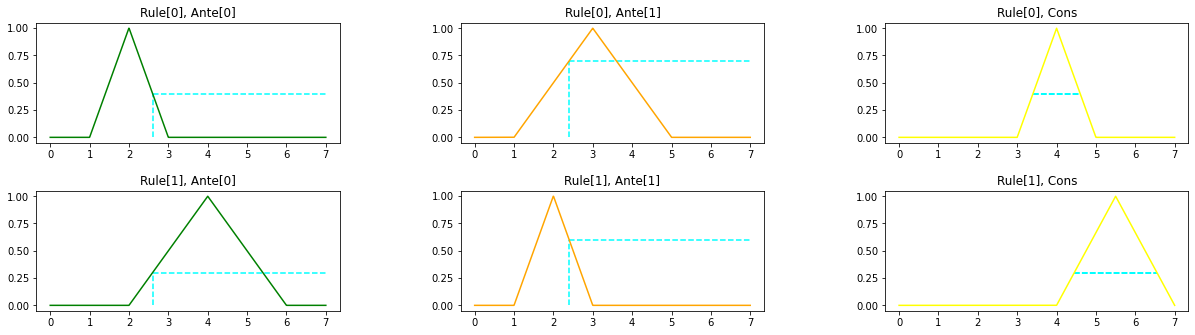

In [ ]:
frbs = np.array([[[1,2,2,3],[1,3,3,5],[3,4,4,5]], [[2,4,4,6],[1,2,2,3],[4,5.5,5.5,7]]])
boundaries = [[0,7], [0,7], [0,7]]
obs = np.array([[2.6,2.4]])
print(obs.T)
plot_trapmf(frbs, boundaries, obs=obs)
print(w_min(rule=frbs[0], observations=obs))
print(w_min(rule=frbs[1], observations=obs))

### Plot

In [ ]:
frbs = np.array( [
        [ [4, 6, 7, 8], [2, 6, 8, 9], [1, 7, 7, 9], [4, 4, 5, 8] ],
        [ [3, 6, 8, 10], [2, 7, 8, 10], [1, 8, 8, 10], [1, 4, 6, 10] ]
])

observations = []
observations.append([5,7.2,6])
observations.append([6,9,3.8])
observations.append([7,8,7.6])
observations = np.array(observations)
print(observations)
boundaries = [[3,9], [1,10], [-1, 9], [1,11]]

[[5.  7.2 6. ]
 [6.  9.  3.8]
 [7.  8.  7.6]]


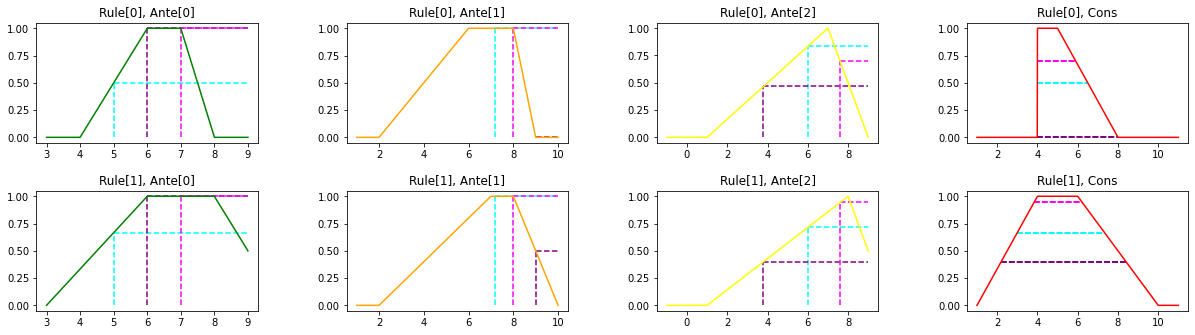

In [ ]:
plot_trapmf(frbs, obs=observations, boundaries=boundaries)

# Bacterial Evolutionary Algorithm

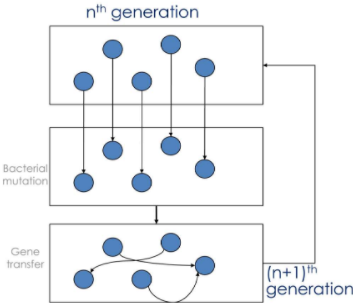

In [ ]:
def generate_abcd(boundarie) -> tuple:
  """ Generates abcd values """
  bound = boundarie
  padding = PADDING_RATE * (bound[1] - bound[0])
  nums = np.random.uniform(low=bound[0] - padding, high=bound[1] + padding, size=4)
  nums.sort()
  return nums # a, b, c, d

In [ ]:
def create_fuzzyRBS(inp:Input) -> np.ndarray:
  """ 
  Creates a random individum 
  Parameters:
  ------------
  observation_dim: int
    The dimension of the observations, we need that many antecedents in each rule
  boundaries: List[List]
    List of boundary. A boundary consists of a lower bound and an upper bound. (for all the antecedents and consequent) 
  
  """
  fuzzyRBS = np.ndarray((inp.nr_rules, inp.observation_dim+1, 4))
  for i in range(inp.nr_rules):
    for j in range(inp.observation_dim+1):
      fuzzyRBS[i][j] = generate_abcd(boundarie=inp.boundaries[j])
  return fuzzyRBS


In [ ]:
def set_gene(frbs:np.ndarray, geneIdx:int, newGene:np.array):
  r, c, _ = frbs.shape
  frbs[geneIdx//c][geneIdx % c] = newGene

In [ ]:
def geneTransfer(donor:np.ndarray, acceptor:np.ndarray, geneIds:np.array):
  """ Donor and acceptor has the same shape """
  r, c, _ = donor.shape
  for geneIdx in geneIds:
    acceptor[geneIdx//c][geneIdx % c] = np.copy(donor[geneIdx//c][geneIdx % c])

In [ ]:
def mutate_gene(frbs:np.ndarray, geneIdx:int, boundaries:np.array):
  r, c, _ = frbs.shape
  frbs[geneIdx//c][geneIdx % c] = generate_abcd(boundarie=boundaries[geneIdx % c])

def mutate_genes(frbs:np.ndarray, geneIds:int, boundaries:np.array):
  for id in geneIds:
    mutate_gene(frbs, id, boundaries)

In [ ]:
def get_rnd_geneId_lists(gene_nr):
  tmp=np.arange(gene_nr)
  rnd.shuffle(tmp)
  tmp = np.array_split(tmp, rnd.randint(2, gene_nr))
  return tmp

print(get_rnd_geneId_lists(20))

[array([12,  3]), array([17,  4]), array([16]), array([0]), array([18]), array([2]), array([5]), array([10]), array([7]), array([8]), array([19]), array([9]), array([11]), array([1]), array([15]), array([14]), array([6]), array([13])]


### Bacterial Mutation

In [ ]:
def bacterialMutation(population: List[np.ndarray], clones:List[np.ndarray], inp:Input):
  r, c, _ = population[0].shape # The number of genes in the choromosome (r*c)
  for idx in range(inp.n_ind):
    for c_idx in range(inp.n_clone):
      clones[c_idx] = np.copy(population[idx])
    # print('clones-err: ', [  __err__(clone, inp) for clone in clones])

    for genes in get_rnd_geneId_lists(r*c):
      for c_idx in range(1, inp.n_clone):
        mutate_genes(frbs=clones[c_idx], geneIds=genes, boundaries=inp.boundaries)
        # mutate_gene(frbs=clones[c_idx], geneIdx=i, boundaries=inp.boundaries)
      # print('pre-clones-err: ', [  __err__(clone, inp) for clone in clones])
      clones[0] = np.copy(min(clones, key=lambda clone: __err__(clone, inp)))
      for c_idx in range(inp.n_clone):
        if (clones[c_idx] != clones[0]).all():
          geneTransfer(donor=clones[0], acceptor=clones[c_idx], geneIds=genes)
    
    population[idx] = np.copy(min(clones, key=lambda clone: __err__(clone, inp)))
    

### Gene Transfer

In [ ]:
def bacterialGeneTransfer(population: List[np.ndarray], inp:Input):
  r, c, _ = population[0].shape

  for i in range(inp.n_inf):
    population.sort(key=lambda indiv: __err__(indiv, inp))
    donorId = rnd.choice(range(inp.n_ind//2))
    acceptorId = rnd.choice(range(inp.n_ind//2, inp.n_ind))
    geneIds = random.sample(range(r*c), 2)
    geneTransfer(donor=population[donorId], acceptor=population[acceptorId], geneIds=geneIds)
  pass

### Bacterial Evolution

In [ ]:
from tqdm import trange

def bacterialEvoulution(inp:Input) -> np.ndarray:
  population = [create_fuzzyRBS(inp) for _ in range(inp.n_ind)]
  clones = [create_fuzzyRBS(inp) for _ in range(inp.n_clone)]

  for ep in trange(inp.n_gen):
    bacterialMutation(population, clones, inp)
    bacterialGeneTransfer(population, inp)
    population.sort(key=lambda indiv: __err__(indiv, inp))
    print('best-err: ', __err__(min(population, key=lambda indiv: __err__(indiv, inp)), inp))
  return population[0]

# Test

In [ ]:
inp1 = Input()
inp1.n_gen = 10
inp1.n_ind= 2
inp1.n_clone= 3
inp1.n_inf= 10
inp1.boundaries = np.array([[0,9],[1,10],[2,8]])
inp1.observations= np.array([[2,6], [3,5.5], [2.2,5.3]])
inp1.observation_dim = inp1.observations.shape[1]
inp1.desired_outputs= np.array([2.5, 3, 4])
inp1.nr_rules= 2

bacterialEvoulution(inp1)

100%|██████████| 10/10 [00:00<00:00, 48.20it/s]

best-err:  0.4045398911303874
best-err:  0.34461226875138345
best-err:  0.34461226875138345
best-err:  0.30235482428492755
best-err:  0.30235482428492755
best-err:  0.30235482428492755
best-err:  0.29673386389858303
best-err:  0.29673386389858303
best-err:  0.24634952422136544
best-err:  0.24634952422136544


array([[[ 0.05116403,  1.93903566,  5.24767871,  9.57455287],
        [ 1.6727592 ,  4.39857608,  9.57325379, 11.17160797],
        [ 2.01263983,  2.30074705,  3.12379568,  4.64954447]],

       [[-0.96944226,  1.20220714,  3.22048201,  9.67957503],
        [ 7.24387983,  7.63329812,  8.04401596,  8.83680897],
        [ 1.60831219,  4.01978326,  4.79920547,  6.23038808]]])

### Test 1

In [ ]:
inp1 = Input()
inp1.n_gen = 10
inp1.n_ind= 2
inp1.n_clone= 3
inp1.n_inf= 10
inp1.boundaries = np.array([[0,9],[1,10],[2,8]])
inp1.observations= np.array([[2,6], [3,5.5], [2.2,5.3]])
inp1.observation_dim = inp1.observations.shape[1]
inp1.desired_outputs= np.array([2.5, 3, 4])
inp1.nr_rules= 2

bacterialEvoulution(inp1)

 30%|███       | 3/10 [00:00<00:00, 24.83it/s]

best-err:  0.33558902457480033
best-err:  0.3335131449150869
best-err:  0.3335131449150869
best-err:  0.3335131449150869
best-err:  0.3300255834700828


100%|██████████| 10/10 [00:00<00:00, 21.48it/s]

best-err:  0.3300255834700828
best-err:  0.28131148896475644
best-err:  0.2539190801879532
best-err:  0.2539190801879532
best-err:  0.24498105326929331


array([[[-0.89711178,  3.32022521,  6.96423788,  8.76811405],
        [ 1.93015684,  3.3505683 ,  3.69848144,  4.7910176 ],
        [ 1.68515306,  3.17727304,  6.32815245,  8.43957316]],

       [[ 1.35046429,  6.58881424,  8.90001314,  9.446102  ],
        [-0.33176487,  0.02644217,  1.32671858,  7.18802169],
        [ 0.84424715,  1.32100871,  2.00897204,  5.48796024]]])

(5.0, 2.0)


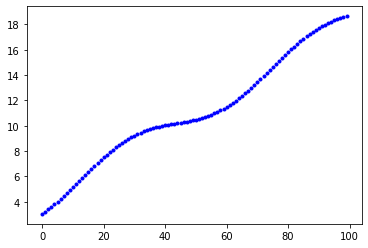

In [ ]:
import matplotlib.pyplot as plt

X1s = np.linspace(5, 15, 100)
X2s = np.linspace(2, 9, 100)


def f(x1, x2):
  return np.sin(x1) + 2*x2
  
desired_outputs = f(X1s, X2s)


plt.plot(desired_outputs, '.b')

observations = list(zip(X1s, X2s))
print(observations[0])

In [ ]:
print(np.array(observations).shape)

(10, 2)


In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

inp2 = Input()
inp2.n_gen = 100
inp2.n_ind = 30
inp2.n_clone = 10
inp2.n_inf = 10
inp2.boundaries = np.array(boundaries)
inp2.observations = np.array(observations)
inp2.observation_dim = inp2.observations.shape[1]
inp2.desired_outputs = np.array(desired_outputs)
inp2.nr_rules = 15

best_indiv = bacterialEvoulution(inp2)

  1%|          | 1/100 [00:22<37:22, 22.65s/it]

best-err:  6.203901997674009


  2%|▏         | 2/100 [00:56<47:17, 28.95s/it]

best-err:  3.06504161815565


  3%|▎         | 3/100 [01:25<46:58, 29.06s/it]

best-err:  1.9019094720429457


  4%|▍         | 4/100 [01:54<46:25, 29.02s/it]

best-err:  1.9019094720429457


  5%|▌         | 5/100 [02:15<41:20, 26.11s/it]

best-err:  1.9019094720429457


  6%|▌         | 6/100 [02:44<42:47, 27.31s/it]

best-err:  1.9019094720429457


  7%|▋         | 7/100 [03:14<43:29, 28.06s/it]

best-err:  1.9019094720429457


  8%|▊         | 8/100 [03:39<41:22, 26.98s/it]

best-err:  1.9019094720429457


  9%|▉         | 9/100 [04:05<40:33, 26.75s/it]

best-err:  1.9019094720429457


 10%|█         | 10/100 [04:32<40:18, 26.87s/it]

best-err:  1.6944680827995158


 11%|█         | 11/100 [05:00<40:17, 27.16s/it]

best-err:  1.6944680827995158


 12%|█▏        | 12/100 [05:22<37:48, 25.78s/it]

best-err:  1.4906889063483715


 13%|█▎        | 13/100 [05:53<39:39, 27.35s/it]

best-err:  1.4906889063483715


 14%|█▍        | 14/100 [06:22<39:44, 27.73s/it]

best-err:  1.4384634862041064


 15%|█▌        | 15/100 [06:47<38:20, 27.06s/it]

best-err:  1.3871295030368787


 16%|█▌        | 16/100 [07:20<40:05, 28.64s/it]

best-err:  1.2413032289648696


 17%|█▋        | 17/100 [07:50<40:18, 29.14s/it]

best-err:  1.2413032289648696


 18%|█▊        | 18/100 [08:13<37:07, 27.16s/it]

best-err:  1.069541859330325


 19%|█▉        | 19/100 [08:37<35:22, 26.21s/it]

best-err:  1.069541859330325


 20%|██        | 20/100 [09:02<34:33, 25.92s/it]

best-err:  1.069541859330325


 21%|██        | 21/100 [09:29<34:44, 26.38s/it]

best-err:  1.069541859330325


 22%|██▏       | 22/100 [09:54<33:41, 25.92s/it]

best-err:  1.069541859330325


 23%|██▎       | 23/100 [10:23<34:33, 26.92s/it]

best-err:  1.0338095177673854


 24%|██▍       | 24/100 [10:49<33:29, 26.44s/it]

best-err:  1.0338095177673854


 25%|██▌       | 25/100 [11:13<32:10, 25.74s/it]

best-err:  1.0338095177673854


 26%|██▌       | 26/100 [11:40<32:17, 26.18s/it]

best-err:  1.0338095177673854


 27%|██▋       | 27/100 [12:08<32:35, 26.78s/it]

best-err:  1.0338095177673854


 28%|██▊       | 28/100 [12:35<32:16, 26.89s/it]

best-err:  1.0338095177673854


 29%|██▉       | 29/100 [13:05<32:42, 27.64s/it]

best-err:  1.0338095177673854


 30%|███       | 30/100 [13:30<31:17, 26.82s/it]

best-err:  1.0338095177673854


 31%|███       | 31/100 [13:57<30:54, 26.88s/it]

best-err:  0.9029407894470924


 32%|███▏      | 32/100 [14:26<31:20, 27.66s/it]

best-err:  0.9029407894470924


 33%|███▎      | 33/100 [14:54<30:53, 27.66s/it]

best-err:  0.9029407894470924


 34%|███▍      | 34/100 [15:22<30:36, 27.83s/it]

best-err:  0.9029407894470924


 35%|███▌      | 35/100 [15:52<30:49, 28.46s/it]

best-err:  0.9029407894470924


 36%|███▌      | 36/100 [16:14<28:21, 26.58s/it]

best-err:  0.9029407894470924


 37%|███▋      | 37/100 [16:37<26:39, 25.39s/it]

best-err:  0.9029407894470924


 38%|███▊      | 38/100 [17:09<28:17, 27.38s/it]

best-err:  0.9029407894470924


 39%|███▉      | 39/100 [17:36<27:54, 27.45s/it]

best-err:  0.7711451197264632


 40%|████      | 40/100 [18:04<27:26, 27.44s/it]

best-err:  0.7711451197264632


 41%|████      | 41/100 [18:31<26:57, 27.41s/it]

best-err:  0.7711451197264632


 42%|████▏     | 42/100 [18:58<26:18, 27.22s/it]

best-err:  0.7711451197264632


 43%|████▎     | 43/100 [19:22<24:54, 26.22s/it]

best-err:  0.7711451197264632


 44%|████▍     | 44/100 [19:48<24:27, 26.20s/it]

best-err:  0.7711451197264632


 45%|████▌     | 45/100 [20:14<23:55, 26.09s/it]

best-err:  0.7711451197264632


 46%|████▌     | 46/100 [20:44<24:28, 27.20s/it]

best-err:  0.7711451197264632


 47%|████▋     | 47/100 [21:09<23:30, 26.60s/it]

best-err:  0.7711451197264632


 48%|████▊     | 48/100 [21:32<22:12, 25.63s/it]

best-err:  0.7711451197264632


 49%|████▉     | 49/100 [21:56<21:20, 25.12s/it]

best-err:  0.7711451197264632


 50%|█████     | 50/100 [22:24<21:33, 25.86s/it]

best-err:  0.7711451197264632


 51%|█████     | 51/100 [22:52<21:38, 26.49s/it]

best-err:  0.7711451197264632


 52%|█████▏    | 52/100 [23:19<21:26, 26.81s/it]

best-err:  0.7711451197264632


 53%|█████▎    | 53/100 [23:47<21:19, 27.23s/it]

best-err:  0.7711451197264632


 54%|█████▍    | 54/100 [24:19<21:58, 28.66s/it]

best-err:  0.7711451197264632


 55%|█████▌    | 55/100 [24:47<21:17, 28.39s/it]

best-err:  0.7711451197264632


 56%|█████▌    | 56/100 [25:12<19:58, 27.24s/it]

best-err:  0.7711451197264632


 57%|█████▋    | 57/100 [25:39<19:30, 27.23s/it]

best-err:  0.7711451197264632


 58%|█████▊    | 58/100 [26:07<19:18, 27.58s/it]

best-err:  0.7711451197264632


 59%|█████▉    | 59/100 [26:35<18:51, 27.59s/it]

best-err:  0.7711451197264632


 60%|██████    | 60/100 [26:57<17:22, 26.06s/it]

best-err:  0.7499854635080864


 61%|██████    | 61/100 [27:26<17:25, 26.80s/it]

best-err:  0.7499854635080864


 62%|██████▏   | 62/100 [27:58<18:01, 28.47s/it]

best-err:  0.7499854635080864


 63%|██████▎   | 63/100 [28:25<17:08, 27.79s/it]

best-err:  0.7499854635080864


 64%|██████▍   | 64/100 [28:53<16:44, 27.91s/it]

best-err:  0.7499854635080864


 65%|██████▌   | 65/100 [29:12<14:51, 25.46s/it]

best-err:  0.7499854635080864


 66%|██████▌   | 66/100 [29:37<14:11, 25.06s/it]

best-err:  0.7499854635080864


 67%|██████▋   | 67/100 [30:03<13:57, 25.38s/it]

best-err:  0.718822743302341


 68%|██████▊   | 68/100 [30:28<13:35, 25.50s/it]

best-err:  0.718822743302341


 69%|██████▉   | 69/100 [30:57<13:41, 26.49s/it]

best-err:  0.718822743302341


 70%|███████   | 70/100 [31:22<13:02, 26.09s/it]

best-err:  0.718822743302341


 71%|███████   | 71/100 [31:49<12:38, 26.16s/it]

best-err:  0.718822743302341


 72%|███████▏  | 72/100 [32:17<12:28, 26.74s/it]

best-err:  0.718822743302341


 73%|███████▎  | 73/100 [32:43<11:55, 26.51s/it]

best-err:  0.718822743302341


 74%|███████▍  | 74/100 [33:12<11:50, 27.33s/it]

best-err:  0.718822743302341


 75%|███████▌  | 75/100 [33:39<11:19, 27.20s/it]

best-err:  0.718822743302341


 76%|███████▌  | 76/100 [34:01<10:13, 25.58s/it]

best-err:  0.718822743302341


 77%|███████▋  | 77/100 [34:30<10:11, 26.59s/it]

best-err:  0.718822743302341


 78%|███████▊  | 78/100 [34:57<09:47, 26.69s/it]

best-err:  0.718822743302341


 79%|███████▉  | 79/100 [35:21<09:03, 25.86s/it]

best-err:  0.718822743302341


 80%|████████  | 80/100 [35:47<08:39, 25.98s/it]

best-err:  0.718822743302341


 81%|████████  | 81/100 [36:17<08:39, 27.35s/it]

best-err:  0.718822743302341


 82%|████████▏ | 82/100 [36:43<08:02, 26.81s/it]

best-err:  0.718822743302341


 83%|████████▎ | 83/100 [37:12<07:47, 27.47s/it]

best-err:  0.718822743302341


 84%|████████▍ | 84/100 [37:39<07:17, 27.34s/it]

best-err:  0.718822743302341


 85%|████████▌ | 85/100 [38:01<06:24, 25.61s/it]

best-err:  0.718822743302341


 86%|████████▌ | 86/100 [38:29<06:08, 26.34s/it]

best-err:  0.718822743302341


 87%|████████▋ | 87/100 [38:53<05:35, 25.81s/it]

best-err:  0.718822743302341


 88%|████████▊ | 88/100 [39:24<05:27, 27.29s/it]

best-err:  0.718822743302341


 89%|████████▉ | 89/100 [39:48<04:48, 26.27s/it]

best-err:  0.718822743302341


 90%|█████████ | 90/100 [40:15<04:24, 26.43s/it]

best-err:  0.718822743302341


 91%|█████████ | 91/100 [40:44<04:05, 27.25s/it]

best-err:  0.718822743302341


 92%|█████████▏| 92/100 [41:11<03:38, 27.37s/it]

best-err:  0.718822743302341


 93%|█████████▎| 93/100 [41:37<03:07, 26.75s/it]

best-err:  0.718822743302341


 94%|█████████▍| 94/100 [42:01<02:36, 26.13s/it]

best-err:  0.718822743302341


 95%|█████████▌| 95/100 [42:27<02:10, 26.05s/it]

best-err:  0.718822743302341


 96%|█████████▌| 96/100 [42:53<01:43, 25.84s/it]

best-err:  0.718822743302341


 97%|█████████▋| 97/100 [43:19<01:17, 25.86s/it]

best-err:  0.718822743302341


 98%|█████████▊| 98/100 [43:48<00:53, 26.89s/it]

best-err:  0.718822743302341


 99%|█████████▉| 99/100 [44:15<00:26, 26.92s/it]

best-err:  0.718822743302341


100%|██████████| 100/100 [44:46<00:00, 26.87s/it]

best-err:  0.718822743302341


Text(0.5, 0, 'Y')

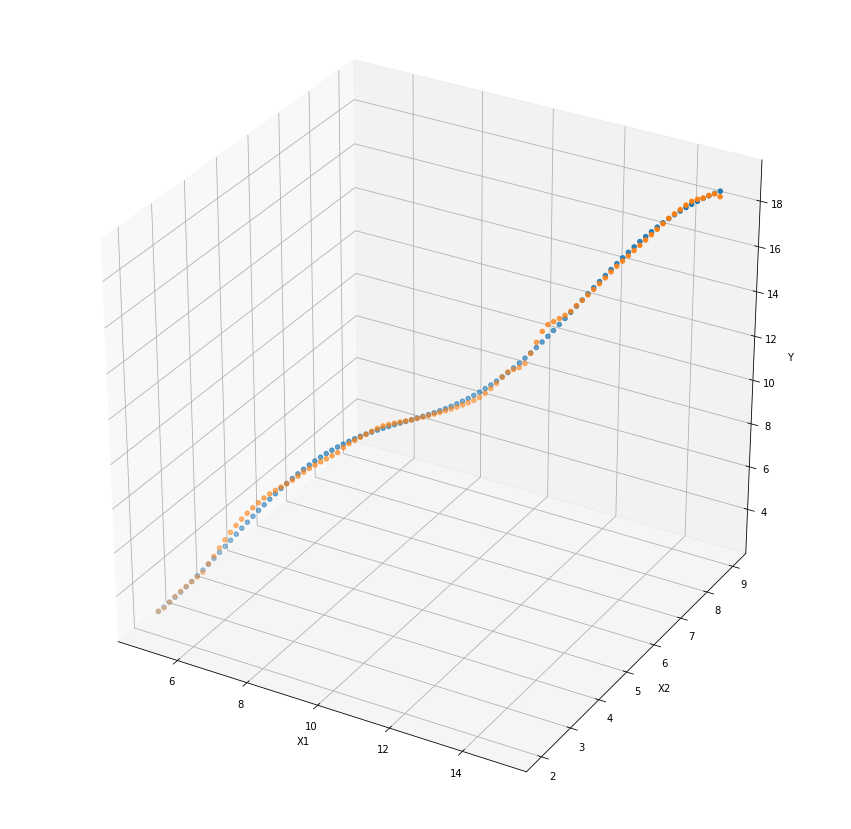

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs)
ax.scatter(X1s, X2s, Ys)
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

### With Outliers (rule: 15)

(5.0, 2.0)


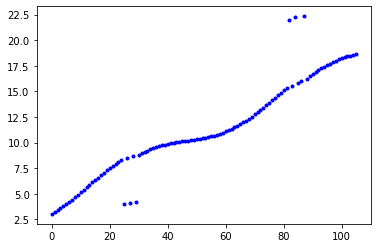

In [ ]:
import matplotlib.pyplot as plt

X1s = np.linspace(5, 15, 100)
X2s = np.linspace(2, 9, 100)


def f(x1, x2):
  return np.sin(x1) + 2*x2


desired_outputs = f(X1s, X2s)
desired_outputs = np.insert(desired_outputs, [25,26,27,79,80,82], [4,4.1,4.2,22,22.3, 22.34]) 
X1s = np.insert(X1s, [25,26,27,79,80,82], [10, 10.1, 10.2, 5,5.5, 5.59]) 
X2s = np.insert(X2s, [25,26,27,79,80,82], [2,2.1,2.2, 6,6.01,6.1]) 

plt.plot(desired_outputs, '.b')

observations = list(zip(X1s, X2s))
print(observations[0])

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

inp2 = Input()
inp2.n_gen = 100
inp2.n_ind = 30
inp2.n_clone = 10
inp2.n_inf = 10
inp2.boundaries = np.array(boundaries)
inp2.observations = np.array(observations)
inp2.observation_dim = inp2.observations.shape[1]
inp2.desired_outputs = np.array(desired_outputs)
inp2.nr_rules = 15

best_indiv = bacterialEvoulution(inp2)

  1%|          | 1/100 [00:32<53:42, 32.55s/it]

best-err:  5.895169557595969


  2%|▏         | 2/100 [01:00<48:44, 29.84s/it]

best-err:  5.26066876024314


  3%|▎         | 3/100 [01:28<47:09, 29.17s/it]

best-err:  4.708800636603963


  4%|▍         | 4/100 [01:55<45:11, 28.24s/it]

best-err:  3.8418033747677787


  5%|▌         | 5/100 [02:26<46:14, 29.21s/it]

best-err:  3.8418033747677787


  6%|▌         | 6/100 [02:53<44:29, 28.39s/it]

best-err:  3.8418033747677787


  7%|▋         | 7/100 [03:21<43:57, 28.36s/it]

best-err:  3.6737329780864783


  8%|▊         | 8/100 [03:47<42:07, 27.48s/it]

best-err:  3.14033270798812


  9%|▉         | 9/100 [04:10<39:48, 26.24s/it]

best-err:  3.14033270798812


 10%|█         | 10/100 [04:36<39:07, 26.08s/it]

best-err:  3.14033270798812


 11%|█         | 11/100 [05:04<39:43, 26.79s/it]

best-err:  3.14033270798812


 12%|█▏        | 12/100 [05:29<38:11, 26.04s/it]

best-err:  3.14033270798812


 13%|█▎        | 13/100 [06:01<40:15, 27.77s/it]

best-err:  3.14033270798812


 14%|█▍        | 14/100 [06:25<38:35, 26.93s/it]

best-err:  3.14033270798812


 15%|█▌        | 15/100 [06:54<38:54, 27.46s/it]

best-err:  3.14033270798812


 16%|█▌        | 16/100 [07:22<38:45, 27.68s/it]

best-err:  3.14033270798812


 17%|█▋        | 17/100 [07:52<39:08, 28.30s/it]

best-err:  3.14033270798812


 18%|█▊        | 18/100 [08:18<37:33, 27.49s/it]

best-err:  3.14033270798812


 19%|█▉        | 19/100 [08:48<38:11, 28.29s/it]

best-err:  3.14033270798812


 20%|██        | 20/100 [09:13<36:37, 27.47s/it]

best-err:  3.14033270798812


 21%|██        | 21/100 [09:44<37:24, 28.42s/it]

best-err:  3.14033270798812


 22%|██▏       | 22/100 [10:14<37:23, 28.76s/it]

best-err:  2.9525741288381875


 23%|██▎       | 23/100 [10:41<36:23, 28.36s/it]

best-err:  2.882304272211723


 24%|██▍       | 24/100 [11:11<36:31, 28.84s/it]

best-err:  2.855377184297097


 25%|██▌       | 25/100 [11:37<35:06, 28.08s/it]

best-err:  2.855377184297097


 26%|██▌       | 26/100 [12:04<34:10, 27.71s/it]

best-err:  2.855377184297097


 27%|██▋       | 27/100 [12:31<33:17, 27.36s/it]

best-err:  2.855377184297097


 28%|██▊       | 28/100 [12:59<33:05, 27.58s/it]

best-err:  2.855377184297097


 29%|██▉       | 29/100 [13:27<32:53, 27.79s/it]

best-err:  2.855377184297097


 30%|███       | 30/100 [13:54<32:04, 27.49s/it]

best-err:  2.855377184297097


 31%|███       | 31/100 [14:23<32:19, 28.10s/it]

best-err:  2.837187962732202


 32%|███▏      | 32/100 [14:53<32:26, 28.63s/it]

best-err:  2.7115206013483713


 33%|███▎      | 33/100 [15:21<31:46, 28.46s/it]

best-err:  2.7115206013483713


 34%|███▍      | 34/100 [15:52<31:54, 29.01s/it]

best-err:  2.7115206013483713


 35%|███▌      | 35/100 [16:20<31:04, 28.68s/it]

best-err:  2.2929244630501167


 36%|███▌      | 36/100 [16:47<30:17, 28.39s/it]

best-err:  2.2929244630501167


 37%|███▋      | 37/100 [17:17<30:18, 28.87s/it]

best-err:  2.290373127361641


 38%|███▊      | 38/100 [17:46<29:56, 28.98s/it]

best-err:  2.290373127361641


 39%|███▉      | 39/100 [18:13<28:37, 28.16s/it]

best-err:  2.290373127361641


 40%|████      | 40/100 [18:39<27:39, 27.65s/it]

best-err:  2.290373127361641


 41%|████      | 41/100 [19:08<27:23, 27.86s/it]

best-err:  2.290373127361641


 42%|████▏     | 42/100 [19:35<26:40, 27.60s/it]

best-err:  2.290373127361641


 43%|████▎     | 43/100 [20:05<27:10, 28.60s/it]

best-err:  2.0958714417212194


 44%|████▍     | 44/100 [20:38<27:41, 29.66s/it]

best-err:  2.0958714417212194


 45%|████▌     | 45/100 [21:11<28:16, 30.85s/it]

best-err:  2.0958714417212194


 46%|████▌     | 46/100 [21:42<27:39, 30.73s/it]

best-err:  2.0958714417212194


 47%|████▋     | 47/100 [22:10<26:27, 29.95s/it]

best-err:  2.0958714417212194


 48%|████▊     | 48/100 [22:37<25:13, 29.10s/it]

best-err:  2.0958714417212194


 49%|████▉     | 49/100 [23:07<25:07, 29.55s/it]

best-err:  2.0958714417212194


 50%|█████     | 50/100 [23:39<25:00, 30.01s/it]

best-err:  2.0958714417212194


 51%|█████     | 51/100 [24:03<23:02, 28.21s/it]

best-err:  2.0958714417212194


 52%|█████▏    | 52/100 [24:29<22:03, 27.58s/it]

best-err:  2.0958714417212194


 53%|█████▎    | 53/100 [24:57<21:52, 27.93s/it]

best-err:  2.0958714417212194


 54%|█████▍    | 54/100 [25:28<22:02, 28.76s/it]

best-err:  2.0958714417212194


 55%|█████▌    | 55/100 [25:56<21:20, 28.47s/it]

best-err:  2.0958714417212194


 56%|█████▌    | 56/100 [26:21<20:11, 27.53s/it]

best-err:  2.0958714417212194


 57%|█████▋    | 57/100 [26:47<19:25, 27.11s/it]

best-err:  2.0958714417212194


 58%|█████▊    | 58/100 [27:12<18:22, 26.26s/it]

best-err:  2.0958714417212194


 59%|█████▉    | 59/100 [27:37<17:46, 26.01s/it]

best-err:  2.0958714417212194


 60%|██████    | 60/100 [28:04<17:31, 26.28s/it]

best-err:  2.0958714417212194


 61%|██████    | 61/100 [28:31<17:14, 26.54s/it]

best-err:  2.0958714417212194


 62%|██████▏   | 62/100 [29:02<17:33, 27.73s/it]

best-err:  1.944546702459553


 63%|██████▎   | 63/100 [29:26<16:31, 26.78s/it]

best-err:  1.944546702459553


 64%|██████▍   | 64/100 [29:55<16:24, 27.34s/it]

best-err:  1.944546702459553


 65%|██████▌   | 65/100 [30:25<16:23, 28.10s/it]

best-err:  1.944546702459553


 66%|██████▌   | 66/100 [30:51<15:36, 27.56s/it]

best-err:  1.944546702459553


 67%|██████▋   | 67/100 [31:15<14:37, 26.58s/it]

best-err:  1.944546702459553


 68%|██████▊   | 68/100 [31:46<14:45, 27.68s/it]

best-err:  1.944546702459553


 69%|██████▉   | 69/100 [32:11<14:01, 27.14s/it]

best-err:  1.944546702459553


 70%|███████   | 70/100 [32:42<14:01, 28.06s/it]

best-err:  1.944546702459553


 71%|███████   | 71/100 [33:07<13:09, 27.21s/it]

best-err:  1.944546702459553


 72%|███████▏  | 72/100 [33:32<12:26, 26.65s/it]

best-err:  1.944546702459553


 73%|███████▎  | 73/100 [34:01<12:16, 27.29s/it]

best-err:  1.944546702459553


 74%|███████▍  | 74/100 [34:29<11:57, 27.59s/it]

best-err:  1.944546702459553


 75%|███████▌  | 75/100 [34:58<11:36, 27.86s/it]

best-err:  1.944546702459553


 76%|███████▌  | 76/100 [35:30<11:41, 29.22s/it]

best-err:  1.944546702459553


 77%|███████▋  | 77/100 [35:57<10:52, 28.37s/it]

best-err:  1.944546702459553


 78%|███████▊  | 78/100 [36:27<10:39, 29.05s/it]

best-err:  1.944546702459553


 79%|███████▉  | 79/100 [36:56<10:08, 28.96s/it]

best-err:  1.944546702459553


 80%|████████  | 80/100 [37:24<09:33, 28.66s/it]

best-err:  1.944546702459553


 81%|████████  | 81/100 [37:51<08:53, 28.10s/it]

best-err:  1.9100503811825904


 82%|████████▏ | 82/100 [38:18<08:20, 27.83s/it]

best-err:  1.9100503811825904


 83%|████████▎ | 83/100 [38:44<07:45, 27.38s/it]

best-err:  1.9100503811825904


 84%|████████▍ | 84/100 [39:15<07:32, 28.31s/it]

best-err:  1.9100503811825904


 85%|████████▌ | 85/100 [39:36<06:33, 26.21s/it]

best-err:  1.9100503811825904


 86%|████████▌ | 86/100 [40:07<06:25, 27.52s/it]

best-err:  1.9100503811825904


 87%|████████▋ | 87/100 [40:33<05:55, 27.32s/it]

best-err:  1.9100503811825904


 88%|████████▊ | 88/100 [41:06<05:44, 28.74s/it]

best-err:  1.9100503811825904


 89%|████████▉ | 89/100 [41:37<05:26, 29.65s/it]

best-err:  1.7406768424107346


 90%|█████████ | 90/100 [42:09<05:02, 30.24s/it]

best-err:  1.7406768424107346


 91%|█████████ | 91/100 [42:37<04:26, 29.58s/it]

best-err:  1.7406768424107346


 92%|█████████▏| 92/100 [43:10<04:04, 30.56s/it]

best-err:  1.7406768424107346


 93%|█████████▎| 93/100 [43:41<03:35, 30.80s/it]

best-err:  1.7406768424107346


 94%|█████████▍| 94/100 [44:07<02:55, 29.23s/it]

best-err:  1.7406768424107346


 95%|█████████▌| 95/100 [44:31<02:18, 27.69s/it]

best-err:  1.7406768424107346


 96%|█████████▌| 96/100 [44:57<01:48, 27.17s/it]

best-err:  1.7406768424107346


 97%|█████████▋| 97/100 [45:28<01:25, 28.34s/it]

best-err:  1.7406768424107346


 98%|█████████▊| 98/100 [45:55<00:55, 27.92s/it]

best-err:  1.7406768424107346


 99%|█████████▉| 99/100 [46:16<00:26, 26.04s/it]

best-err:  1.7406768424107346


100%|██████████| 100/100 [46:43<00:00, 28.04s/it]

best-err:  1.7406768424107346


Text(0.5, 0, 'Y')

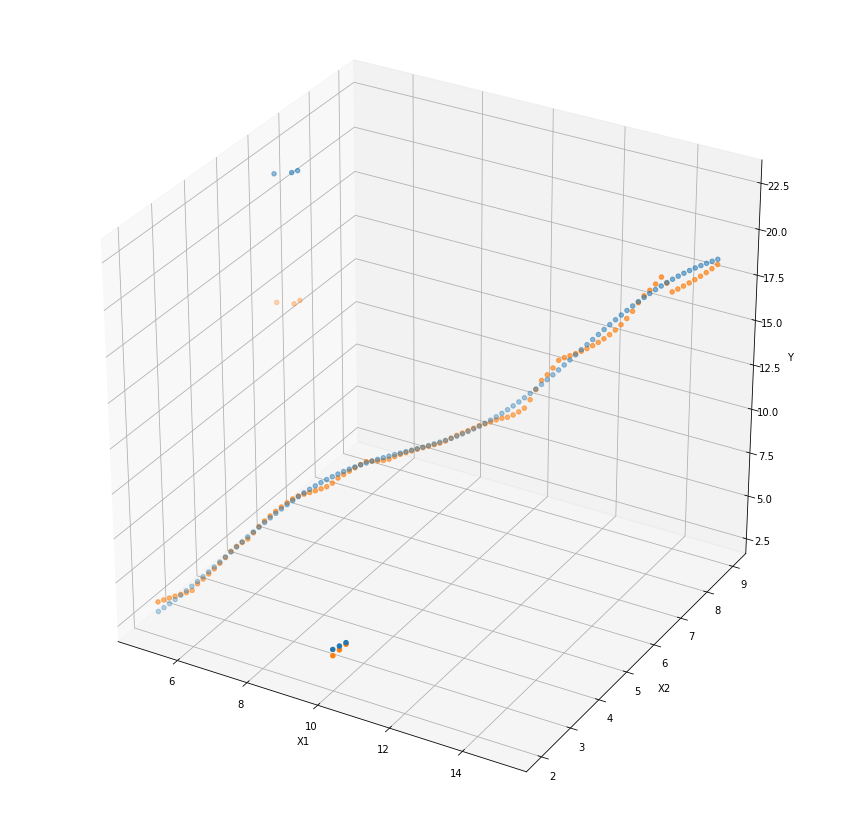

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs)
ax.scatter(X1s, X2s, Ys)
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

### With Outliers (rule: 2)

(5.0, 2.0)


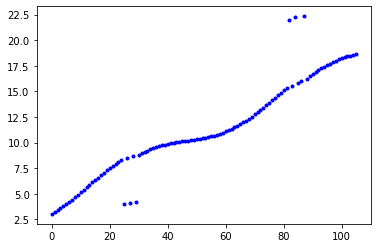

In [ ]:
import matplotlib.pyplot as plt

X1s = np.linspace(5, 15, 100)
X2s = np.linspace(2, 9, 100)


def f(x1, x2):
  return np.sin(x1) + 2*x2


desired_outputs = f(X1s, X2s)
desired_outputs = np.insert(desired_outputs, [25,26,27,79,80,82], [4,4.1,4.2,22,22.3, 22.34]) 
X1s = np.insert(X1s, [25,26,27,79,80,82], [10, 10.1, 10.2, 5,5.5, 5.59]) 
X2s = np.insert(X2s, [25,26,27,79,80,82], [2,2.1,2.2, 6,6.01,6.1]) 

plt.plot(desired_outputs, '.b')

observations = list(zip(X1s, X2s))
print(observations[0])

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

inp2 = Input()
inp2.n_gen = 100
inp2.n_ind = 30
inp2.n_clone = 10
inp2.n_inf = 10
inp2.boundaries = np.array(boundaries)
inp2.observations = np.array(observations)
inp2.observation_dim = inp2.observations.shape[1]
inp2.desired_outputs = np.array(desired_outputs)
inp2.nr_rules = 2

best_indiv = bacterialEvoulution(inp2)

  1%|          | 1/100 [00:01<01:58,  1.20s/it]

best-err:  8.56532565620182


  2%|▏         | 2/100 [00:02<01:53,  1.16s/it]

best-err:  8.56532565620182


  3%|▎         | 3/100 [00:03<01:54,  1.18s/it]

best-err:  8.56532565620182


  4%|▍         | 4/100 [00:04<01:52,  1.17s/it]

best-err:  7.428918132095116


  5%|▌         | 5/100 [00:05<01:50,  1.17s/it]

best-err:  7.428918132095116


  6%|▌         | 6/100 [00:07<01:50,  1.17s/it]

best-err:  7.428918132095116


  7%|▋         | 7/100 [00:08<01:49,  1.18s/it]

best-err:  7.428918132095116


  8%|▊         | 8/100 [00:09<01:47,  1.17s/it]

best-err:  5.600437097842295


  9%|▉         | 9/100 [00:10<01:45,  1.15s/it]

best-err:  5.600437097842295


 10%|█         | 10/100 [00:11<01:44,  1.16s/it]

best-err:  4.531387980486207


 11%|█         | 11/100 [00:12<01:44,  1.17s/it]

best-err:  4.34400965928481


 12%|█▏        | 12/100 [00:14<01:45,  1.20s/it]

best-err:  4.34400965928481


 13%|█▎        | 13/100 [00:15<01:44,  1.20s/it]

best-err:  4.34400965928481


 14%|█▍        | 14/100 [00:16<01:43,  1.20s/it]

best-err:  4.34400965928481


 15%|█▌        | 15/100 [00:17<01:40,  1.19s/it]

best-err:  4.34400965928481


 16%|█▌        | 16/100 [00:18<01:40,  1.20s/it]

best-err:  4.334458140632635


 17%|█▋        | 17/100 [00:20<01:39,  1.20s/it]

best-err:  4.334458140632635


 18%|█▊        | 18/100 [00:21<01:38,  1.21s/it]

best-err:  4.334458140632635


 19%|█▉        | 19/100 [00:22<01:37,  1.21s/it]

best-err:  4.334458140632635


 20%|██        | 20/100 [00:23<01:35,  1.19s/it]

best-err:  4.334458140632635


 21%|██        | 21/100 [00:24<01:34,  1.19s/it]

best-err:  4.334458140632635


 22%|██▏       | 22/100 [00:26<01:34,  1.21s/it]

best-err:  4.334458140632635


 23%|██▎       | 23/100 [00:27<01:31,  1.18s/it]

best-err:  4.334458140632635


 24%|██▍       | 24/100 [00:28<01:29,  1.18s/it]

best-err:  4.334458140632635


 25%|██▌       | 25/100 [00:29<01:27,  1.17s/it]

best-err:  4.334458140632635


 26%|██▌       | 26/100 [00:30<01:26,  1.17s/it]

best-err:  4.334458140632635


 27%|██▋       | 27/100 [00:31<01:25,  1.17s/it]

best-err:  4.334458140632635


 28%|██▊       | 28/100 [00:33<01:25,  1.18s/it]

best-err:  4.334458140632635


 29%|██▉       | 29/100 [00:34<01:23,  1.18s/it]

best-err:  4.334458140632635


 30%|███       | 30/100 [00:35<01:23,  1.19s/it]

best-err:  4.203843363615047


 31%|███       | 31/100 [00:36<01:22,  1.20s/it]

best-err:  4.203843363615047


 32%|███▏      | 32/100 [00:37<01:21,  1.20s/it]

best-err:  4.203843363615047


 33%|███▎      | 33/100 [00:39<01:20,  1.21s/it]

best-err:  4.203843363615047


 34%|███▍      | 34/100 [00:40<01:19,  1.21s/it]

best-err:  4.203843363615047


 35%|███▌      | 35/100 [00:41<01:17,  1.20s/it]

best-err:  4.203843363615047


 36%|███▌      | 36/100 [00:42<01:16,  1.20s/it]

best-err:  4.203843363615047


 37%|███▋      | 37/100 [00:43<01:14,  1.18s/it]

best-err:  4.203843363615047


 38%|███▊      | 38/100 [00:45<01:16,  1.23s/it]

best-err:  4.203843363615047


 39%|███▉      | 39/100 [00:46<01:14,  1.21s/it]

best-err:  4.203843363615047


 40%|████      | 40/100 [00:47<01:13,  1.22s/it]

best-err:  4.203843363615047


 41%|████      | 41/100 [00:48<01:12,  1.22s/it]

best-err:  4.203843363615047


 42%|████▏     | 42/100 [00:49<01:09,  1.20s/it]

best-err:  4.203843363615047


 43%|████▎     | 43/100 [00:51<01:08,  1.21s/it]

best-err:  4.203843363615047


 44%|████▍     | 44/100 [00:52<01:07,  1.21s/it]

best-err:  4.203843363615047


 45%|████▌     | 45/100 [00:53<01:05,  1.19s/it]

best-err:  4.203843363615047


 46%|████▌     | 46/100 [00:54<01:02,  1.15s/it]

best-err:  4.203843363615047


 47%|████▋     | 47/100 [00:55<01:01,  1.16s/it]

best-err:  4.203843363615047


 48%|████▊     | 48/100 [00:56<01:00,  1.16s/it]

best-err:  4.203843363615047


 49%|████▉     | 49/100 [00:58<00:59,  1.17s/it]

best-err:  4.203843363615047


 50%|█████     | 50/100 [00:59<00:58,  1.17s/it]

best-err:  4.203843363615047


 51%|█████     | 51/100 [01:00<00:58,  1.20s/it]

best-err:  4.203843363615047


 52%|█████▏    | 52/100 [01:01<00:57,  1.21s/it]

best-err:  4.203843363615047


 53%|█████▎    | 53/100 [01:03<00:57,  1.21s/it]

best-err:  4.203843363615047


 54%|█████▍    | 54/100 [01:04<00:55,  1.21s/it]

best-err:  4.203843363615047


 55%|█████▌    | 55/100 [01:05<00:53,  1.19s/it]

best-err:  4.0140775062313825


 56%|█████▌    | 56/100 [01:06<00:52,  1.20s/it]

best-err:  3.951523292979577


 57%|█████▋    | 57/100 [01:07<00:51,  1.20s/it]

best-err:  3.951523292979577


 58%|█████▊    | 58/100 [01:09<00:50,  1.21s/it]

best-err:  3.951523292979577


 59%|█████▉    | 59/100 [01:10<00:49,  1.21s/it]

best-err:  3.951523292979577


 60%|██████    | 60/100 [01:11<00:48,  1.20s/it]

best-err:  3.951523292979577


 61%|██████    | 61/100 [01:12<00:46,  1.19s/it]

best-err:  3.951523292979577


 62%|██████▏   | 62/100 [01:13<00:45,  1.21s/it]

best-err:  3.951523292979577


 63%|██████▎   | 63/100 [01:15<00:44,  1.21s/it]

best-err:  3.4684104332406585


 64%|██████▍   | 64/100 [01:16<00:43,  1.22s/it]

best-err:  3.4684104332406585


 65%|██████▌   | 65/100 [01:17<00:42,  1.22s/it]

best-err:  3.4684104332406585


 66%|██████▌   | 66/100 [01:18<00:41,  1.23s/it]

best-err:  3.4684104332406585


 67%|██████▋   | 67/100 [01:20<00:40,  1.22s/it]

best-err:  3.4684104332406585


 68%|██████▊   | 68/100 [01:21<00:38,  1.21s/it]

best-err:  3.4684104332406585


 69%|██████▉   | 69/100 [01:22<00:37,  1.21s/it]

best-err:  3.4684104332406585


 70%|███████   | 70/100 [01:23<00:36,  1.20s/it]

best-err:  3.4684104332406585


 71%|███████   | 71/100 [01:24<00:34,  1.19s/it]

best-err:  3.4684104332406585


 72%|███████▏  | 72/100 [01:25<00:33,  1.19s/it]

best-err:  3.4684104332406585


 73%|███████▎  | 73/100 [01:27<00:35,  1.30s/it]

best-err:  3.4684104332406585


 74%|███████▍  | 74/100 [01:29<00:38,  1.48s/it]

best-err:  3.4684104332406585


 75%|███████▌  | 75/100 [01:30<00:34,  1.39s/it]

best-err:  3.4684104332406585


 76%|███████▌  | 76/100 [01:31<00:32,  1.34s/it]

best-err:  3.4684104332406585


 77%|███████▋  | 77/100 [01:33<00:29,  1.30s/it]

best-err:  3.4684104332406585


 78%|███████▊  | 78/100 [01:34<00:28,  1.28s/it]

best-err:  3.4684104332406585


 79%|███████▉  | 79/100 [01:35<00:25,  1.23s/it]

best-err:  3.377275656848289


 80%|████████  | 80/100 [01:36<00:24,  1.21s/it]

best-err:  2.8849629461062487


 81%|████████  | 81/100 [01:37<00:22,  1.20s/it]

best-err:  2.8849629461062487


 82%|████████▏ | 82/100 [01:38<00:21,  1.21s/it]

best-err:  2.8849629461062487


 83%|████████▎ | 83/100 [01:40<00:20,  1.19s/it]

best-err:  2.8849629461062487


 84%|████████▍ | 84/100 [01:41<00:19,  1.19s/it]

best-err:  2.8849629461062487


 85%|████████▌ | 85/100 [01:42<00:17,  1.20s/it]

best-err:  2.8849629461062487


 86%|████████▌ | 86/100 [01:43<00:16,  1.19s/it]

best-err:  2.7672715975121074


 87%|████████▋ | 87/100 [01:44<00:15,  1.20s/it]

best-err:  2.7672715975121074


 88%|████████▊ | 88/100 [01:46<00:14,  1.21s/it]

best-err:  2.7672715975121074


 89%|████████▉ | 89/100 [01:47<00:13,  1.21s/it]

best-err:  2.7672715975121074


 90%|█████████ | 90/100 [01:48<00:12,  1.20s/it]

best-err:  2.7672715975121074


 91%|█████████ | 91/100 [01:49<00:10,  1.22s/it]

best-err:  2.7672715975121074


 92%|█████████▏| 92/100 [01:51<00:09,  1.23s/it]

best-err:  2.7672715975121074


 93%|█████████▎| 93/100 [01:52<00:08,  1.21s/it]

best-err:  2.7672715975121074


 94%|█████████▍| 94/100 [01:53<00:07,  1.22s/it]

best-err:  2.7672715975121074


 95%|█████████▌| 95/100 [01:54<00:06,  1.21s/it]

best-err:  2.7672715975121074


 96%|█████████▌| 96/100 [01:55<00:04,  1.19s/it]

best-err:  2.7672715975121074


 97%|█████████▋| 97/100 [01:57<00:03,  1.21s/it]

best-err:  2.7672715975121074


 98%|█████████▊| 98/100 [01:58<00:02,  1.19s/it]

best-err:  2.7493526972546527


 99%|█████████▉| 99/100 [01:59<00:01,  1.20s/it]

best-err:  2.7493526972546527


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]

best-err:  2.7493526972546527


Text(0.5, 0, 'Y')

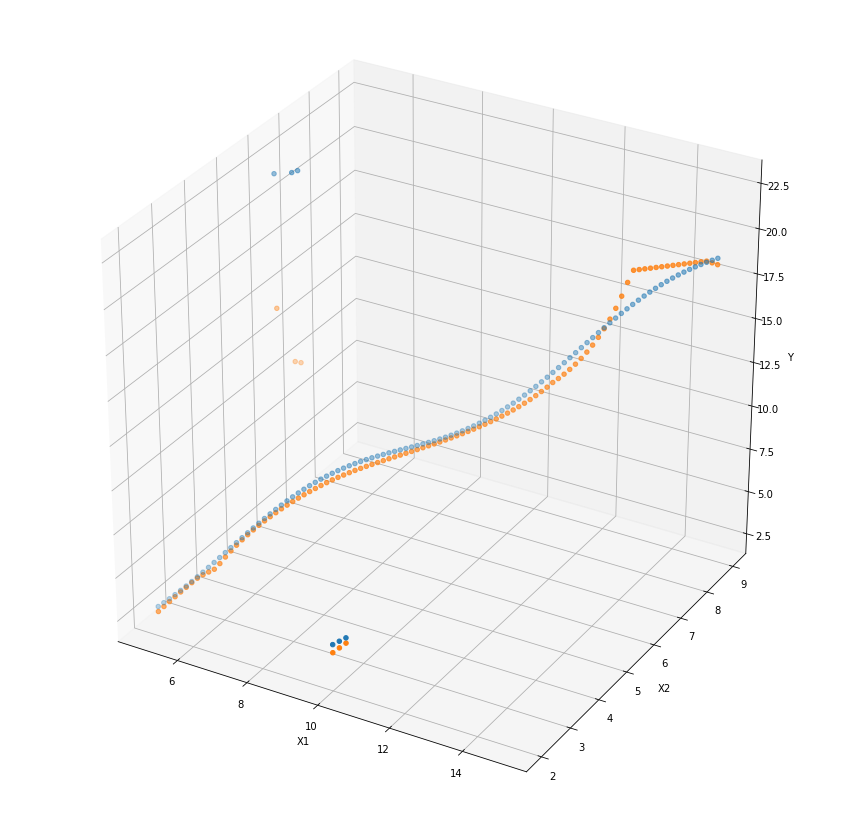

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs)
ax.scatter(X1s, X2s, Ys)
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

### Test 2

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

inp2 = Input()
inp2.n_gen = 50
inp2.n_ind = 30
inp2.n_clone = 6
inp2.n_inf = 6
inp2.boundaries = np.array(boundaries)
inp2.observations = np.array(observations)
inp2.observation_dim = inp2.observations.shape[1]
inp2.desired_outputs = np.array(desired_outputs)
inp2.nr_rules = 10

best_indiv = bacterialEvoulution(inp2)

  2%|▏         | 1/50 [00:15<12:20, 15.11s/it]

best-err:  4.8013359017685815


  4%|▍         | 2/50 [00:30<12:08, 15.18s/it]

best-err:  2.5789160578554475


  6%|▌         | 3/50 [00:45<11:53, 15.19s/it]

best-err:  2.151994478660362


  8%|▊         | 4/50 [01:01<11:46, 15.36s/it]

best-err:  1.6635971954606323


 10%|█         | 5/50 [01:16<11:32, 15.39s/it]

best-err:  1.6635971954606323


 12%|█▏        | 6/50 [01:31<11:12, 15.29s/it]

best-err:  1.6635971954606323


 14%|█▍        | 7/50 [01:46<10:57, 15.29s/it]

best-err:  1.6635971954606323


 16%|█▌        | 8/50 [02:02<10:40, 15.25s/it]

best-err:  1.6635971954606323


 18%|█▊        | 9/50 [02:17<10:24, 15.24s/it]

best-err:  1.6635971954606323


 20%|██        | 10/50 [02:32<10:09, 15.23s/it]

best-err:  1.6635971954606323


 22%|██▏       | 11/50 [02:47<09:54, 15.26s/it]

best-err:  1.6635971954606323


 24%|██▍       | 12/50 [03:02<09:37, 15.20s/it]

best-err:  1.6635971954606323


 26%|██▌       | 13/50 [03:18<09:21, 15.19s/it]

best-err:  1.6635971954606323


 28%|██▊       | 14/50 [03:33<09:06, 15.19s/it]

best-err:  1.6635971954606323


 30%|███       | 15/50 [03:48<08:52, 15.22s/it]

best-err:  1.6635971954606323


 32%|███▏      | 16/50 [04:03<08:38, 15.25s/it]

best-err:  1.6635971954606323


 34%|███▍      | 17/50 [04:19<08:25, 15.31s/it]

best-err:  1.6635971954606323


 36%|███▌      | 18/50 [04:34<08:10, 15.31s/it]

best-err:  1.636996189792478


 38%|███▊      | 19/50 [04:49<07:54, 15.29s/it]

best-err:  1.636996189792478


 40%|████      | 20/50 [05:05<07:36, 15.23s/it]

best-err:  1.636996189792478


 42%|████▏     | 21/50 [05:20<07:21, 15.21s/it]

best-err:  1.636996189792478


 44%|████▍     | 22/50 [05:35<07:06, 15.23s/it]

best-err:  1.6217386509387044


 46%|████▌     | 23/50 [05:50<06:52, 15.27s/it]

best-err:  1.6217386509387044


 48%|████▊     | 24/50 [06:05<06:34, 15.19s/it]

best-err:  1.58663957416687


 50%|█████     | 25/50 [06:20<06:19, 15.17s/it]

best-err:  1.5742362216011938


 52%|█████▏    | 26/50 [06:35<06:02, 15.11s/it]

best-err:  1.5742362216011938


 54%|█████▍    | 27/50 [06:50<05:46, 15.06s/it]

best-err:  1.5742362216011938


 56%|█████▌    | 28/50 [07:05<05:30, 15.03s/it]

best-err:  1.5742362216011938


 58%|█████▊    | 29/50 [07:21<05:17, 15.11s/it]

best-err:  1.5470706956399265


 60%|██████    | 30/50 [07:36<05:03, 15.17s/it]

best-err:  1.5470706956399265


 62%|██████▏   | 31/50 [07:51<04:49, 15.23s/it]

best-err:  1.5470706956399265


 64%|██████▍   | 32/50 [08:07<04:34, 15.23s/it]

best-err:  1.5470706956399265


 66%|██████▌   | 33/50 [08:22<04:19, 15.24s/it]

best-err:  1.5470706956399265


 68%|██████▊   | 34/50 [08:37<04:03, 15.23s/it]

best-err:  1.5470706956399265


 70%|███████   | 35/50 [08:52<03:49, 15.28s/it]

best-err:  1.5470706956399265


 72%|███████▏  | 36/50 [09:08<03:33, 15.27s/it]

best-err:  1.4614170799402815


 74%|███████▍  | 37/50 [09:23<03:18, 15.29s/it]

best-err:  1.404529424908504


 76%|███████▌  | 38/50 [09:38<03:04, 15.36s/it]

best-err:  1.3039853508861903


 78%|███████▊  | 39/50 [09:54<02:49, 15.39s/it]

best-err:  1.3039853508861903


 80%|████████  | 40/50 [10:09<02:33, 15.39s/it]

best-err:  1.3039853508861903


 82%|████████▏ | 41/50 [10:25<02:18, 15.39s/it]

best-err:  1.3039853508861903


 84%|████████▍ | 42/50 [10:40<02:03, 15.42s/it]

best-err:  1.2785717089830604


 86%|████████▌ | 43/50 [10:56<01:47, 15.38s/it]

best-err:  1.2785717089830604


 88%|████████▊ | 44/50 [11:11<01:32, 15.38s/it]

best-err:  1.2785717089830604


 90%|█████████ | 45/50 [11:26<01:16, 15.36s/it]

best-err:  1.2785717089830604


 92%|█████████▏| 46/50 [11:42<01:01, 15.41s/it]

best-err:  1.2785717089830604


 94%|█████████▍| 47/50 [11:57<00:46, 15.38s/it]

best-err:  1.2785717089830604


 96%|█████████▌| 48/50 [12:12<00:30, 15.38s/it]

best-err:  1.2254982813880249


 98%|█████████▊| 49/50 [12:28<00:15, 15.42s/it]

best-err:  1.2254982813880249


100%|██████████| 50/50 [12:44<00:00, 15.29s/it]

best-err:  1.2254982813880249


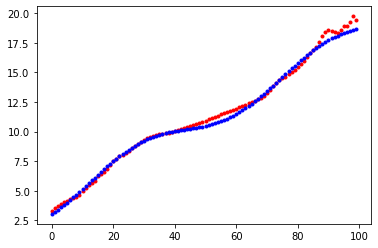

In [ ]:
Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)
plt.plot(Ys, 'r.')
plt.plot(desired_outputs, 'b.')

Text(0.5, 0, 'Y')

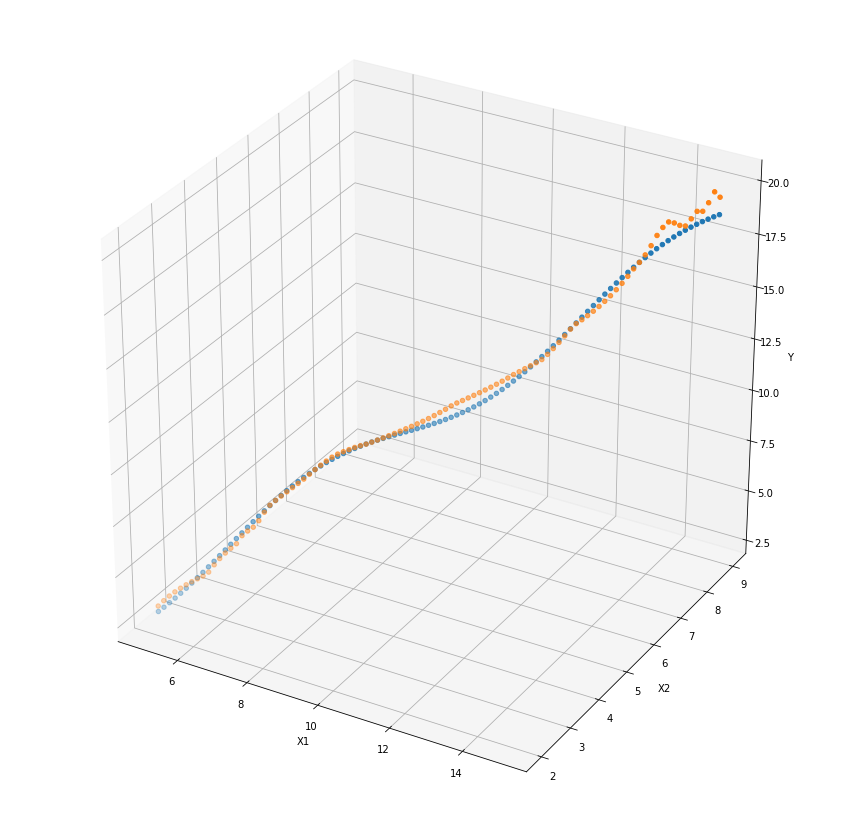

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

ax.scatter(X1s, X2s, desired_outputs)
ax.scatter(X1s, X2s, Ys)
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

# Outlier detection

In [ ]:
def create_outlier_list(Ys, Ds, theta):
  e = (error_canberra_piecewise(Ys,Ds)>=theta)
  return e, np.count_nonzero(e)

In [ ]:
FuzzyRuleBase = {}
ErrorMatrix = {}
OutlierList = {}
OutlierArray = {}
AverageErrors = {}
optRule = 0

THETA = 0.1

def outlierDetection(minRule, maxRule, nRuns, inp:Input):
  for rule in range(minRule, maxRule+1):
    inp.nr_rules=rule
    FuzzyRuleBase[rule] = {}
    ErrorMatrix[rule] = {}
    OutlierArray[rule] = {}
    for run in range(1, nRuns+1):
      FuzzyRuleBase[rule][run] = bacterialEvoulution(inp)
      Ys=mamdaniInference(frbs=FuzzyRuleBase[rule][run], inp=inp)
      ErrorMatrix[rule][run] = error_canberra(Ys=Ys, Ds=inp.desired_outputs)
      OutlierList, OutlierSum = create_outlier_list(Ys=Ys, Ds=inp.desired_outputs, theta=THETA)
      print(f'OutlierList: {OutlierList} , OutlierSum: {OutlierSum}')
      OutlierArray[rule][run] = OutlierList

    sum_ErrorMatrix = 0
    for i in range(1, nRuns+1):
      sum_ErrorMatrix += ErrorMatrix[rule][i]
    AverageErrors[rule] = (1/nRuns) * sum_ErrorMatrix

  ErrorDrop = AverageErrors[minRule] - AverageErrors[minRule+1]
  maxErrorDrop = ErrorDrop
  optRule = minRule
  for rule in range(minRule+1, maxRule):
    ErrorDrop = AverageErrors[rule] - AverageErrors[rule+1]
    # print(f'Rule: {rule} - ErrorDrop:  {ErrorDrop}')
    if ErrorDrop > maxErrorDrop:
      maxErrorDrop = ErrorDrop
      optRule = rule
  OutlierList = OutlierArray[optRule][1]
  for run in range(2, nRuns+1):
    OutlierList = np.array(OutlierList)&np.array(OutlierArray[optRule][run])
  # print('OutlierList:', OutlierList)
  # print('optRule: ', optRule)
  return OutlierList, FuzzyRuleBase

### Test

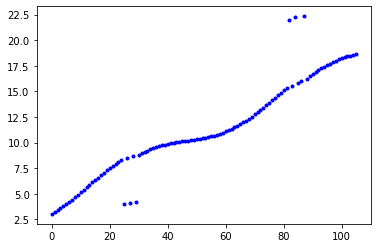

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

X1s = np.linspace(5, 15, 100)
X2s = np.linspace(2, 9, 100)


def f(x1, x2):
  return np.sin(x1) + 2*x2


desired_outputs = f(X1s, X2s)
desired_outputs = np.insert(desired_outputs, [25,26,27,79,80,82], [4,4.1,4.2,22,22.3, 22.34]) 
X1s = np.insert(X1s, [25,26,27,79,80,82], [10, 10.1, 10.2, 5,5.5, 5.59]) 
X2s = np.insert(X2s, [25,26,27,79,80,82], [2,2.1,2.2, 6,6.01,6.1]) 

plt.plot(desired_outputs, '.b')

observations = list(zip(X1s, X2s))

In [ ]:
inp = Input()
inp.n_gen = 50
inp.n_ind = 20
inp.n_clone = 10
inp.n_inf = 10
inp.boundaries = np.array(boundaries)
inp.observations = np.array(observations)
inp.observation_dim = inp.observations.shape[1]
inp.desired_outputs = np.array(desired_outputs)
inp.nr_rules = 0

minRule, maxRule, nRuns = (2, 5, 3)
ol, frb = outlierDetection(minRule,maxRule,nRuns, inp)
print(FuzzyRuleBase, '\n', ErrorMatrix)

  2%|▏         | 1/50 [00:00<00:37,  1.32it/s]

best-err:  10.56098060094794


  4%|▍         | 2/50 [00:01<00:35,  1.35it/s]

best-err:  10.042494100645298


  6%|▌         | 3/50 [00:02<00:35,  1.33it/s]

best-err:  8.302893553692657


  8%|▊         | 4/50 [00:02<00:34,  1.35it/s]

best-err:  8.176965521870468


 10%|█         | 5/50 [00:03<00:33,  1.32it/s]

best-err:  7.827954706023569


 12%|█▏        | 6/50 [00:04<00:32,  1.35it/s]

best-err:  6.3296859941701324


 14%|█▍        | 7/50 [00:05<00:32,  1.33it/s]

best-err:  6.266485949949918


 16%|█▌        | 8/50 [00:06<00:31,  1.32it/s]

best-err:  6.266485949949918


 18%|█▊        | 9/50 [00:06<00:31,  1.32it/s]

best-err:  5.753736207556241


 20%|██        | 10/50 [00:07<00:30,  1.33it/s]

best-err:  4.908566994192842


 22%|██▏       | 11/50 [00:08<00:29,  1.34it/s]

best-err:  4.908566994192842


 24%|██▍       | 12/50 [00:09<00:28,  1.32it/s]

best-err:  4.908566994192842


 26%|██▌       | 13/50 [00:09<00:27,  1.34it/s]

best-err:  4.908566994192842


 28%|██▊       | 14/50 [00:10<00:26,  1.37it/s]

best-err:  4.908566994192842


 30%|███       | 15/50 [00:11<00:25,  1.36it/s]

best-err:  4.908566994192842


 32%|███▏      | 16/50 [00:11<00:25,  1.35it/s]

best-err:  4.908566994192842


 34%|███▍      | 17/50 [00:12<00:24,  1.32it/s]

best-err:  4.908566994192842


 36%|███▌      | 18/50 [00:13<00:23,  1.33it/s]

best-err:  4.908566994192842


 38%|███▊      | 19/50 [00:14<00:23,  1.32it/s]

best-err:  4.908566994192842


 40%|████      | 20/50 [00:14<00:22,  1.34it/s]

best-err:  4.908566994192842


 42%|████▏     | 21/50 [00:15<00:21,  1.34it/s]

best-err:  4.908566994192842


 44%|████▍     | 22/50 [00:16<00:20,  1.35it/s]

best-err:  4.908566994192842


 46%|████▌     | 23/50 [00:17<00:19,  1.35it/s]

best-err:  4.825856973345993


 48%|████▊     | 24/50 [00:17<00:19,  1.33it/s]

best-err:  4.825856973345993


 50%|█████     | 25/50 [00:18<00:18,  1.34it/s]

best-err:  4.825856973345993


 52%|█████▏    | 26/50 [00:19<00:17,  1.36it/s]

best-err:  4.601459541218918


 54%|█████▍    | 27/50 [00:20<00:16,  1.38it/s]

best-err:  4.601459541218918


 56%|█████▌    | 28/50 [00:20<00:16,  1.30it/s]

best-err:  4.601459541218918


 58%|█████▊    | 29/50 [00:22<00:19,  1.06it/s]

best-err:  4.601459541218918


 60%|██████    | 30/50 [00:23<00:19,  1.04it/s]

best-err:  4.601459541218918


 62%|██████▏   | 31/50 [00:24<00:16,  1.13it/s]

best-err:  4.601459541218918


 64%|██████▍   | 32/50 [00:24<00:15,  1.18it/s]

best-err:  4.601459541218918


 66%|██████▌   | 33/50 [00:25<00:13,  1.25it/s]

best-err:  4.601459541218918


 68%|██████▊   | 34/50 [00:26<00:12,  1.27it/s]

best-err:  4.601459541218918


 70%|███████   | 35/50 [00:26<00:11,  1.29it/s]

best-err:  4.601459541218918


 72%|███████▏  | 36/50 [00:27<00:10,  1.33it/s]

best-err:  4.601459541218918


 74%|███████▍  | 37/50 [00:28<00:09,  1.34it/s]

best-err:  4.601459541218918


 76%|███████▌  | 38/50 [00:29<00:08,  1.35it/s]

best-err:  4.2343444491422675


 78%|███████▊  | 39/50 [00:29<00:08,  1.37it/s]

best-err:  4.2343444491422675


 80%|████████  | 40/50 [00:30<00:07,  1.35it/s]

best-err:  4.2343444491422675


 82%|████████▏ | 41/50 [00:31<00:06,  1.33it/s]

best-err:  4.2343444491422675


 84%|████████▍ | 42/50 [00:32<00:06,  1.31it/s]

best-err:  4.2343444491422675


 86%|████████▌ | 43/50 [00:32<00:05,  1.30it/s]

best-err:  4.2343444491422675


 88%|████████▊ | 44/50 [00:33<00:04,  1.30it/s]

best-err:  4.2343444491422675


 90%|█████████ | 45/50 [00:34<00:03,  1.31it/s]

best-err:  4.2343444491422675


 92%|█████████▏| 46/50 [00:35<00:03,  1.31it/s]

best-err:  4.2343444491422675


 94%|█████████▍| 47/50 [00:36<00:02,  1.30it/s]

best-err:  4.2343444491422675


 96%|█████████▌| 48/50 [00:36<00:01,  1.32it/s]

best-err:  4.2343444491422675


 98%|█████████▊| 49/50 [00:37<00:00,  1.34it/s]

best-err:  4.159321819428398


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


best-err:  4.159321819428398
OutlierList: [ True  True  True  True  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
  True False False  True False False False False False False False False
 False False False False False False False False False False] , OutlierSum: 9


  2%|▏         | 1/50 [00:00<00:37,  1.32it/s]

best-err:  8.45962851128932


  4%|▍         | 2/50 [00:01<00:37,  1.30it/s]

best-err:  8.45962851128932


  6%|▌         | 3/50 [00:02<00:35,  1.33it/s]

best-err:  8.45962851128932


  8%|▊         | 4/50 [00:03<00:34,  1.32it/s]

best-err:  8.45962851128932


 10%|█         | 5/50 [00:03<00:33,  1.35it/s]

best-err:  6.946734071772767


 12%|█▏        | 6/50 [00:04<00:33,  1.32it/s]

best-err:  6.5711918987979505


 14%|█▍        | 7/50 [00:05<00:32,  1.32it/s]

best-err:  6.5711918987979505


 16%|█▌        | 8/50 [00:06<00:32,  1.31it/s]

best-err:  6.5711918987979505


 18%|█▊        | 9/50 [00:06<00:31,  1.30it/s]

best-err:  6.5711918987979505


 20%|██        | 10/50 [00:07<00:30,  1.33it/s]

best-err:  5.289601136658347


 22%|██▏       | 11/50 [00:08<00:29,  1.31it/s]

best-err:  4.785322631703295


 24%|██▍       | 12/50 [00:09<00:28,  1.34it/s]

best-err:  4.785322631703295


 26%|██▌       | 13/50 [00:09<00:27,  1.33it/s]

best-err:  4.785322631703295


 28%|██▊       | 14/50 [00:10<00:26,  1.33it/s]

best-err:  4.785322631703295


 30%|███       | 15/50 [00:11<00:26,  1.34it/s]

best-err:  4.785322631703295


 32%|███▏      | 16/50 [00:12<00:25,  1.34it/s]

best-err:  4.785322631703295


 34%|███▍      | 17/50 [00:12<00:24,  1.35it/s]

best-err:  4.785322631703295


 36%|███▌      | 18/50 [00:13<00:23,  1.34it/s]

best-err:  4.785322631703295


 38%|███▊      | 19/50 [00:14<00:22,  1.35it/s]

best-err:  4.785322631703295


 40%|████      | 20/50 [00:15<00:22,  1.35it/s]

best-err:  4.785322631703295


 42%|████▏     | 21/50 [00:15<00:21,  1.34it/s]

best-err:  4.785322631703295


 44%|████▍     | 22/50 [00:16<00:20,  1.36it/s]

best-err:  4.785322631703295


 46%|████▌     | 23/50 [00:17<00:20,  1.35it/s]

best-err:  4.785322631703295


 48%|████▊     | 24/50 [00:18<00:19,  1.33it/s]

best-err:  4.785322631703295


 50%|█████     | 25/50 [00:18<00:18,  1.36it/s]

best-err:  4.785322631703295


 52%|█████▏    | 26/50 [00:19<00:17,  1.35it/s]

best-err:  4.785322631703295


 54%|█████▍    | 27/50 [00:20<00:16,  1.36it/s]

best-err:  4.785322631703295


 56%|█████▌    | 28/50 [00:20<00:16,  1.35it/s]

best-err:  4.785322631703295


 58%|█████▊    | 29/50 [00:21<00:15,  1.34it/s]

best-err:  4.785322631703295


 60%|██████    | 30/50 [00:22<00:14,  1.35it/s]

best-err:  4.785322631703295


 62%|██████▏   | 31/50 [00:23<00:14,  1.34it/s]

best-err:  4.785322631703295


 64%|██████▍   | 32/50 [00:23<00:13,  1.37it/s]

best-err:  4.785322631703295


 66%|██████▌   | 33/50 [00:24<00:12,  1.36it/s]

best-err:  4.785322631703295


 68%|██████▊   | 34/50 [00:25<00:11,  1.40it/s]

best-err:  4.785322631703295


 70%|███████   | 35/50 [00:26<00:10,  1.37it/s]

best-err:  4.785322631703295


 72%|███████▏  | 36/50 [00:26<00:10,  1.37it/s]

best-err:  4.409872562799678


 74%|███████▍  | 37/50 [00:27<00:09,  1.37it/s]

best-err:  4.409872562799678


 76%|███████▌  | 38/50 [00:28<00:08,  1.38it/s]

best-err:  4.409872562799678


 78%|███████▊  | 39/50 [00:28<00:08,  1.37it/s]

best-err:  4.409872562799678


 80%|████████  | 40/50 [00:29<00:07,  1.34it/s]

best-err:  4.364081101263259


 82%|████████▏ | 41/50 [00:30<00:06,  1.32it/s]

best-err:  4.205785248598127


 84%|████████▍ | 42/50 [00:31<00:05,  1.35it/s]

best-err:  4.205785248598127


 86%|████████▌ | 43/50 [00:31<00:05,  1.36it/s]

best-err:  4.205785248598127


 88%|████████▊ | 44/50 [00:32<00:04,  1.36it/s]

best-err:  3.4826133650043034


 90%|█████████ | 45/50 [00:33<00:03,  1.39it/s]

best-err:  3.4826133650043034


 92%|█████████▏| 46/50 [00:34<00:02,  1.37it/s]

best-err:  3.4826133650043034


 94%|█████████▍| 47/50 [00:34<00:02,  1.38it/s]

best-err:  3.4826133650043034


 96%|█████████▌| 48/50 [00:35<00:01,  1.34it/s]

best-err:  3.4826133650043034


 98%|█████████▊| 49/50 [00:36<00:00,  1.33it/s]

best-err:  3.4826133650043034


100%|██████████| 50/50 [00:37<00:00,  1.35it/s]


best-err:  3.4826133650043034
OutlierList: [ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
  True False False  True False False False False False False False False
 False False False False False False False False False False] , OutlierSum: 5


  2%|▏         | 1/50 [00:00<00:36,  1.34it/s]

best-err:  13.566666946022833


  4%|▍         | 2/50 [00:01<00:36,  1.32it/s]

best-err:  8.96164373624292


  6%|▌         | 3/50 [00:02<00:35,  1.33it/s]

best-err:  8.96164373624292


  8%|▊         | 4/50 [00:03<00:34,  1.33it/s]

best-err:  8.96164373624292


 10%|█         | 5/50 [00:03<00:33,  1.36it/s]

best-err:  7.282349411311583


 12%|█▏        | 6/50 [00:04<00:31,  1.40it/s]

best-err:  7.282349411311583


 14%|█▍        | 7/50 [00:05<00:29,  1.44it/s]

best-err:  7.282349411311583


 16%|█▌        | 8/50 [00:05<00:29,  1.40it/s]

best-err:  7.282349411311583


 18%|█▊        | 9/50 [00:06<00:30,  1.37it/s]

best-err:  7.282349411311583


 20%|██        | 10/50 [00:07<00:29,  1.37it/s]

best-err:  7.282349411311583


 22%|██▏       | 11/50 [00:08<00:28,  1.37it/s]

best-err:  7.282349411311583


 24%|██▍       | 12/50 [00:08<00:27,  1.37it/s]

best-err:  7.282349411311583


 26%|██▌       | 13/50 [00:09<00:27,  1.36it/s]

best-err:  6.784514706120912


 28%|██▊       | 14/50 [00:10<00:27,  1.33it/s]

best-err:  6.784514706120912


 30%|███       | 15/50 [00:11<00:26,  1.33it/s]

best-err:  6.784514706120912


 32%|███▏      | 16/50 [00:11<00:24,  1.36it/s]

best-err:  6.784514706120912


 34%|███▍      | 17/50 [00:12<00:23,  1.38it/s]

best-err:  6.784514706120912


 36%|███▌      | 18/50 [00:13<00:23,  1.34it/s]

best-err:  6.784514706120912


 38%|███▊      | 19/50 [00:14<00:23,  1.33it/s]

best-err:  6.784514706120912


 40%|████      | 20/50 [00:14<00:22,  1.36it/s]

best-err:  6.784514706120912


 42%|████▏     | 21/50 [00:15<00:21,  1.36it/s]

best-err:  6.784514706120912


 44%|████▍     | 22/50 [00:16<00:20,  1.35it/s]

best-err:  6.784514706120912


 46%|████▌     | 23/50 [00:16<00:20,  1.33it/s]

best-err:  5.70390651171999


 48%|████▊     | 24/50 [00:17<00:19,  1.33it/s]

best-err:  5.70390651171999


 50%|█████     | 25/50 [00:18<00:18,  1.33it/s]

best-err:  5.70390651171999


 52%|█████▏    | 26/50 [00:19<00:18,  1.33it/s]

best-err:  5.70390651171999


 54%|█████▍    | 27/50 [00:19<00:17,  1.34it/s]

best-err:  5.70390651171999


 56%|█████▌    | 28/50 [00:20<00:16,  1.35it/s]

best-err:  5.70390651171999


 58%|█████▊    | 29/50 [00:21<00:15,  1.35it/s]

best-err:  5.70390651171999


 60%|██████    | 30/50 [00:22<00:14,  1.36it/s]

best-err:  4.795615491711274


 62%|██████▏   | 31/50 [00:22<00:13,  1.38it/s]

best-err:  4.795615491711274


 64%|██████▍   | 32/50 [00:23<00:13,  1.38it/s]

best-err:  4.795615491711274


 66%|██████▌   | 33/50 [00:24<00:12,  1.37it/s]

best-err:  4.795615491711274


 68%|██████▊   | 34/50 [00:25<00:11,  1.36it/s]

best-err:  4.795615491711274


 70%|███████   | 35/50 [00:25<00:11,  1.35it/s]

best-err:  4.795615491711274


 72%|███████▏  | 36/50 [00:26<00:10,  1.37it/s]

best-err:  4.795615491711274


 74%|███████▍  | 37/50 [00:27<00:09,  1.33it/s]

best-err:  4.795615491711274


 76%|███████▌  | 38/50 [00:28<00:09,  1.32it/s]

best-err:  4.795615491711274


 78%|███████▊  | 39/50 [00:28<00:08,  1.34it/s]

best-err:  4.795615491711274


 80%|████████  | 40/50 [00:29<00:07,  1.35it/s]

best-err:  4.795615491711274


 82%|████████▏ | 41/50 [00:30<00:06,  1.32it/s]

best-err:  4.376461064602008


 84%|████████▍ | 42/50 [00:31<00:06,  1.33it/s]

best-err:  4.376461064602008


 86%|████████▌ | 43/50 [00:31<00:05,  1.36it/s]

best-err:  4.376461064602008


 88%|████████▊ | 44/50 [00:32<00:04,  1.33it/s]

best-err:  4.376461064602008


 90%|█████████ | 45/50 [00:33<00:03,  1.31it/s]

best-err:  4.376461064602008


 92%|█████████▏| 46/50 [00:34<00:02,  1.35it/s]

best-err:  4.376461064602008


 94%|█████████▍| 47/50 [00:34<00:02,  1.34it/s]

best-err:  4.376461064602008


 96%|█████████▌| 48/50 [00:35<00:01,  1.38it/s]

best-err:  4.376461064602008


 98%|█████████▊| 49/50 [00:36<00:00,  1.38it/s]

best-err:  4.376461064602008


100%|██████████| 50/50 [00:36<00:00,  1.35it/s]


best-err:  4.376461064602008
OutlierList: [False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False  True False  True False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
  True False False  True False False False False False False False False
 False False False False False False False False False False] , OutlierSum: 7


  2%|▏         | 1/50 [00:01<01:02,  1.28s/it]

best-err:  9.975077857446209


  4%|▍         | 2/50 [00:02<00:59,  1.25s/it]

best-err:  8.985225494231187


  6%|▌         | 3/50 [00:03<00:59,  1.27s/it]

best-err:  6.1656276594290205


  8%|▊         | 4/50 [00:05<00:59,  1.30s/it]

best-err:  6.1656276594290205


 10%|█         | 5/50 [00:06<00:58,  1.30s/it]

best-err:  5.899493197887196


 12%|█▏        | 6/50 [00:07<00:56,  1.28s/it]

best-err:  5.899493197887196


 14%|█▍        | 7/50 [00:08<00:55,  1.28s/it]

best-err:  5.3213002720645415


 16%|█▌        | 8/50 [00:10<00:53,  1.28s/it]

best-err:  4.537471580857047


 18%|█▊        | 9/50 [00:11<00:51,  1.25s/it]

best-err:  4.537471580857047


 20%|██        | 10/50 [00:12<00:50,  1.26s/it]

best-err:  4.537471580857047


 22%|██▏       | 11/50 [00:14<00:50,  1.29s/it]

best-err:  4.1556253560524326


 24%|██▍       | 12/50 [00:15<00:47,  1.25s/it]

best-err:  4.1556253560524326


 26%|██▌       | 13/50 [00:16<00:48,  1.32s/it]

best-err:  4.1556253560524326


 28%|██▊       | 14/50 [00:18<00:47,  1.33s/it]

best-err:  4.1556253560524326


 30%|███       | 15/50 [00:19<00:44,  1.27s/it]

best-err:  4.1556253560524326


 32%|███▏      | 16/50 [00:20<00:41,  1.21s/it]

best-err:  4.1556253560524326


 34%|███▍      | 17/50 [00:21<00:40,  1.22s/it]

best-err:  4.1556253560524326


 36%|███▌      | 18/50 [00:22<00:39,  1.24s/it]

best-err:  4.1556253560524326


 38%|███▊      | 19/50 [00:24<00:39,  1.26s/it]

best-err:  4.1556253560524326


 40%|████      | 20/50 [00:25<00:38,  1.27s/it]

best-err:  4.1556253560524326


 42%|████▏     | 21/50 [00:26<00:37,  1.28s/it]

best-err:  4.1556253560524326


 44%|████▍     | 22/50 [00:27<00:35,  1.27s/it]

best-err:  3.9098576171724018


 46%|████▌     | 23/50 [00:29<00:34,  1.29s/it]

best-err:  3.9098576171724018


 48%|████▊     | 24/50 [00:30<00:34,  1.32s/it]

best-err:  3.9098576171724018


 50%|█████     | 25/50 [00:31<00:32,  1.30s/it]

best-err:  3.9098576171724018


 52%|█████▏    | 26/50 [00:33<00:31,  1.30s/it]

best-err:  3.624291049718648


 54%|█████▍    | 27/50 [00:34<00:29,  1.29s/it]

best-err:  3.624291049718648


 56%|█████▌    | 28/50 [00:35<00:28,  1.31s/it]

best-err:  3.624291049718648


 58%|█████▊    | 29/50 [00:37<00:27,  1.31s/it]

best-err:  3.624291049718648


 60%|██████    | 30/50 [00:38<00:26,  1.34s/it]

best-err:  3.624291049718648


 62%|██████▏   | 31/50 [00:39<00:24,  1.31s/it]

best-err:  3.624291049718648


 64%|██████▍   | 32/50 [00:41<00:23,  1.32s/it]

best-err:  3.624291049718648


 66%|██████▌   | 33/50 [00:42<00:21,  1.27s/it]

best-err:  3.624291049718648


 68%|██████▊   | 34/50 [00:43<00:20,  1.26s/it]

best-err:  3.624291049718648


 70%|███████   | 35/50 [00:44<00:19,  1.27s/it]

best-err:  3.624291049718648


 72%|███████▏  | 36/50 [00:46<00:17,  1.26s/it]

best-err:  3.624291049718648


 74%|███████▍  | 37/50 [00:47<00:16,  1.29s/it]

best-err:  3.624291049718648


 76%|███████▌  | 38/50 [00:48<00:15,  1.29s/it]

best-err:  3.624291049718648


 78%|███████▊  | 39/50 [00:50<00:14,  1.29s/it]

best-err:  3.624291049718648


 80%|████████  | 40/50 [00:51<00:12,  1.28s/it]

best-err:  3.590174455788841


 82%|████████▏ | 41/50 [00:52<00:11,  1.30s/it]

best-err:  3.590174455788841


 84%|████████▍ | 42/50 [00:54<00:10,  1.34s/it]

best-err:  3.590174455788841


 86%|████████▌ | 43/50 [00:55<00:09,  1.33s/it]

best-err:  3.590174455788841


 88%|████████▊ | 44/50 [00:56<00:07,  1.32s/it]

best-err:  3.590174455788841


 90%|█████████ | 45/50 [00:58<00:06,  1.32s/it]

best-err:  3.590174455788841


 92%|█████████▏| 46/50 [00:59<00:05,  1.27s/it]

best-err:  3.590174455788841


 94%|█████████▍| 47/50 [01:00<00:03,  1.26s/it]

best-err:  3.590174455788841


 96%|█████████▌| 48/50 [01:01<00:02,  1.27s/it]

best-err:  3.590174455788841


 98%|█████████▊| 49/50 [01:03<00:01,  1.30s/it]

best-err:  3.590174455788841


100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


best-err:  3.561966457699583
OutlierList: [ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
  True False False  True False False False False False False False False
 False False False False False False False False False False] , OutlierSum: 7


  2%|▏         | 1/50 [00:01<01:02,  1.28s/it]

best-err:  11.334369646054231


  4%|▍         | 2/50 [00:02<01:02,  1.30s/it]

best-err:  8.653787557959728


  6%|▌         | 3/50 [00:03<00:57,  1.22s/it]

best-err:  8.493695947112395


  8%|▊         | 4/50 [00:05<00:58,  1.27s/it]

best-err:  8.493695947112395


 10%|█         | 5/50 [00:06<00:57,  1.29s/it]

best-err:  8.363941255209335


 12%|█▏        | 6/50 [00:07<00:56,  1.28s/it]

best-err:  7.62761778902575


 14%|█▍        | 7/50 [00:08<00:54,  1.27s/it]

best-err:  6.619952958936994


 16%|█▌        | 8/50 [00:10<00:54,  1.30s/it]

best-err:  5.682349816997557


 18%|█▊        | 9/50 [00:11<00:53,  1.31s/it]

best-err:  5.682349816997557


 20%|██        | 10/50 [00:12<00:51,  1.30s/it]

best-err:  5.682349816997557


 22%|██▏       | 11/50 [00:14<00:49,  1.27s/it]

best-err:  5.682349816997557


 24%|██▍       | 12/50 [00:15<00:48,  1.29s/it]

best-err:  4.6177611322336745


 26%|██▌       | 13/50 [00:16<00:46,  1.25s/it]

best-err:  4.6177611322336745


 28%|██▊       | 14/50 [00:17<00:45,  1.26s/it]

best-err:  4.6177611322336745


 30%|███       | 15/50 [00:19<00:43,  1.25s/it]

best-err:  4.6177611322336745


 32%|███▏      | 16/50 [00:20<00:44,  1.30s/it]

best-err:  4.181690213698468


 34%|███▍      | 17/50 [00:21<00:41,  1.27s/it]

best-err:  3.8074772572671702


 36%|███▌      | 18/50 [00:22<00:39,  1.25s/it]

best-err:  3.8074772572671702


 38%|███▊      | 19/50 [00:24<00:38,  1.24s/it]

best-err:  3.8074772572671702


 40%|████      | 20/50 [00:25<00:37,  1.25s/it]

best-err:  3.8074772572671702


 42%|████▏     | 21/50 [00:26<00:36,  1.25s/it]

best-err:  3.8074772572671702


 44%|████▍     | 22/50 [00:27<00:34,  1.24s/it]

best-err:  3.8074772572671702


 46%|████▌     | 23/50 [00:29<00:34,  1.26s/it]

best-err:  3.8074772572671702


 48%|████▊     | 24/50 [00:30<00:33,  1.29s/it]

best-err:  3.7891757906188923


 50%|█████     | 25/50 [00:31<00:32,  1.31s/it]

best-err:  3.7891757906188923


 52%|█████▏    | 26/50 [00:32<00:30,  1.25s/it]

best-err:  3.7891757906188923


 54%|█████▍    | 27/50 [00:34<00:29,  1.27s/it]

best-err:  3.7891757906188923


 56%|█████▌    | 28/50 [00:35<00:27,  1.27s/it]

best-err:  3.7891757906188923


 58%|█████▊    | 29/50 [00:36<00:26,  1.24s/it]

best-err:  3.7891757906188923


 60%|██████    | 30/50 [00:38<00:25,  1.26s/it]

best-err:  3.7891757906188923


 62%|██████▏   | 31/50 [00:39<00:24,  1.29s/it]

best-err:  3.7891757906188923


 64%|██████▍   | 32/50 [00:40<00:23,  1.31s/it]

best-err:  3.7891757906188923


 66%|██████▌   | 33/50 [00:42<00:22,  1.34s/it]

best-err:  3.7891757906188923


 68%|██████▊   | 34/50 [00:43<00:21,  1.35s/it]

best-err:  3.7891757906188923


 70%|███████   | 35/50 [00:44<00:19,  1.32s/it]

best-err:  3.7891757906188923


 72%|███████▏  | 36/50 [00:46<00:18,  1.33s/it]

best-err:  3.7891757906188923


 74%|███████▍  | 37/50 [00:47<00:17,  1.31s/it]

best-err:  3.7891757906188923


 76%|███████▌  | 38/50 [00:48<00:15,  1.31s/it]

best-err:  3.7891757906188923


 78%|███████▊  | 39/50 [00:49<00:14,  1.29s/it]

best-err:  3.7891757906188923


 80%|████████  | 40/50 [00:51<00:13,  1.32s/it]

best-err:  3.7891757906188923


 82%|████████▏ | 41/50 [00:52<00:12,  1.33s/it]

best-err:  3.7891757906188923


 84%|████████▍ | 42/50 [00:53<00:10,  1.32s/it]

best-err:  3.7891757906188923


 86%|████████▌ | 43/50 [00:55<00:09,  1.30s/it]

best-err:  3.7891757906188923


 88%|████████▊ | 44/50 [00:56<00:08,  1.34s/it]

best-err:  3.7891757906188923


 90%|█████████ | 45/50 [00:57<00:06,  1.32s/it]

best-err:  3.7891757906188923


 92%|█████████▏| 46/50 [00:59<00:05,  1.29s/it]

best-err:  3.7891757906188923


 94%|█████████▍| 47/50 [01:00<00:03,  1.28s/it]

best-err:  3.7891757906188923


 96%|█████████▌| 48/50 [01:01<00:02,  1.30s/it]

best-err:  3.7891757906188923


 98%|█████████▊| 49/50 [01:03<00:01,  1.30s/it]

best-err:  3.7891757906188923


100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


best-err:  3.7891757906188923
OutlierList: [ True  True  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False  True False  True False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
  True False False  True False False False False False False False False
 False False False False False False False False False False] , OutlierSum: 11


  2%|▏         | 1/50 [00:01<00:53,  1.09s/it]

best-err:  12.829397614564208


  4%|▍         | 2/50 [00:02<01:00,  1.25s/it]

best-err:  10.38942929935411


  6%|▌         | 3/50 [00:03<00:58,  1.25s/it]

best-err:  9.620591165790723


  8%|▊         | 4/50 [00:04<00:57,  1.26s/it]

best-err:  7.088852539640489


 10%|█         | 5/50 [00:06<00:56,  1.25s/it]

best-err:  7.088852539640489


 12%|█▏        | 6/50 [00:07<00:53,  1.21s/it]

best-err:  7.088852539640489


 14%|█▍        | 7/50 [00:08<00:54,  1.26s/it]

best-err:  5.725573300215284


 16%|█▌        | 8/50 [00:09<00:52,  1.26s/it]

best-err:  5.725573300215284


 18%|█▊        | 9/50 [00:11<00:52,  1.28s/it]

best-err:  5.725573300215284


 20%|██        | 10/50 [00:12<00:52,  1.32s/it]

best-err:  5.360326925796305


 22%|██▏       | 11/50 [00:14<00:51,  1.32s/it]

best-err:  5.360326925796305


 24%|██▍       | 12/50 [00:15<00:50,  1.33s/it]

best-err:  5.360326925796305


 26%|██▌       | 13/50 [00:16<00:47,  1.28s/it]

best-err:  5.360326925796305


 28%|██▊       | 14/50 [00:17<00:45,  1.27s/it]

best-err:  5.353814252014425


 30%|███       | 15/50 [00:19<00:46,  1.33s/it]

best-err:  5.353814252014425


 32%|███▏      | 16/50 [00:20<00:46,  1.36s/it]

best-err:  5.353814252014425


 34%|███▍      | 17/50 [00:21<00:43,  1.32s/it]

best-err:  4.355759708023422


 36%|███▌      | 18/50 [00:23<00:43,  1.35s/it]

best-err:  4.355759708023422


 38%|███▊      | 19/50 [00:24<00:41,  1.34s/it]

best-err:  4.355759708023422


 40%|████      | 20/50 [00:25<00:39,  1.31s/it]

best-err:  4.355759708023422


 42%|████▏     | 21/50 [00:27<00:38,  1.33s/it]

best-err:  4.069077720820996


 44%|████▍     | 22/50 [00:28<00:36,  1.30s/it]

best-err:  4.069077720820996


 46%|████▌     | 23/50 [00:29<00:35,  1.31s/it]

best-err:  4.069077720820996


 48%|████▊     | 24/50 [00:30<00:32,  1.25s/it]

best-err:  4.069077720820996


 50%|█████     | 25/50 [00:32<00:32,  1.30s/it]

best-err:  4.069077720820996


 52%|█████▏    | 26/50 [00:33<00:29,  1.22s/it]

best-err:  4.069077720820996


 54%|█████▍    | 27/50 [00:34<00:28,  1.25s/it]

best-err:  4.069077720820996


 56%|█████▌    | 28/50 [00:36<00:27,  1.27s/it]

best-err:  4.069077720820996


 58%|█████▊    | 29/50 [00:37<00:26,  1.26s/it]

best-err:  4.069077720820996


 60%|██████    | 30/50 [00:38<00:26,  1.31s/it]

best-err:  4.069077720820996


 62%|██████▏   | 31/50 [00:39<00:24,  1.30s/it]

best-err:  4.069077720820996


 64%|██████▍   | 32/50 [00:41<00:22,  1.28s/it]

best-err:  4.069077720820996


 66%|██████▌   | 33/50 [00:42<00:21,  1.27s/it]

best-err:  4.069077720820996


 68%|██████▊   | 34/50 [00:43<00:20,  1.26s/it]

best-err:  4.069077720820996


 70%|███████   | 35/50 [00:44<00:18,  1.24s/it]

best-err:  3.9108624652697204


 72%|███████▏  | 36/50 [00:46<00:17,  1.27s/it]

best-err:  3.9108624652697204


 74%|███████▍  | 37/50 [00:47<00:16,  1.26s/it]

best-err:  3.9108624652697204


 76%|███████▌  | 38/50 [00:48<00:15,  1.28s/it]

best-err:  3.9108624652697204


 78%|███████▊  | 39/50 [00:50<00:14,  1.28s/it]

best-err:  3.9108624652697204


 80%|████████  | 40/50 [00:51<00:13,  1.32s/it]

best-err:  3.9108624652697204


 82%|████████▏ | 41/50 [00:52<00:12,  1.35s/it]

best-err:  3.9108624652697204


 84%|████████▍ | 42/50 [00:54<00:10,  1.30s/it]

best-err:  3.9108624652697204


 86%|████████▌ | 43/50 [00:55<00:09,  1.29s/it]

best-err:  3.5253673603640814


 88%|████████▊ | 44/50 [00:56<00:07,  1.29s/it]

best-err:  3.5253673603640814


 90%|█████████ | 45/50 [00:58<00:07,  1.42s/it]

best-err:  3.5253673603640814


 92%|█████████▏| 46/50 [01:00<00:06,  1.61s/it]

best-err:  3.5253673603640814


 94%|█████████▍| 47/50 [01:01<00:04,  1.53s/it]

best-err:  3.5253673603640814


 96%|█████████▌| 48/50 [01:03<00:02,  1.45s/it]

best-err:  3.5253673603640814


 98%|█████████▊| 49/50 [01:04<00:01,  1.36s/it]

best-err:  3.5253673603640814


100%|██████████| 50/50 [01:05<00:00,  1.31s/it]


best-err:  3.5253673603640814
OutlierList: [ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
  True False False  True False False False False False False False False
 False False False False False False False False False False] , OutlierSum: 5


  2%|▏         | 1/50 [00:01<01:28,  1.80s/it]

best-err:  8.104589691061657


  4%|▍         | 2/50 [00:04<01:40,  2.08s/it]

best-err:  7.391900183302045


  6%|▌         | 3/50 [00:06<01:37,  2.07s/it]

best-err:  7.256568723075877


  8%|▊         | 4/50 [00:08<01:31,  2.00s/it]

best-err:  7.248404451432967


 10%|█         | 5/50 [00:10<01:29,  2.00s/it]

best-err:  6.787089422752267


 12%|█▏        | 6/50 [00:11<01:27,  1.99s/it]

best-err:  5.367345191539417


 14%|█▍        | 7/50 [00:13<01:25,  1.99s/it]

best-err:  5.367345191539417


 16%|█▌        | 8/50 [00:15<01:23,  1.99s/it]

best-err:  4.966475642317012


 18%|█▊        | 9/50 [00:17<01:18,  1.92s/it]

best-err:  4.966475642317012


 20%|██        | 10/50 [00:19<01:17,  1.93s/it]

best-err:  4.966475642317012


 22%|██▏       | 11/50 [00:21<01:15,  1.93s/it]

best-err:  4.966475642317012


 24%|██▍       | 12/50 [00:23<01:15,  1.98s/it]

best-err:  4.966475642317012


 26%|██▌       | 13/50 [00:25<01:14,  2.03s/it]

best-err:  4.966475642317012


 28%|██▊       | 14/50 [00:27<01:12,  2.02s/it]

best-err:  4.966475642317012


 30%|███       | 15/50 [00:29<01:08,  1.97s/it]

best-err:  4.966475642317012


 32%|███▏      | 16/50 [00:31<01:06,  1.96s/it]

best-err:  4.966475642317012


 34%|███▍      | 17/50 [00:33<01:03,  1.93s/it]

best-err:  4.777622280323301


 36%|███▌      | 18/50 [00:35<00:58,  1.84s/it]

best-err:  4.777622280323301


 38%|███▊      | 19/50 [00:36<00:57,  1.85s/it]

best-err:  4.575780325544591


 40%|████      | 20/50 [00:38<00:55,  1.85s/it]

best-err:  4.575780325544591


 42%|████▏     | 21/50 [00:40<00:54,  1.88s/it]

best-err:  4.575780325544591


 44%|████▍     | 22/50 [00:42<00:53,  1.92s/it]

best-err:  4.575780325544591


 46%|████▌     | 23/50 [00:44<00:50,  1.87s/it]

best-err:  4.575780325544591


 48%|████▊     | 24/50 [00:46<00:50,  1.93s/it]

best-err:  4.575780325544591


 50%|█████     | 25/50 [00:48<00:48,  1.94s/it]

best-err:  4.547583387026684


 52%|█████▏    | 26/50 [00:50<00:46,  1.94s/it]

best-err:  4.490496162850198


 54%|█████▍    | 27/50 [00:52<00:43,  1.90s/it]

best-err:  4.490496162850198


 56%|█████▌    | 28/50 [00:54<00:42,  1.91s/it]

best-err:  4.156798231079786


 58%|█████▊    | 29/50 [00:56<00:40,  1.95s/it]

best-err:  4.156798231079786


 60%|██████    | 30/50 [00:58<00:39,  1.96s/it]

best-err:  4.156798231079786


 62%|██████▏   | 31/50 [01:00<00:37,  1.98s/it]

best-err:  4.156798231079786


 64%|██████▍   | 32/50 [01:02<00:35,  1.99s/it]

best-err:  4.156798231079786


 66%|██████▌   | 33/50 [01:04<00:34,  2.00s/it]

best-err:  4.156798231079786


 68%|██████▊   | 34/50 [01:06<00:31,  1.94s/it]

best-err:  4.156798231079786


 70%|███████   | 35/50 [01:07<00:27,  1.85s/it]

best-err:  4.1516751800442835


 72%|███████▏  | 36/50 [01:09<00:25,  1.85s/it]

best-err:  4.1516751800442835


 74%|███████▍  | 37/50 [01:11<00:24,  1.92s/it]

best-err:  4.1516751800442835


 76%|███████▌  | 38/50 [01:13<00:23,  1.97s/it]

best-err:  3.631555447986493


 78%|███████▊  | 39/50 [01:15<00:21,  1.96s/it]

best-err:  3.631555447986493


 80%|████████  | 40/50 [01:17<00:19,  1.95s/it]

best-err:  3.5426155050434294


 82%|████████▏ | 41/50 [01:19<00:16,  1.88s/it]

best-err:  3.5426155050434294


 84%|████████▍ | 42/50 [01:21<00:14,  1.86s/it]

best-err:  3.5426155050434294


 86%|████████▌ | 43/50 [01:23<00:13,  1.89s/it]

best-err:  3.5426155050434294


 88%|████████▊ | 44/50 [01:25<00:11,  1.91s/it]

best-err:  3.5426155050434294


 90%|█████████ | 45/50 [01:27<00:09,  1.96s/it]

best-err:  3.5426155050434294


 92%|█████████▏| 46/50 [01:29<00:08,  2.04s/it]

best-err:  3.5426155050434294


 94%|█████████▍| 47/50 [01:31<00:06,  2.04s/it]

best-err:  3.5426155050434294


 96%|█████████▌| 48/50 [01:33<00:03,  1.97s/it]

best-err:  3.5426155050434294


 98%|█████████▊| 49/50 [01:35<00:02,  2.04s/it]

best-err:  3.5426155050434294


100%|██████████| 50/50 [01:37<00:00,  1.95s/it]


best-err:  3.2927316497470507
OutlierList: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
  True False False  True False False False False False False False False
 False False False False False False False False False False] , OutlierSum: 5


  2%|▏         | 1/50 [00:01<01:31,  1.87s/it]

best-err:  9.415908481310945


  4%|▍         | 2/50 [00:03<01:36,  2.02s/it]

best-err:  8.656338053374458


  6%|▌         | 3/50 [00:05<01:33,  1.98s/it]

best-err:  6.793201775136126


  8%|▊         | 4/50 [00:07<01:25,  1.87s/it]

best-err:  6.430011637112151


 10%|█         | 5/50 [00:09<01:24,  1.87s/it]

best-err:  6.430011637112151


 12%|█▏        | 6/50 [00:11<01:28,  2.02s/it]

best-err:  6.430011637112151


 14%|█▍        | 7/50 [00:13<01:25,  1.99s/it]

best-err:  6.430011637112151


 16%|█▌        | 8/50 [00:15<01:22,  1.96s/it]

best-err:  6.430011637112151


 18%|█▊        | 9/50 [00:17<01:24,  2.05s/it]

best-err:  5.9197080576256225


 20%|██        | 10/50 [00:19<01:20,  2.00s/it]

best-err:  5.9197080576256225


 22%|██▏       | 11/50 [00:21<01:17,  1.99s/it]

best-err:  4.8202647117133


 24%|██▍       | 12/50 [00:23<01:15,  1.99s/it]

best-err:  4.8202647117133


 26%|██▌       | 13/50 [00:26<01:16,  2.08s/it]

best-err:  4.8202647117133


 28%|██▊       | 14/50 [00:28<01:14,  2.06s/it]

best-err:  4.8202647117133


 30%|███       | 15/50 [00:30<01:13,  2.11s/it]

best-err:  4.098085604121029


 32%|███▏      | 16/50 [00:32<01:09,  2.04s/it]

best-err:  4.098085604121029


 34%|███▍      | 17/50 [00:34<01:08,  2.07s/it]

best-err:  3.683720410145762


 36%|███▌      | 18/50 [00:35<01:02,  1.96s/it]

best-err:  3.683720410145762


 38%|███▊      | 19/50 [00:37<00:58,  1.90s/it]

best-err:  3.6099768872546587


 40%|████      | 20/50 [00:39<00:58,  1.94s/it]

best-err:  3.6099768872546587


 42%|████▏     | 21/50 [00:41<00:58,  2.00s/it]

best-err:  3.6099768872546587


 44%|████▍     | 22/50 [00:44<00:56,  2.03s/it]

best-err:  3.6099768872546587


 46%|████▌     | 23/50 [00:46<00:55,  2.06s/it]

best-err:  3.6099768872546587


 48%|████▊     | 24/50 [00:48<00:52,  2.01s/it]

best-err:  3.6099768872546587


 50%|█████     | 25/50 [00:49<00:49,  1.98s/it]

best-err:  3.6099768872546587


 52%|█████▏    | 26/50 [00:51<00:47,  1.98s/it]

best-err:  3.6099768872546587


 54%|█████▍    | 27/50 [00:53<00:45,  1.98s/it]

best-err:  3.169178372627912


 56%|█████▌    | 28/50 [00:55<00:44,  2.01s/it]

best-err:  3.169178372627912


 58%|█████▊    | 29/50 [00:57<00:41,  1.98s/it]

best-err:  3.169178372627912


 60%|██████    | 30/50 [00:59<00:39,  1.99s/it]

best-err:  3.169178372627912


 62%|██████▏   | 31/50 [01:01<00:36,  1.94s/it]

best-err:  3.169178372627912


 64%|██████▍   | 32/50 [01:03<00:35,  1.99s/it]

best-err:  3.169178372627912


 66%|██████▌   | 33/50 [01:05<00:33,  1.98s/it]

best-err:  3.169178372627912


 68%|██████▊   | 34/50 [01:07<00:32,  2.01s/it]

best-err:  3.169178372627912


 70%|███████   | 35/50 [01:09<00:29,  1.96s/it]

best-err:  3.169178372627912


 72%|███████▏  | 36/50 [01:11<00:26,  1.88s/it]

best-err:  3.169178372627912


 74%|███████▍  | 37/50 [01:13<00:25,  1.94s/it]

best-err:  3.169178372627912


 76%|███████▌  | 38/50 [01:15<00:23,  1.97s/it]

best-err:  3.169178372627912


 78%|███████▊  | 39/50 [01:17<00:21,  1.92s/it]

best-err:  3.169178372627912


 80%|████████  | 40/50 [01:19<00:18,  1.89s/it]

best-err:  3.169178372627912


 82%|████████▏ | 41/50 [01:21<00:17,  1.96s/it]

best-err:  3.169178372627912


 84%|████████▍ | 42/50 [01:23<00:15,  1.94s/it]

best-err:  3.169178372627912


 86%|████████▌ | 43/50 [01:25<00:13,  1.96s/it]

best-err:  3.169178372627912


 88%|████████▊ | 44/50 [01:27<00:12,  2.00s/it]

best-err:  3.169178372627912


 90%|█████████ | 45/50 [01:29<00:10,  2.08s/it]

best-err:  3.169178372627912


 92%|█████████▏| 46/50 [01:31<00:08,  2.08s/it]

best-err:  3.169178372627912


 94%|█████████▍| 47/50 [01:33<00:05,  1.98s/it]

best-err:  3.169178372627912


 96%|█████████▌| 48/50 [01:35<00:03,  1.99s/it]

best-err:  3.169178372627912


 98%|█████████▊| 49/50 [01:37<00:01,  1.96s/it]

best-err:  3.169178372627912


100%|██████████| 50/50 [01:39<00:00,  1.98s/it]


best-err:  3.169178372627912
OutlierList: [ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
  True False False  True False False False False False False False False
 False False False False False False False False False False] , OutlierSum: 6


  2%|▏         | 1/50 [00:02<01:41,  2.07s/it]

best-err:  6.804561277972944


  4%|▍         | 2/50 [00:03<01:35,  1.98s/it]

best-err:  6.804561277972944


  6%|▌         | 3/50 [00:05<01:32,  1.97s/it]

best-err:  6.804561277972944


  8%|▊         | 4/50 [00:07<01:30,  1.98s/it]

best-err:  5.8491841518550105


 10%|█         | 5/50 [00:09<01:28,  1.97s/it]

best-err:  5.70475649138797


 12%|█▏        | 6/50 [00:12<01:29,  2.03s/it]

best-err:  4.966410003670673


 14%|█▍        | 7/50 [00:14<01:28,  2.07s/it]

best-err:  4.966410003670673


 16%|█▌        | 8/50 [00:16<01:25,  2.03s/it]

best-err:  4.879292353366363


 18%|█▊        | 9/50 [00:17<01:21,  1.98s/it]

best-err:  4.879292353366363


 20%|██        | 10/50 [00:20<01:21,  2.04s/it]

best-err:  4.210238013416761


 22%|██▏       | 11/50 [00:21<01:16,  1.97s/it]

best-err:  4.210238013416761


 24%|██▍       | 12/50 [00:23<01:15,  1.98s/it]

best-err:  4.210238013416761


 26%|██▌       | 13/50 [00:25<01:13,  1.98s/it]

best-err:  4.210238013416761


 28%|██▊       | 14/50 [00:27<01:10,  1.95s/it]

best-err:  4.210238013416761


 30%|███       | 15/50 [00:29<01:06,  1.91s/it]

best-err:  4.210238013416761


 32%|███▏      | 16/50 [00:31<01:06,  1.94s/it]

best-err:  4.210238013416761


 34%|███▍      | 17/50 [00:33<01:03,  1.93s/it]

best-err:  4.210238013416761


 36%|███▌      | 18/50 [00:35<01:02,  1.97s/it]

best-err:  4.210238013416761


 38%|███▊      | 19/50 [00:37<01:03,  2.04s/it]

best-err:  4.210238013416761


 40%|████      | 20/50 [00:39<00:59,  1.99s/it]

best-err:  4.082561942106971


 42%|████▏     | 21/50 [00:41<00:58,  2.03s/it]

best-err:  3.8101996722675278


 44%|████▍     | 22/50 [00:43<00:54,  1.96s/it]

best-err:  3.8101996722675278


 46%|████▌     | 23/50 [00:45<00:52,  1.94s/it]

best-err:  3.8101996722675278


 48%|████▊     | 24/50 [00:47<00:50,  1.93s/it]

best-err:  3.8101996722675278


 50%|█████     | 25/50 [00:49<00:48,  1.95s/it]

best-err:  3.8101996722675278


 52%|█████▏    | 26/50 [00:51<00:45,  1.90s/it]

best-err:  3.8101996722675278


 54%|█████▍    | 27/50 [00:53<00:44,  1.94s/it]

best-err:  2.7358514167089845


 56%|█████▌    | 28/50 [00:55<00:43,  2.00s/it]

best-err:  2.7358514167089845


 58%|█████▊    | 29/50 [00:57<00:42,  2.04s/it]

best-err:  2.7358514167089845


 60%|██████    | 30/50 [00:59<00:41,  2.07s/it]

best-err:  2.7358514167089845


 62%|██████▏   | 31/50 [01:01<00:40,  2.11s/it]

best-err:  2.7358514167089845


 64%|██████▍   | 32/50 [01:04<00:38,  2.16s/it]

best-err:  2.7358514167089845


 66%|██████▌   | 33/50 [01:06<00:35,  2.10s/it]

best-err:  2.7358514167089845


 68%|██████▊   | 34/50 [01:07<00:32,  2.03s/it]

best-err:  2.7358514167089845


 70%|███████   | 35/50 [01:10<00:30,  2.06s/it]

best-err:  2.7358514167089845


 72%|███████▏  | 36/50 [01:12<00:28,  2.06s/it]

best-err:  2.7358514167089845


 74%|███████▍  | 37/50 [01:14<00:27,  2.10s/it]

best-err:  2.7358514167089845


 76%|███████▌  | 38/50 [01:17<00:28,  2.36s/it]

best-err:  2.7358514167089845


 78%|███████▊  | 39/50 [01:19<00:24,  2.27s/it]

best-err:  2.7358514167089845


 80%|████████  | 40/50 [01:21<00:22,  2.21s/it]

best-err:  2.7358514167089845


 82%|████████▏ | 41/50 [01:23<00:19,  2.18s/it]

best-err:  2.7358514167089845


 84%|████████▍ | 42/50 [01:25<00:17,  2.15s/it]

best-err:  2.7358514167089845


 86%|████████▌ | 43/50 [01:27<00:15,  2.18s/it]

best-err:  2.7358514167089845


 88%|████████▊ | 44/50 [01:29<00:12,  2.08s/it]

best-err:  2.7358514167089845


 90%|█████████ | 45/50 [01:31<00:10,  2.02s/it]

best-err:  2.7358514167089845


 92%|█████████▏| 46/50 [01:33<00:07,  1.96s/it]

best-err:  2.7358514167089845


 94%|█████████▍| 47/50 [01:35<00:05,  1.97s/it]

best-err:  2.7358514167089845


 96%|█████████▌| 48/50 [01:37<00:03,  1.98s/it]

best-err:  2.7358514167089845


 98%|█████████▊| 49/50 [01:39<00:01,  1.95s/it]

best-err:  2.7358514167089845


100%|██████████| 50/50 [01:41<00:00,  2.03s/it]


best-err:  2.7358514167089845
OutlierList: [False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
  True False False  True False False False False False False False False
 False False False False False False False False False False] , OutlierSum: 4


  2%|▏         | 1/50 [00:02<02:21,  2.89s/it]

best-err:  7.94852272027872


  4%|▍         | 2/50 [00:05<02:15,  2.83s/it]

best-err:  6.067923988626012


  6%|▌         | 3/50 [00:08<02:13,  2.85s/it]

best-err:  6.067923988626012


  8%|▊         | 4/50 [00:11<02:08,  2.79s/it]

best-err:  6.067923988626012


 10%|█         | 5/50 [00:14<02:13,  2.97s/it]

best-err:  6.067923988626012


 12%|█▏        | 6/50 [00:17<02:06,  2.88s/it]

best-err:  6.067923988626012


 14%|█▍        | 7/50 [00:20<02:04,  2.90s/it]

best-err:  5.508074467076978


 16%|█▌        | 8/50 [00:23<02:02,  2.91s/it]

best-err:  5.508074467076978


 18%|█▊        | 9/50 [00:25<01:57,  2.87s/it]

best-err:  5.508074467076978


 20%|██        | 10/50 [00:28<01:53,  2.84s/it]

best-err:  5.508074467076978


 22%|██▏       | 11/50 [00:31<01:54,  2.93s/it]

best-err:  4.174595976905542


 24%|██▍       | 12/50 [00:34<01:47,  2.83s/it]

best-err:  4.174595976905542


 26%|██▌       | 13/50 [00:37<01:48,  2.92s/it]

best-err:  4.174595976905542


 28%|██▊       | 14/50 [00:40<01:41,  2.82s/it]

best-err:  4.174595976905542


 30%|███       | 15/50 [00:43<01:42,  2.93s/it]

best-err:  3.9642296908358987


 32%|███▏      | 16/50 [00:46<01:39,  2.92s/it]

best-err:  3.9642296908358987


 34%|███▍      | 17/50 [00:49<01:35,  2.89s/it]

best-err:  3.9642296908358987


 36%|███▌      | 18/50 [00:52<01:33,  2.92s/it]

best-err:  3.9642296908358987


 38%|███▊      | 19/50 [00:54<01:29,  2.89s/it]

best-err:  3.4369959028108847


 40%|████      | 20/50 [00:57<01:28,  2.94s/it]

best-err:  3.4369959028108847


 42%|████▏     | 21/50 [01:01<01:27,  3.03s/it]

best-err:  3.290479668221824


 44%|████▍     | 22/50 [01:03<01:21,  2.89s/it]

best-err:  3.290479668221824


 46%|████▌     | 23/50 [01:06<01:18,  2.92s/it]

best-err:  3.290479668221824


 48%|████▊     | 24/50 [01:09<01:13,  2.82s/it]

best-err:  3.0119265712841052


 50%|█████     | 25/50 [01:12<01:11,  2.84s/it]

best-err:  3.0119265712841052


 52%|█████▏    | 26/50 [01:14<01:06,  2.77s/it]

best-err:  3.0119265712841052


 54%|█████▍    | 27/50 [01:17<01:02,  2.73s/it]

best-err:  3.0119265712841052


 56%|█████▌    | 28/50 [01:20<01:01,  2.79s/it]

best-err:  3.0119265712841052


 58%|█████▊    | 29/50 [01:23<00:57,  2.76s/it]

best-err:  3.0119265712841052


 60%|██████    | 30/50 [01:25<00:56,  2.80s/it]

best-err:  3.0119265712841052


 62%|██████▏   | 31/50 [01:28<00:52,  2.79s/it]

best-err:  3.0119265712841052


 64%|██████▍   | 32/50 [01:31<00:51,  2.85s/it]

best-err:  3.0119265712841052


 66%|██████▌   | 33/50 [01:34<00:48,  2.85s/it]

best-err:  3.0119265712841052


 68%|██████▊   | 34/50 [01:37<00:45,  2.84s/it]

best-err:  3.0119265712841052


 70%|███████   | 35/50 [01:40<00:43,  2.92s/it]

best-err:  3.0119265712841052


 72%|███████▏  | 36/50 [01:43<00:41,  2.96s/it]

best-err:  2.9143117857199123


 74%|███████▍  | 37/50 [01:45<00:35,  2.77s/it]

best-err:  2.9143117857199123


 76%|███████▌  | 38/50 [01:48<00:33,  2.78s/it]

best-err:  2.9143117857199123


 78%|███████▊  | 39/50 [01:51<00:30,  2.74s/it]

best-err:  2.9143117857199123


 80%|████████  | 40/50 [01:53<00:26,  2.69s/it]

best-err:  2.9143117857199123


 82%|████████▏ | 41/50 [01:56<00:24,  2.67s/it]

best-err:  2.9143117857199123


 84%|████████▍ | 42/50 [01:59<00:21,  2.70s/it]

best-err:  2.839252297688242


 86%|████████▌ | 43/50 [02:02<00:19,  2.75s/it]

best-err:  2.839252297688242


 88%|████████▊ | 44/50 [02:04<00:16,  2.71s/it]

best-err:  2.839252297688242


 90%|█████████ | 45/50 [02:07<00:13,  2.71s/it]

best-err:  2.839252297688242


 92%|█████████▏| 46/50 [02:10<00:11,  2.90s/it]

best-err:  2.839252297688242


 94%|█████████▍| 47/50 [02:13<00:08,  2.91s/it]

best-err:  2.839252297688242


 96%|█████████▌| 48/50 [02:16<00:05,  2.89s/it]

best-err:  2.839252297688242


 98%|█████████▊| 49/50 [02:19<00:02,  2.85s/it]

best-err:  2.839252297688242


100%|██████████| 50/50 [02:22<00:00,  2.85s/it]


best-err:  2.839252297688242
OutlierList: [ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
  True False False  True False False False False False False False False
 False False False False False False False False False False] , OutlierSum: 5


  2%|▏         | 1/50 [00:02<02:16,  2.78s/it]

best-err:  4.931474636399396


  4%|▍         | 2/50 [00:05<02:14,  2.80s/it]

best-err:  4.931474636399396


  6%|▌         | 3/50 [00:08<02:13,  2.84s/it]

best-err:  4.931474636399396


  8%|▊         | 4/50 [00:11<02:16,  2.97s/it]

best-err:  4.566862327373044


 10%|█         | 5/50 [00:14<02:10,  2.89s/it]

best-err:  4.566862327373044


 12%|█▏        | 6/50 [00:17<02:04,  2.84s/it]

best-err:  4.566862327373044


 14%|█▍        | 7/50 [00:19<01:58,  2.77s/it]

best-err:  4.566862327373044


 16%|█▌        | 8/50 [00:22<02:00,  2.86s/it]

best-err:  4.466962633540916


 18%|█▊        | 9/50 [00:25<01:58,  2.88s/it]

best-err:  4.466962633540916


 20%|██        | 10/50 [00:28<01:47,  2.70s/it]

best-err:  4.466962633540916


 22%|██▏       | 11/50 [00:30<01:45,  2.69s/it]

best-err:  4.466962633540916


 24%|██▍       | 12/50 [00:33<01:45,  2.77s/it]

best-err:  4.466962633540916


 26%|██▌       | 13/50 [00:36<01:37,  2.65s/it]

best-err:  4.466962633540916


 28%|██▊       | 14/50 [00:38<01:30,  2.52s/it]

best-err:  4.466962633540916


 30%|███       | 15/50 [00:41<01:33,  2.68s/it]

best-err:  4.466962633540916


 32%|███▏      | 16/50 [00:44<01:32,  2.73s/it]

best-err:  4.296975691217132


 34%|███▍      | 17/50 [00:47<01:33,  2.83s/it]

best-err:  3.728923826917998


 36%|███▌      | 18/50 [00:50<01:32,  2.89s/it]

best-err:  3.728923826917998


 38%|███▊      | 19/50 [00:53<01:28,  2.86s/it]

best-err:  3.728923826917998


 40%|████      | 20/50 [00:55<01:23,  2.77s/it]

best-err:  3.728923826917998


 42%|████▏     | 21/50 [00:58<01:20,  2.76s/it]

best-err:  3.6572074208995042


 44%|████▍     | 22/50 [01:01<01:17,  2.75s/it]

best-err:  3.6572074208995042


 46%|████▌     | 23/50 [01:03<01:13,  2.71s/it]

best-err:  3.6572074208995042


 48%|████▊     | 24/50 [01:06<01:11,  2.75s/it]

best-err:  3.6572074208995042


 50%|█████     | 25/50 [01:09<01:11,  2.84s/it]

best-err:  3.6572074208995042


 52%|█████▏    | 26/50 [01:12<01:07,  2.80s/it]

best-err:  3.6572074208995042


 54%|█████▍    | 27/50 [01:14<01:03,  2.76s/it]

best-err:  3.6572074208995042


 56%|█████▌    | 28/50 [01:18<01:03,  2.88s/it]

best-err:  3.363302287405953


 58%|█████▊    | 29/50 [01:20<00:58,  2.80s/it]

best-err:  3.363302287405953


 60%|██████    | 30/50 [01:23<00:55,  2.79s/it]

best-err:  2.7769987576934207


 62%|██████▏   | 31/50 [01:26<00:53,  2.84s/it]

best-err:  2.7769987576934207


 64%|██████▍   | 32/50 [01:29<00:53,  2.96s/it]

best-err:  2.7769987576934207


 66%|██████▌   | 33/50 [01:33<00:52,  3.07s/it]

best-err:  2.7769987576934207


 68%|██████▊   | 34/50 [01:35<00:47,  2.98s/it]

best-err:  2.7769987576934207


 70%|███████   | 35/50 [01:38<00:44,  2.96s/it]

best-err:  2.7769987576934207


 72%|███████▏  | 36/50 [01:41<00:40,  2.92s/it]

best-err:  2.7769987576934207


 74%|███████▍  | 37/50 [01:44<00:37,  2.85s/it]

best-err:  2.7769987576934207


 76%|███████▌  | 38/50 [01:47<00:34,  2.83s/it]

best-err:  2.7769987576934207


 78%|███████▊  | 39/50 [01:51<00:35,  3.25s/it]

best-err:  2.7769987576934207


 80%|████████  | 40/50 [01:53<00:30,  3.05s/it]

best-err:  2.7769987576934207


 82%|████████▏ | 41/50 [01:56<00:26,  2.93s/it]

best-err:  2.7769987576934207


 84%|████████▍ | 42/50 [01:59<00:23,  2.92s/it]

best-err:  2.7769987576934207


 86%|████████▌ | 43/50 [02:01<00:19,  2.82s/it]

best-err:  2.7769987576934207


 88%|████████▊ | 44/50 [02:04<00:15,  2.64s/it]

best-err:  2.7769987576934207


 90%|█████████ | 45/50 [02:06<00:13,  2.62s/it]

best-err:  2.7769987576934207


 92%|█████████▏| 46/50 [02:09<00:10,  2.71s/it]

best-err:  2.7769987576934207


 94%|█████████▍| 47/50 [02:12<00:08,  2.74s/it]

best-err:  2.7769987576934207


 96%|█████████▌| 48/50 [02:15<00:05,  2.69s/it]

best-err:  2.7769987576934207


 98%|█████████▊| 49/50 [02:17<00:02,  2.60s/it]

best-err:  2.7769987576934207


100%|██████████| 50/50 [02:20<00:00,  2.80s/it]


best-err:  2.7769987576934207
OutlierList: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
  True False False  True False False False False False False False False
 False False False False False False False False False False] , OutlierSum: 3


  2%|▏         | 1/50 [00:03<02:30,  3.08s/it]

best-err:  6.723447983378222


  4%|▍         | 2/50 [00:05<02:11,  2.74s/it]

best-err:  6.597637440633121


  6%|▌         | 3/50 [00:08<02:07,  2.72s/it]

best-err:  6.597637440633121


  8%|▊         | 4/50 [00:10<01:57,  2.56s/it]

best-err:  5.3884541307715565


 10%|█         | 5/50 [00:13<01:56,  2.58s/it]

best-err:  5.3884541307715565


 12%|█▏        | 6/50 [00:16<01:57,  2.68s/it]

best-err:  5.3884541307715565


 14%|█▍        | 7/50 [00:18<01:56,  2.72s/it]

best-err:  5.3884541307715565


 16%|█▌        | 8/50 [00:22<02:01,  2.88s/it]

best-err:  5.3884541307715565


 18%|█▊        | 9/50 [00:24<01:56,  2.84s/it]

best-err:  5.3884541307715565


 20%|██        | 10/50 [00:27<01:54,  2.87s/it]

best-err:  5.3884541307715565


 22%|██▏       | 11/50 [00:31<01:57,  3.01s/it]

best-err:  5.3884541307715565


 24%|██▍       | 12/50 [00:34<01:53,  3.00s/it]

best-err:  4.930632991406288


 26%|██▌       | 13/50 [00:36<01:46,  2.89s/it]

best-err:  4.930632991406288


 28%|██▊       | 14/50 [00:39<01:42,  2.84s/it]

best-err:  4.930632991406288


 30%|███       | 15/50 [00:42<01:42,  2.91s/it]

best-err:  4.59509938267606


 32%|███▏      | 16/50 [00:44<01:34,  2.77s/it]

best-err:  4.59509938267606


 34%|███▍      | 17/50 [00:48<01:34,  2.85s/it]

best-err:  4.59509938267606


 36%|███▌      | 18/50 [00:50<01:27,  2.75s/it]

best-err:  4.59509938267606


 38%|███▊      | 19/50 [00:53<01:26,  2.77s/it]

best-err:  4.59509938267606


 40%|████      | 20/50 [00:56<01:23,  2.79s/it]

best-err:  4.593612391702582


 42%|████▏     | 21/50 [00:58<01:20,  2.78s/it]

best-err:  4.593612391702582


 44%|████▍     | 22/50 [01:02<01:20,  2.89s/it]

best-err:  4.593612391702582


 46%|████▌     | 23/50 [01:05<01:18,  2.90s/it]

best-err:  4.593612391702582


 48%|████▊     | 24/50 [01:07<01:12,  2.80s/it]

best-err:  4.593612391702582


 50%|█████     | 25/50 [01:10<01:09,  2.78s/it]

best-err:  4.255439716462867


 52%|█████▏    | 26/50 [01:13<01:08,  2.86s/it]

best-err:  4.255439716462867


 54%|█████▍    | 27/50 [01:16<01:04,  2.82s/it]

best-err:  4.255439716462867


 56%|█████▌    | 28/50 [01:18<01:02,  2.82s/it]

best-err:  4.255439716462867


 58%|█████▊    | 29/50 [01:21<00:59,  2.82s/it]

best-err:  4.255439716462867


 60%|██████    | 30/50 [01:24<00:56,  2.81s/it]

best-err:  4.255439716462867


 62%|██████▏   | 31/50 [01:27<00:51,  2.72s/it]

best-err:  4.255439716462867


 64%|██████▍   | 32/50 [01:29<00:48,  2.72s/it]

best-err:  4.255439716462867


 66%|██████▌   | 33/50 [01:32<00:47,  2.78s/it]

best-err:  3.8632310551713256


 68%|██████▊   | 34/50 [01:35<00:45,  2.82s/it]

best-err:  3.8632310551713256


 70%|███████   | 35/50 [01:38<00:42,  2.83s/it]

best-err:  3.8632310551713256


 72%|███████▏  | 36/50 [01:41<00:38,  2.77s/it]

best-err:  3.8632310551713256


 74%|███████▍  | 37/50 [01:43<00:34,  2.65s/it]

best-err:  3.8632310551713256


 76%|███████▌  | 38/50 [01:46<00:33,  2.78s/it]

best-err:  3.8632310551713256


 78%|███████▊  | 39/50 [01:49<00:31,  2.82s/it]

best-err:  3.8632310551713256


 80%|████████  | 40/50 [01:52<00:28,  2.84s/it]

best-err:  3.8632310551713256


 82%|████████▏ | 41/50 [01:54<00:24,  2.74s/it]

best-err:  3.8632310551713256


 84%|████████▍ | 42/50 [01:57<00:20,  2.60s/it]

best-err:  3.8121299070656756


 86%|████████▌ | 43/50 [01:59<00:18,  2.62s/it]

best-err:  3.7683646650842144


 88%|████████▊ | 44/50 [02:02<00:16,  2.71s/it]

best-err:  3.7683646650842144


 90%|█████████ | 45/50 [02:05<00:13,  2.69s/it]

best-err:  3.7683646650842144


 92%|█████████▏| 46/50 [02:07<00:10,  2.64s/it]

best-err:  3.7683646650842144


 94%|█████████▍| 47/50 [02:10<00:08,  2.68s/it]

best-err:  3.7683646650842144


 96%|█████████▌| 48/50 [02:13<00:05,  2.70s/it]

best-err:  3.7683646650842144


 98%|█████████▊| 49/50 [02:16<00:02,  2.81s/it]

best-err:  3.7683646650842144


100%|██████████| 50/50 [02:19<00:00,  2.78s/it]

best-err:  3.7683646650842144
OutlierList: [ True  True  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
  True False False  True False False False False False False False False
 False False False False False False False False False False] , OutlierSum: 7
{2: {1: array([[[  3.66557807,   9.62999111,  12.05493637,  16.48695772],
        [  3.06610424,   7.71806602,   9.09493959,   9.80408608],
        [ -2.8467644 ,  19.66292086,  27.67049379,  32.95034855]],

       [[  4.71164336,   8.87224783,  12.1726638 ,  14.48425867],
        [  1.79759035

In [ ]:
def plot_FAPPs(frbs, X1s, X2s, inp:Input):
  for rule in range(minRule, maxRule+1):
    fig = plt.figure(figsize=(15,15))
    ax = plt.axes(projection='3d')

    ax.scatter(X1s, X2s, inp.desired_outputs, label=f'input_data')
    for i in range(1,4):
      Ys = mamdaniInference(frbs = frbs[rule][i], inp=inp)
      ax.scatter(X1s, X2s, Ys, label=f'run: {i}')
    # ax.view_init(10, 25)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Y')
    ax.legend()
    ax.set_title(f'Rule_nr: {rule}')

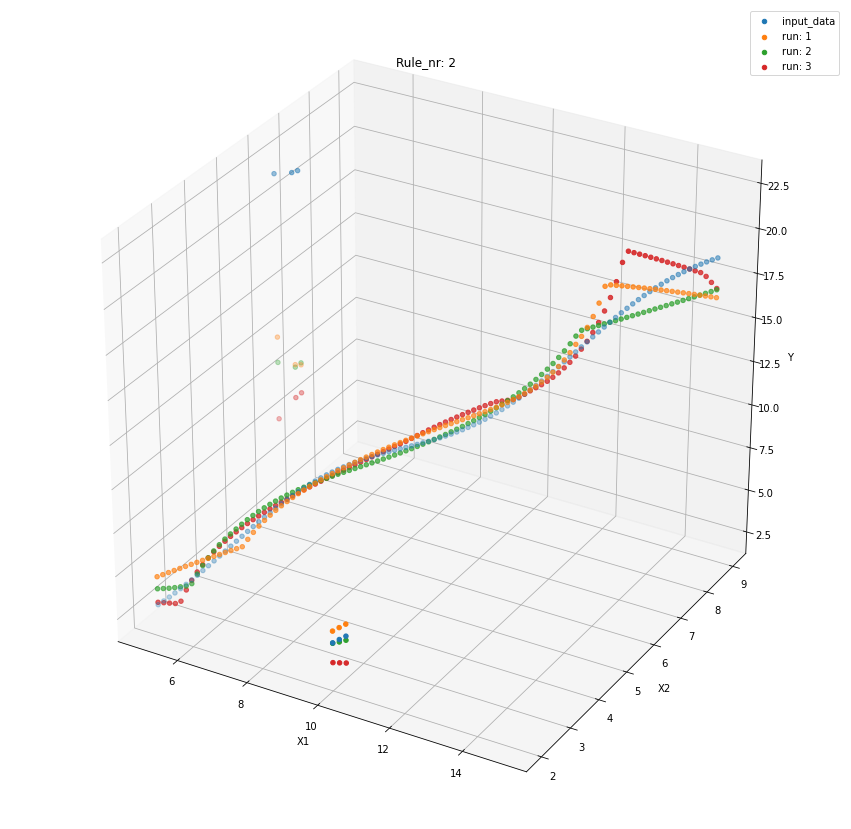

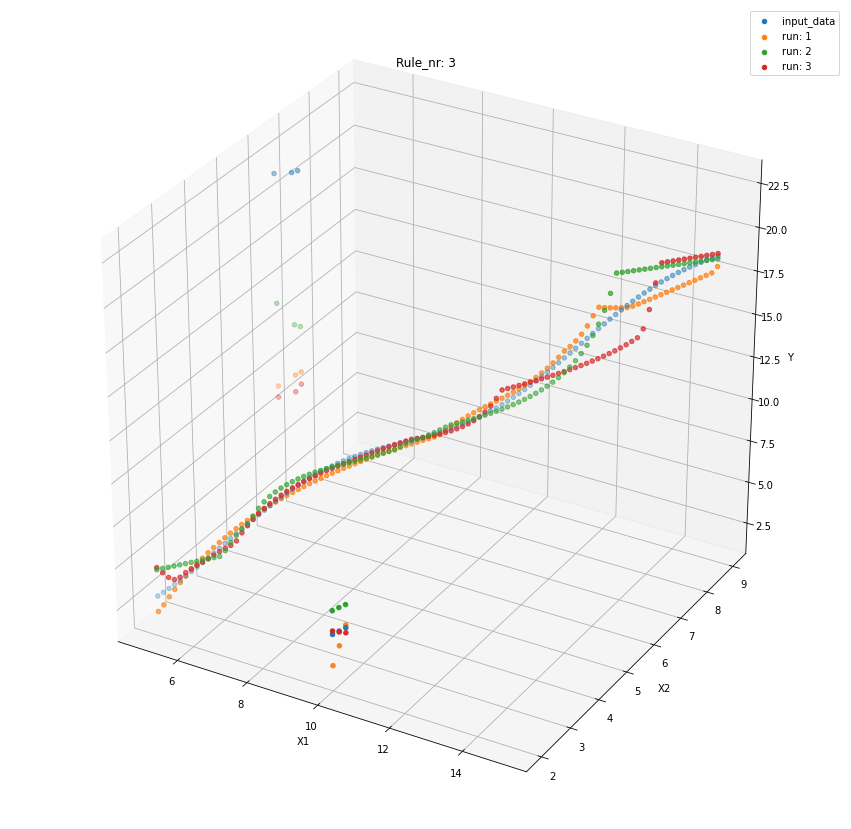

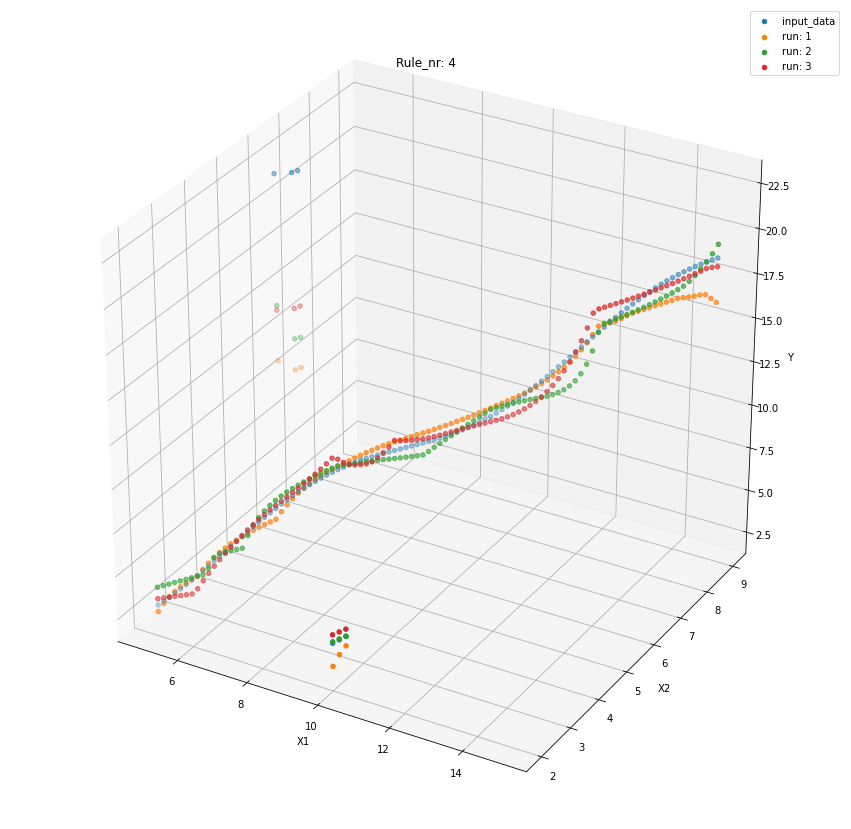

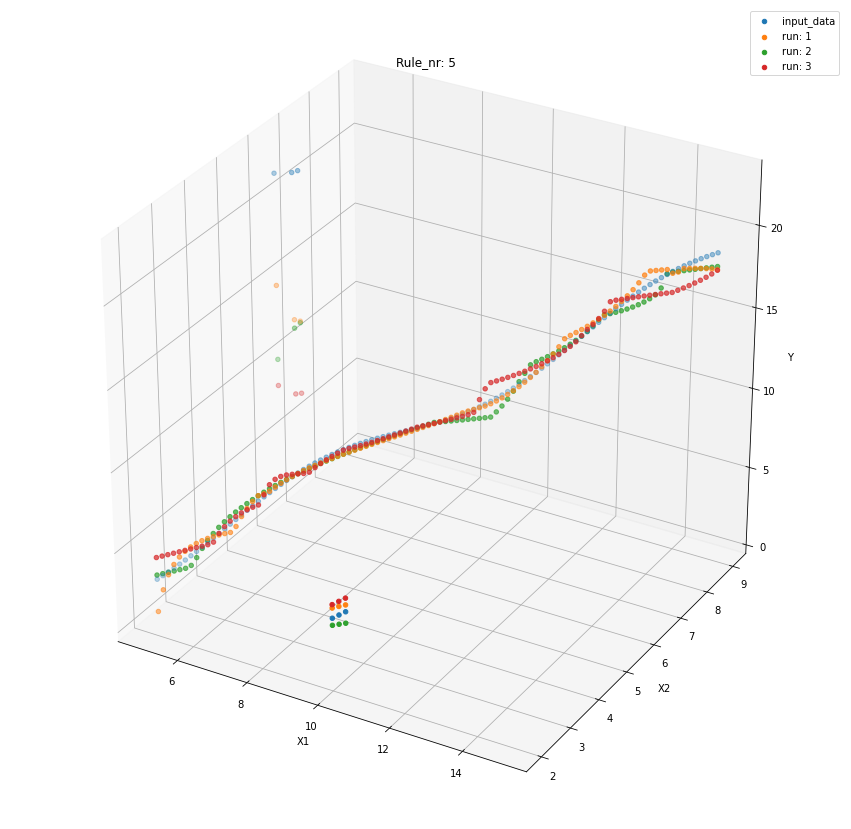

In [ ]:

plot_FAPPs(FuzzyRuleBase, X1s, X2s, inp)

Text(0.5, 0, 'Y')

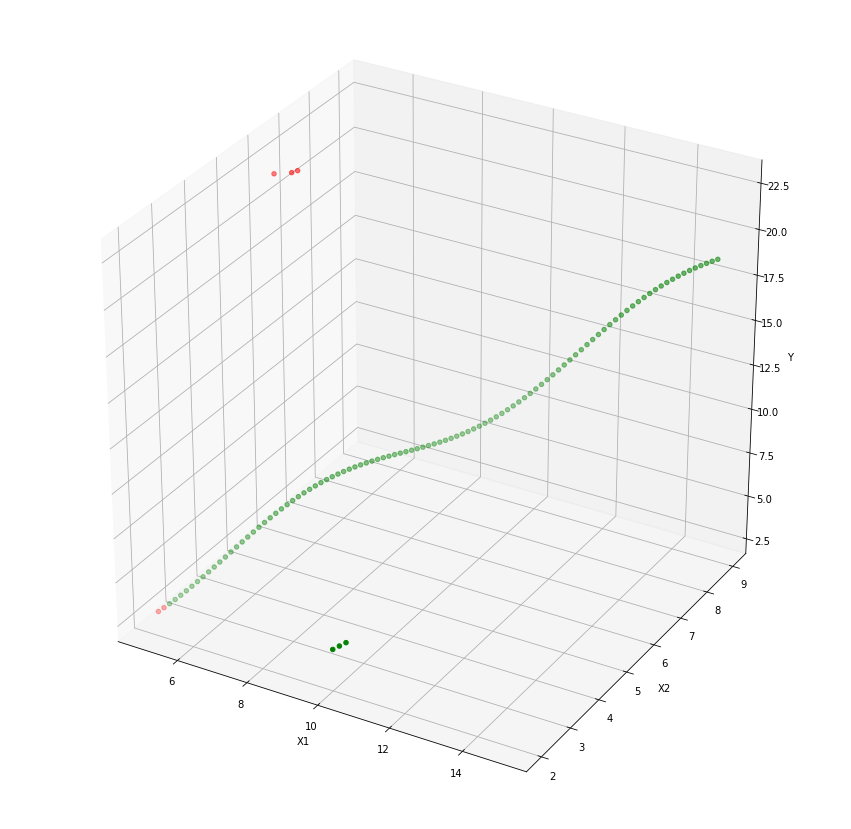

In [ ]:
outlierList = create_outlier_list(Ys=mamdaniInference(FuzzyRuleBase[4][1], inp=inp), Ds=inp.desired_outputs, theta=THETA) 

fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

# Ys = mamdaniInference(frbs = FuzzyRuleBase[4][1], inp=inp)

colors = np.array(list(map(lambda el: 'red' if el==True else 'green', ol)))

ax.scatter(X1s, X2s, desired_outputs, c=colors)
# ax.scatter(X1s, X2s, Ys  )
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

(5.0, 2.0)


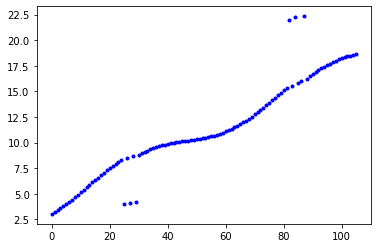

In [ ]:
import matplotlib.pyplot as plt

X1s = np.linspace(5, 15, 100)
X2s = np.linspace(2, 9, 100)


def f(x1, x2):
  return np.sin(x1) + 2*x2


desired_outputs = f(X1s, X2s)
desired_outputs = np.insert(desired_outputs, [25,26,27,79,80,82], [4,4.1,4.2,22,22.3, 22.34]) 
X1s = np.insert(X1s, [25,26,27,79,80,82], [10, 10.1, 10.2, 5,5.5, 5.59]) 
X2s = np.insert(X2s, [25,26,27,79,80,82], [2,2.1,2.2, 6,6.01,6.1]) 

plt.plot(desired_outputs, '.b')

observations = list(zip(X1s, X2s))
print(observations[0])

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

inp2 = Input()
inp2.n_gen = 100
inp2.n_ind = 30
inp2.n_clone = 10
inp2.n_inf = 10
inp2.boundaries = np.array(boundaries)
inp2.observations = np.array(observations)
inp2.observation_dim = inp2.observations.shape[1]
inp2.desired_outputs = np.array(desired_outputs)
inp2.nr_rules = 2
inp2.THETA = 0.1

best_indiv = bacterialEvoulution(inp2)

# Supervised Learning (in/outlier) - Test

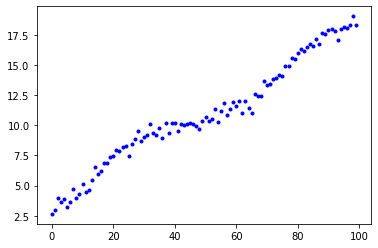

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

X1s = np.linspace(5, 15, 100)
X2s = np.linspace(2, 9, 100)


def f(x1, x2):
  return np.sin(x1) + 2*x2


desired_outputs = f(X1s, X2s) + rnd.normal(0,0.4, 100)
# desired_outputs = np.insert(desired_outputs, [25,26,27,79,80,82], [4,4.1,4.2,22,22.3, 22.34]) 
# X1s = np.insert(X1s, [25,26,27,79,80,82], [10, 10.1, 10.2, 5,5.5, 5.59]) 
# X2s = np.insert(X2s, [25,26,27,79,80,82], [2,2.1,2.2, 6,6.01,6.1]) 

plt.plot(desired_outputs, '.b')

observations = list(zip(X1s, X2s))

Text(0.5, 0, 'Y')

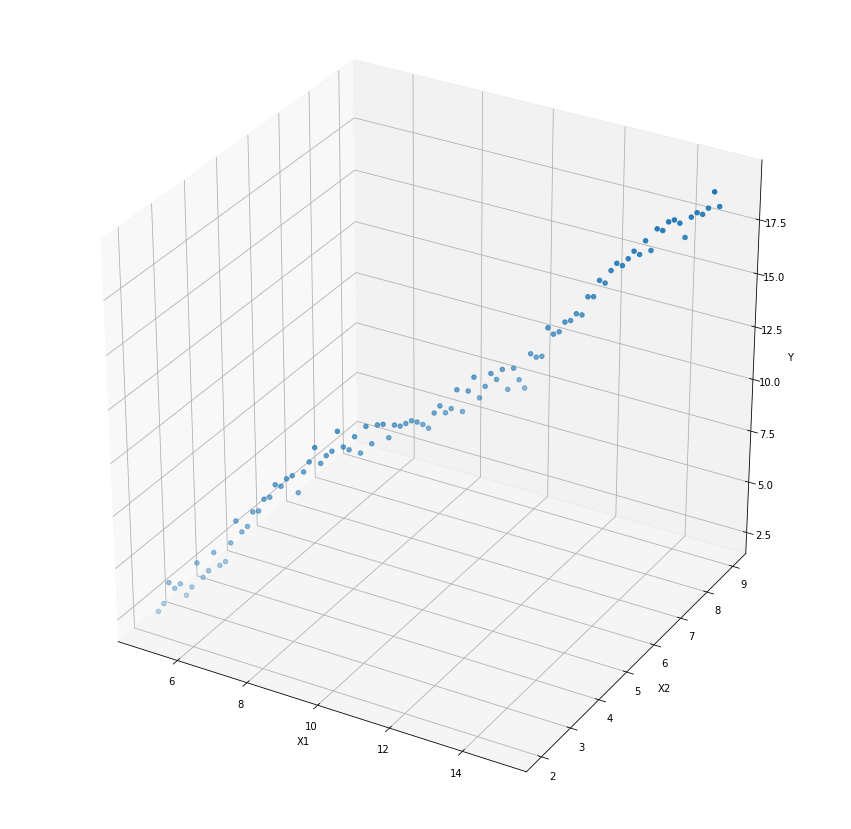

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

# Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs)
# ax.scatter(X1s, X2s, Ys)
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

inp2 = Input()
inp2.n_gen = 50
inp2.n_ind = 15
inp2.n_clone = 10
inp2.n_inf = 10
inp2.boundaries = np.array(boundaries)
inp2.observations = np.array(observations)
inp2.observation_dim = inp2.observations.shape[1]
inp2.desired_outputs = np.array(desired_outputs)
inp2.nr_rules = 8

# best_indiv = bacterialEvoulution(inp2)

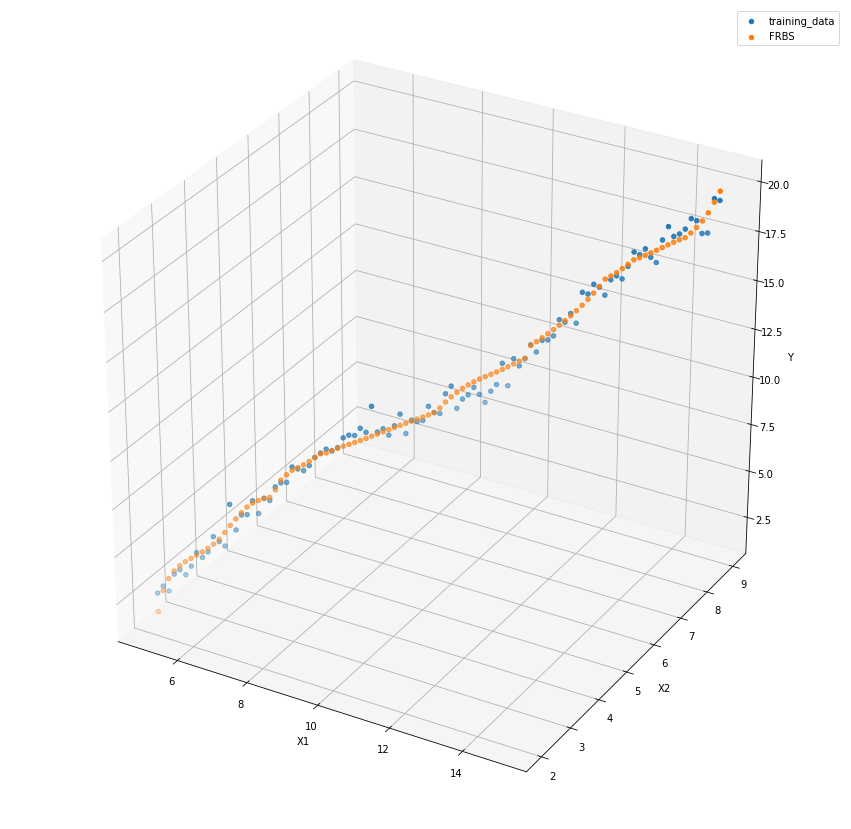

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

Ys = mamdaniInference(frbs = best_indiv, inp=inp2)

ax.scatter(X1s, X2s, desired_outputs, label='training_data')
ax.scatter(X1s, X2s, Ys, label='FRBS')
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.legend()

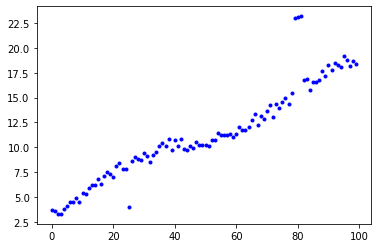

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

X1s = np.linspace(5, 15, 100)
X2s = np.linspace(2, 9, 100)

test_data = f(X1s, X2s) + rnd.normal(0,0.4, 100)
test_data[25] = 4
test_data[79] = 23
test_data[80] = 23.1
test_data[81] = 23.18
# test_data = np.insert(desired_outputs, [25,26,27,79,80,82], [4,4.1,4.2,22,22.3, 22.34])
# X1s = np.insert(X1s, [25,26,27,79,80,82], [10, 10.1, 10.2, 5,5.5, 5.59])
# X2s = np.insert(X2s, [25,26,27,79,80,82], [2,2.1,2.2, 6,6.01,6.1])

plt.plot(test_data, '.b')

observations = list(zip(X1s, X2s))

y: [10.62755375]


Text(0.5, 0, 'Y')

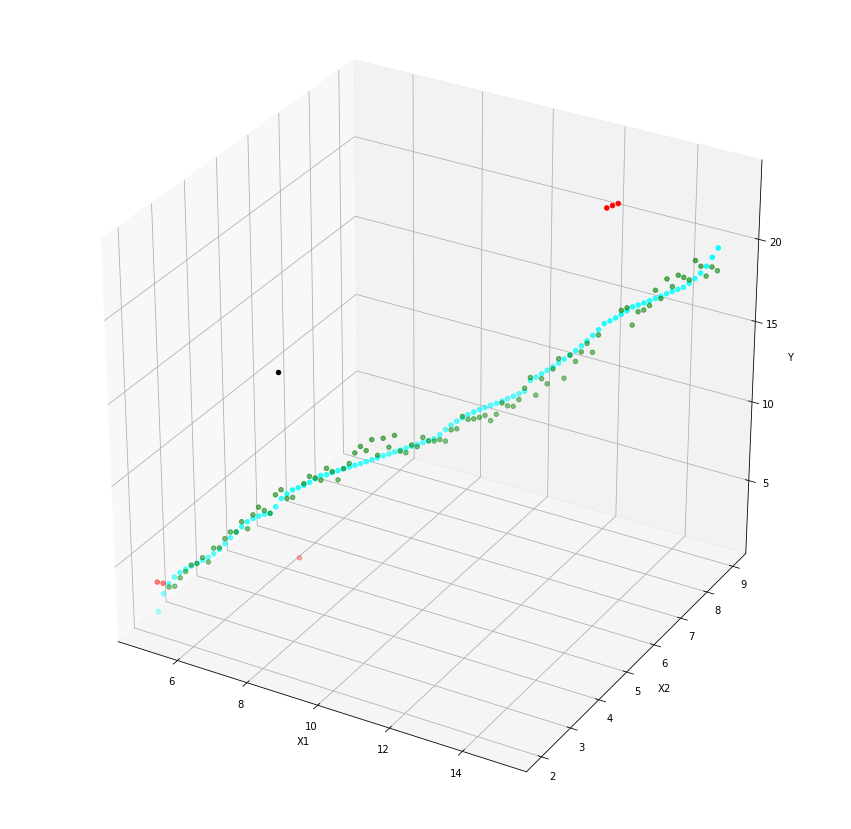

In [ ]:

fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

# inp2.desired_outputs = test_data
inp3 = copy.deepcopy(inp2)
inp3.desired_outputs = test_data
Ys = mamdaniInference(frbs = best_indiv, inp=inp3)

THETA=0.1
ol = create_outlier_list(Ys=test_data, Ds=Ys, theta=THETA)[0]

colors = np.array(list(map(lambda el: 'red' if el==True else 'green', ol)))

ax.scatter(X1s, X2s, test_data, color=colors)
ax.scatter(X1s, X2s, Ys, color='cyan')

# arbitrary point
inp3 = copy.deepcopy(inp2)
x1 = 5
x2 = 6
des_out = 10
inp3.observations = np.array([[x1,x2]])
inp3.desired_outputs = np.array([des_out])
y = mamdaniInference(frbs = best_indiv, inp=inp3)
print('y:', y)
ax.scatter(x1,x2,y,color='magenta' if create_outlier_list(Ys=np.array([des_out]), Ds=y, theta=THETA)[0] else 'black')
# ax.view_init(10, 25)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

In [ ]:
import plotly.graph_objects as go
import numpy as np
import plotly.express as px
import pandas as pd

df = pd.DataFrame(dict(x1=X1s, x2=X2s, y=test_data))
df2 = pd.DataFrame(dict(x1=X1s, x2=X2s, y=Ys))

in_outlier = np.array(list(map(lambda el: 'outlier' if el=='red' else 'inlier', colors)))

fig = px.scatter_3d(df, x='x1', y='x2', z='y', color=in_outlier)
fig.add_scatter3d(x=df2['x1'], y=df2['x2'], z=df2['y'], name='FAPP')

df3 = pd.DataFrame(dict(x1=X1s, x2=X2s, y=f(X1s,X2s)))
fig.add_scatter3d(x=df3['x1'], y=df3['x2'], z=df3['y'], name='ground_truth')
fig.update_traces(marker_size = 2)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),scene=dict(aspectmode='cube')) #data
fig.show()

# Levenberg–Marquardt

In [ ]:
inp1 = Input()
inp1.n_gen = 10
inp1.n_ind= 2
inp1.n_clone= 3
inp1.n_inf= 10
inp1.boundaries = np.array([[0,9],[1,10],[2,8]])
inp1.observations= np.array([[2,6], [3,5.5], [2.2,5.3]])
inp1.observation_dim = inp1.observations.shape[1]
inp1.desired_outputs= np.array([2.5, 3, 4])
inp1.nr_rules= 2
inp1.lm_prob = 1
inp1.lm_iter = 25
inp1.gamma_init = 7

test_frbs = bacterialEvoulution(inp1)

100%|██████████| 10/10 [00:00<00:00, 45.09it/s]

best-err:  2.068814584630943
best-err:  2.0370829455188115
best-err:  2.0370829455188115
best-err:  2.0370829455188115
best-err:  1.087817711035644
best-err:  1.0443505729839946
best-err:  1.0305951806565121
best-err:  1.0305951806565121
best-err:  1.0305951806565121
best-err:  1.0305951806565121


100%|██████████| 10/10 [00:00<00:00, 44.68it/s]


In [ ]:
print(error(Ys=mamdaniInference(test_frbs, inp1.observations), Ds=inp1.desired_outputs))

1.064785729877062


In [ ]:
frbs = np.array( [
        [ [4, 6, 7, 8], [2, 6, 8, 9], [1, 7, 7, 9], [4, 4, 5, 8] ],
        [ [3, 6, 8, 10], [2, 7, 8, 10], [1, 8, 8, 10], [1, 4, 6, 10] ]
])

observations = []
observations.append([5,7.2,6])
observations.append([6,9,3.8])
observations.append([7,8,7.6])
observations = np.array(observations)
desired_outputs = np.array([3,5,7])
boundaries = [[3,9], [1,10], [-1, 9], [4,8]]

In [ ]:
frbs.shape

(2, 4, 4)

In [ ]:
test_frbs.shape

(2, 3, 4)

### Jacobian matrix

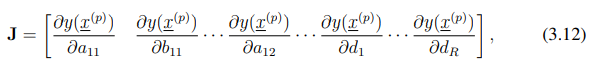

In [ ]:
def N_ij(start, end, x):
  # WARN: include/exclude boundaries
  return 1 if x >= start and x <= end else 0

In [ ]:
from numpy.core.fromnumeric import shape
def JacobianMtx(bact, X):
  '''
  Jacobi matrix

  Parameters:
  --------
    param: b - frbs
    param: X - observations
  '''
  nr_rules, nr_trapmf, _ = bact.shape 
  R = nr_rules
  n = nr_trapmf-1 # nr of antecedents / dim. of the observation
  J = np.empty((len(X), 4*(n+1)*R))
  J_row, J_col = 0, 0
  F = []
  G = []
  N, S = 0, 0

  for x_p in X:
    # -- getting F,G,N,S -- #
    for r_idx, rule in enumerate(bact):
      # w - is w_min
      w = w_min(rule, np.array([x_p]))[0]

      #a,b,c,d of the consequent
      a, b, c, d = rule[-1][0], rule[-1][1], rule[-1][2], rule[-1][3]

      _numerator = 3*w * (d**2 - a**2) * (1-w) + 3 * w**2 * (c*d - a*b) + w**3 * (c-d+a-b)*(c-d-a+b)
      _denominator = 2*w * (d-a) + w**2 * (c + a - d - b)

      N += _numerator
      S += _denominator
    # -- F,G,N,S -- #

  for x_p in X:
    for i, rule in enumerate(bact):
      # w - is w_min
      W = w_min(rule, np.array([x_p]))

      # CONSEQUENT's attributes
      A, B, C, D = rule[-1][0], rule[-1][1], rule[-1][2], rule[-1][3]

      dF_dW = 3*(D**2-A**2)*(1-2*W) + 6*W*(C*D-A*B) + 3*W**2*((C-D)**2 - (A-B)**2)
      dG_dW = 2**(D-A) + 2*w*(C+A-D-B)

      if N == 0:
        dy_dW = 0
      else:          
        dy_dW = (1/3) * (N*dF_dW - S*dG_dW) / N**2

      '''Antecedents'''
      for j in range(n): # iterate through the ANTECEDENTS
        trap = rule[j]
        a,b,c,d = trap[0], trap[1], trap[2], trap[3]
        x = x_p[j]

        dmu_da = (x-b) / (b-a)**2 * N_ij(a,b,x)
        dmu_db = (a-x) / (b-a)**2 * N_ij(a,b,x)
        dmu_dc = (d-x) / (d-c)**2 * N_ij(c,d,x)
        dmu_dd = (x-c) / (d-c)**2 * N_ij(c,d,x)
      
        dW_dmu = 1 if trapmf(np.array([x]), abcd=trap) == w else 0

        dy_da = dy_dW*dW_dmu*dmu_da
        dy_db = dy_dW*dW_dmu*dmu_db
        dy_dc = dy_dW*dW_dmu*dmu_dc
        dy_dd = dy_dW*dW_dmu*dmu_dd

        J[J_row][J_col] = dy_da
        J_col = J_col+1
        J[J_row][J_col] = dy_db
        J_col = J_col+1
        J[J_row][J_col] = dy_dc
        J_col = J_col+1
        J[J_row][J_col] = dy_dd
        J_col = J_col+1

      '''Consequent'''
      dt_F_A = -6*W*A + 6*W**2*A - 3*W**2*B - 2*W**3*(A-B)
      dt_F_B = -3*W**2*A + 2*W**3*(A-B)
      dt_F_C = 3*W**2*D - 2*W**3*(D-C)
      dt_F_D = 6*W*D - 6*W**2*D + 3*W**2*C + 2*W**3*(D-C)

      dt_G_A = -2*W + W**2
      dt_G_B = -W**2
      dt_G_C = W**2
      dt_G_D = 2*W - W**2

      if N == 0:
        dy_dA=0
        dy_dB=0
        dy_dC=0
        dy_dD=0
      else:
        dy_dA = (1/3) * (N*dt_F_A - S*dt_G_A) / N**2
        dy_dB = (1/3) * (N*dt_F_B - S*dt_G_B) / N**2
        dy_dC = (1/3) * (N*dt_F_C - S*dt_G_C) / N**2
        dy_dD = (1/3) * (N*dt_F_D - S*dt_G_D) / N**2

      J[J_row][J_col] = dy_dA
      J_col = J_col+1
      J[J_row][J_col] = dy_dB
      J_col = J_col+1
      J[J_row][J_col] = dy_dC
      J_col = J_col+1
      J[J_row][J_col] = dy_dD
      J_col = J_col+1

    J_row = J_row+1
    J_col = 0
  return J


In [ ]:
# J = JacobianMtx(bact=frbs, X=observations)
# print(J.shape)
# print(J)
J2 = JacobianMtx(bact=test_frbs, X=observations)
print(J2.shape)
print(J2)


(3, 24)
[[ 0. -0.  0.  0. -0.  0.  0. -0.  0.  0.  0.  0.  0. -0. -0.  0.  0. -0.
  -0.  0.  0.  0.  0.  0.]
 [ 0. -0.  0.  0. -0.  0.  0. -0.  0.  0.  0.  0.  0. -0. -0.  0.  0. -0.
  -0.  0.  0.  0.  0.  0.]
 [ 0. -0.  0.  0. -0.  0.  0. -0.  0.  0.  0.  0.  0. -0. -0.  0.  0. -0.
  -0.  0.  0.  0.  0.  0.]]


In [ ]:
a = np.array([[1,0],[0,1]])
b = np.array([[4,5],[3,2]])
print(a, '\n\n' , b,'\n\n', a*b, '\n\n',  np.matmul(a,b))


[[1 0]
 [0 1]] 

 [[4 5]
 [3 2]] 

 [[4 0]
 [0 2]] 

 [[4 5]
 [3 2]]


In [ ]:
J = JacobianMtx(bact=frbs, X=observations)
A = np.matmul(J.T, J)
print(A.shape)

(32, 32)


### L-M

#### Update vector

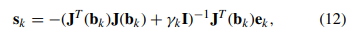

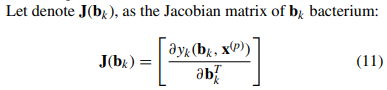

In [ ]:
def update_vector(b, X, e, γ):
  '''
    Returns: update vector - s

    Parameters:
    -------
    param b: bacterium
    param X: observations
    param e: errors (vector) - piecewise
    param γ: bravery factor
  '''
  # print('JacobianMtx')
  J = JacobianMtx(bact=b, X=X)
  # print(J)
  r,c = J.shape
  I = np.eye(c)
  # print('mamdaniInference')
  Ys = mamdaniInference(frbs=b, observations=X)
  # print('return')
  return -inv((J.T @ J + γ*I)) @ J.T @ e

In [ ]:
# e = error_piecewise(Ys=mamdaniInference(frbs=test_frbs, observations=inp1.observations), Ds=inp1.desired_outputs) 
# s = update_vector(b=test_frbs, X=observations, e=e, γ=2)
# print(s, s.shape)

#### Trust region

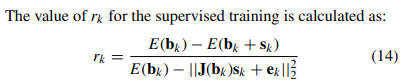

In [ ]:
def trust_region(b, X, Ds, s, e):
  '''
    Returns: trust region - r

    Parameters:
    ---------
    param b: bacterium-frbs
    param s: update vector

  '''
  E_b = error(Ys=mamdaniInference(frbs=b, observations=X), Ds=Ds)
  E_bs = error(Ys=mamdaniInference(frbs=b+s.reshape(b.shape), observations=X), Ds=Ds)
  s.ravel()
  return (E_b - E_bs) / (E_b - linalg.norm(JacobianMtx(bact=b, X=X) @ s + e))

In [ ]:
# print(trust_region(b=frbs, X=observations, Ds=desired_outputs, s=s, e=e))

NameError: ignored

#### Bravery factor

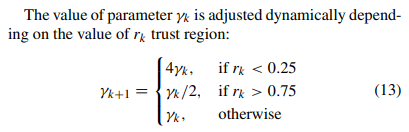

In [ ]:
def bravery_factor(gamma, r):
  # bravery_factor
  # gamma
  if r < 0.25:
    return 4*gamma
  elif r > 0.75:
    return gamma/2
  else:
    return gamma

#### Evaluation

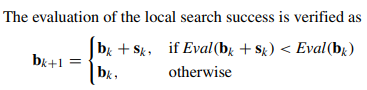

In [ ]:
def evaluation(b, s, X, Ds):
  s = s.reshape(b.shape)
  Ys_bs = mamdaniInference(frbs=b+s, observations=X)
  Ys_b = mamdaniInference(frbs=b, observations=X)
  # print(error(Ys=Ys_bs, Ds=Ds), error(Ys=Ys_b, Ds=Ds))
  if error(Ys=Ys_bs, Ds=Ds) < error(Ys=Ys_b, Ds=Ds):
    return b+s
  else:
    return b

#### Stopping criteria

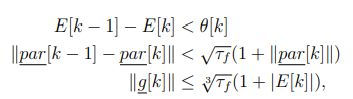

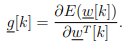

In [ ]:
def gradient_vector(J, e):
  r, c = J.shape
  gradVect = np.zeros(c)
  for j in range(c):
    gradVect[j] = 0
    for k in  range(r):
      gradVect[j] += 2*e[k]*J[k][j]
  return gradVect

In [ ]:
J=JacobianMtx(bact=test_frbs, X=inp1.observations)
# print(J.shape)
gradVect = gradient_vector(J=J,e=error_piecewise(Ys=mamdaniInference(frbs=test_frbs, observations=inp1.observations), Ds=inp1.desired_outputs))
print(norm(gradVect))

In [ ]:
def stopping_crit_reached(k, E_old, E_new, s, b, J, e, inp:Input):
  # at least 2 steps are required in order to stop
  if k <= 1:
    return False
  τ = 0.0001
  g = gradient_vector(J, e)
  # print(f'1st:{E_old - E_new < τ * (1+E_new)}')
  # print(f'2st:{norm(s) < np.sqrt(τ)*(1+norm(b))}')
  # print(f'3st:{norm(g) <= np.cbrt(τ)*(1+abs(E_new))}')
  if E_old - E_new < τ * (1+E_new) and \
      norm(s) < np.sqrt(τ)*(1+norm(b)) and \
      norm(g) <= np.cbrt(τ)*(1+abs(E_new)):
    return True
  return False

#### Main L-M

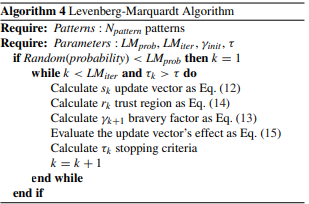

In [ ]:
def LevenbergMarquardt(b, inp:Input):
  # print(f'start-Error: {error(Ys=mamdaniInference(frbs=b, observations=inp.observations), Ds=inp.desired_outputs)}')
  if rnd.rand() < inp.lm_prob:
    k=0
    E_old, E_new = 0, 0
    gamma = inp.gamma_init
    s, J, e = None,None,None
    while k < inp.lm_iter and not stopping_crit_reached(k=k, E_old=E_old, E_new=E_new, s=s, b=b, J=J, e=e, inp=inp):
      # print('k=',k)
      e = error_piecewise(Ys=mamdaniInference(frbs=b, observations=inp.observations), Ds=inp.desired_outputs)
      E_old = E_new
      E_new = error(Ys=mamdaniInference(frbs=b, observations=inp.observations), Ds=inp.desired_outputs)
      # print('update_vector')
      s = update_vector(b=b, X=inp.observations, e=e, γ=gamma)
      # print('trust_region')
      r = trust_region(b=b, X=inp.observations, Ds=inp.desired_outputs, s=s, e=e)
      # print("bravery")
      gamma = bravery_factor(gamma, r)
      # print('evolution')
      
      b = evaluation(b=b,s=s,X=inp.observations,Ds=inp.desired_outputs)
      # for the next stopping_crit
      J = JacobianMtx(bact=b, X=inp1.observations)
      e = error_piecewise(Ys=mamdaniInference(frbs=b, observations=inp.observations), Ds=inp.desired_outputs)
      # print('next_iter')
      
      k = k+1
  # print(f'end-Error: {error(Ys=mamdaniInference(frbs=b, observations=inp.observations), Ds=inp.desired_outputs)}')
  return b

## Test L-M

In [ ]:
best_frbs = LevenbergMarquardt(b=test_frbs, inp=inp1)

start-Error: 1.0305951806565121
end-Error: 1.0305951806565121


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


In [ ]:
print(__err__(test_frbs, inp1))
print(__err__(best_frbs, inp1))

0.9657076900855394
0.6375695909832668


# Bacterial Memetic Algorithm

### Bacterial Memetic Evolution

In [ ]:
def LevenbergMarquardtOnPopulation(population, inp):
  for indiv_idx in range(len(population)):
    population[indiv_idx] = LevenbergMarquardt(b=population[indiv_idx], inp=inp)


In [ ]:
def bacterialMemeticEvoulution(inp:Input) -> np.ndarray:
  population = [create_fuzzyRBS(inp) for _ in range(inp.n_ind)]
  clones = [create_fuzzyRBS(inp) for _ in range(inp.n_clone)]

  for ep in trange(inp.n_gen):
    bacterialMutation(population, clones, inp)
    LevenbergMarquardtOnPopulation(population, inp)
    bacterialGeneTransfer(population, inp)
    population.sort(key=lambda indiv: __err__(indiv, inp))
    print('best-err: ', __err__(min(population, key=lambda indiv: __err__(indiv, inp)), inp))
  return population[0]

## Test

### Test1

In [ ]:
inp1 = Input()
inp1.n_gen = 10
inp1.n_ind= 2
inp1.n_clone= 3
inp1.n_inf= 10
inp1.boundaries = np.array([[0,9],[1,10],[2,8]])
inp1.observations= np.array([[2,6], [3,5.5], [2.2,5.3]])
inp1.observation_dim = inp1.observations.shape[1]
inp1.desired_outputs= np.array([2.5, 3, 4])
inp1.nr_rules= 2
inp1.lm_prob = 1
inp1.lm_iter = 25
inp1.gamma_init = 0.5

test_frbs = bacterialMemeticEvoulution(inp1)

100%|██████████| 10/10 [00:00<00:00, 45.28it/s]

best-err:  1.2759785290551309
best-err:  1.2759785290551309
best-err:  1.2759785290551309
best-err:  1.2759785290551309
best-err:  1.2759785290551309
best-err:  1.2759785290551309
best-err:  1.2759785290551309
best-err:  1.2759785290551309
best-err:  1.251749987389276
best-err:  1.251749987389276


### TEST: BEA (L-M applied at the end)

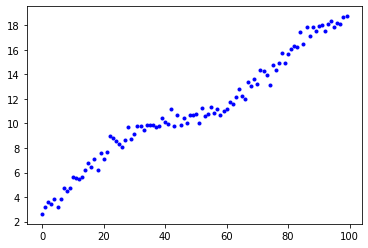

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

X1s = np.linspace(5, 15, 100)
X2s = np.linspace(2, 9, 100)


def f(x1, x2):
  return np.sin(x1) + 2*x2


desired_outputs = f(X1s, X2s) + rnd.normal(0,0.4, 100)
# desired_outputs = np.insert(desired_outputs, [25,26,27,79,80,82], [4,4.1,4.2,22,22.3, 22.34]) 
# X1s = np.insert(X1s, [25,26,27,79,80,82], [10, 10.1, 10.2, 5,5.5, 5.59]) 
# X2s = np.insert(X2s, [25,26,27,79,80,82], [2,2.1,2.2, 6,6.01,6.1]) 

plt.plot(desired_outputs, '.b')

observations = list(zip(X1s, X2s))

Text(0.5, 0, 'Y')

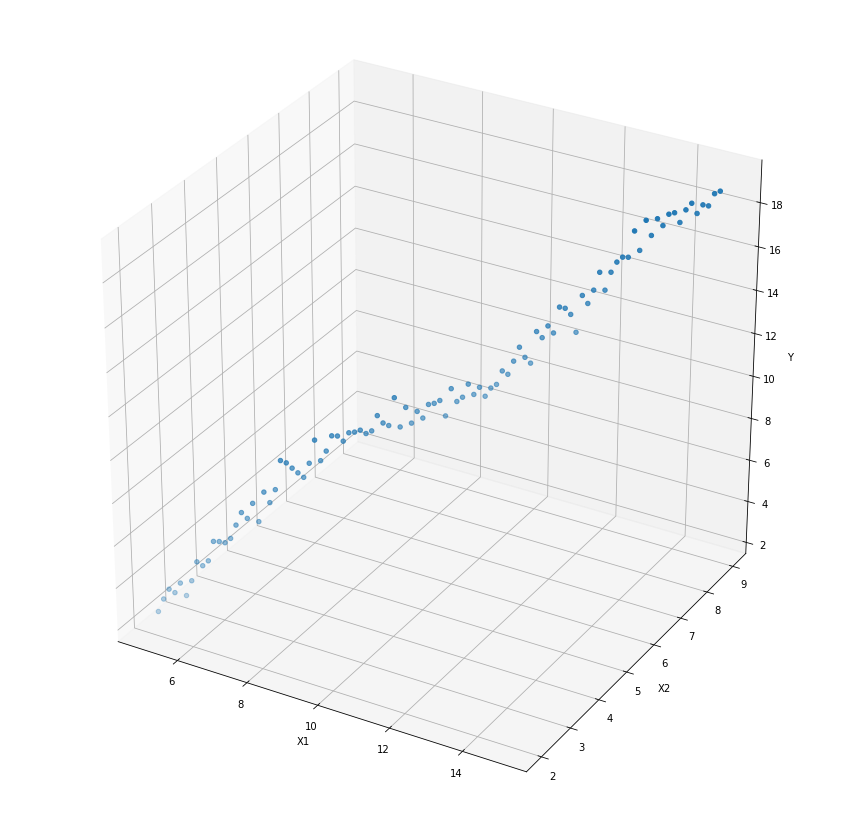

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

# Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs)
# ax.scatter(X1s, X2s, Ys)
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

inp2 = Input()
inp2.n_gen = 5
inp2.n_ind = 15
inp2.n_clone = 10
inp2.n_inf = 10
inp2.boundaries = np.array(boundaries)
inp2.observations = np.array(observations)
inp2.observation_dim = inp2.observations.shape[1]
inp2.desired_outputs = np.array(desired_outputs)
inp2.nr_rules = 8
# inp2.nr_rules= 2
inp2.lm_prob = 1
inp2.lm_iter = 25
inp2.gamma_init = 0.5

In [ ]:
best_indiv = bacterialMemeticEvoulution(inp2)

 20%|██        | 1/5 [00:05<00:21,  5.38s/it]

best-err:  14.227838546441467


 40%|████      | 2/5 [00:10<00:15,  5.18s/it]

best-err:  12.954156570805797


 60%|██████    | 3/5 [00:14<00:09,  4.86s/it]

best-err:  12.715924787842875


 80%|████████  | 4/5 [00:18<00:04,  4.56s/it]

best-err:  7.554260655609868


100%|██████████| 5/5 [00:23<00:00,  4.74s/it]

best-err:  7.554260655609868


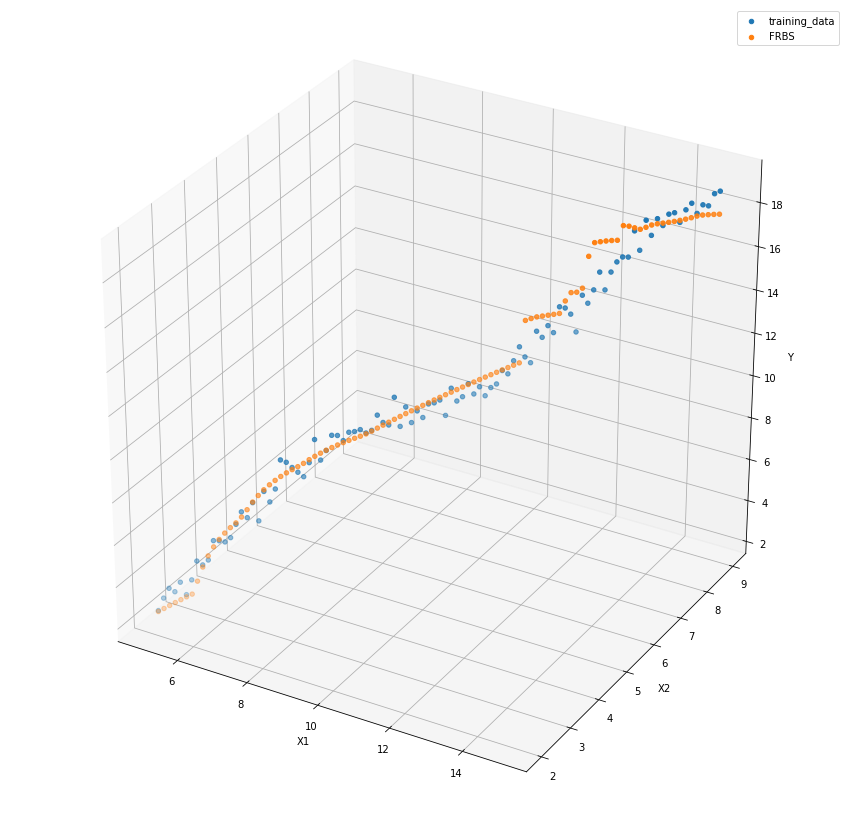

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs, label='training_data')
ax.scatter(X1s, X2s, Ys, label='FRBS')
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.legend()

#### LM

Applying LM

start-Error: 7.554260655609868
end-Error: 5.58676937868544


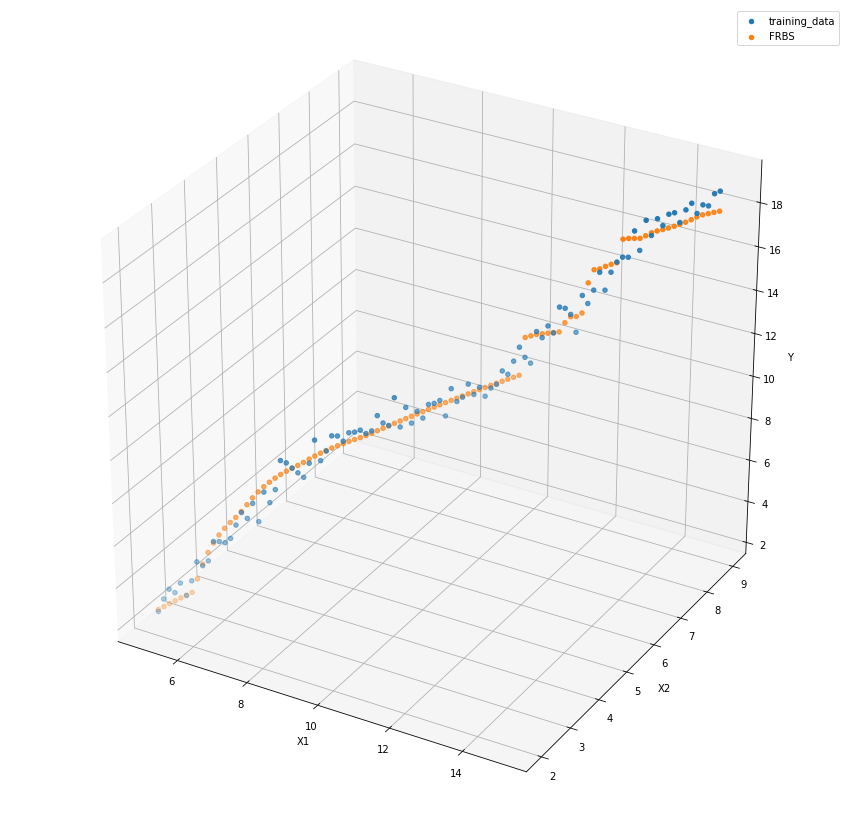

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')


best_indiv = LevenbergMarquardt(best_indiv, inp=inp2)
Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs, label='training_data')
ax.scatter(X1s, X2s, Ys, label='FRBS')
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.legend()

LM - applied again

start-Error: 5.58676937868544
end-Error: 5.586360393732833


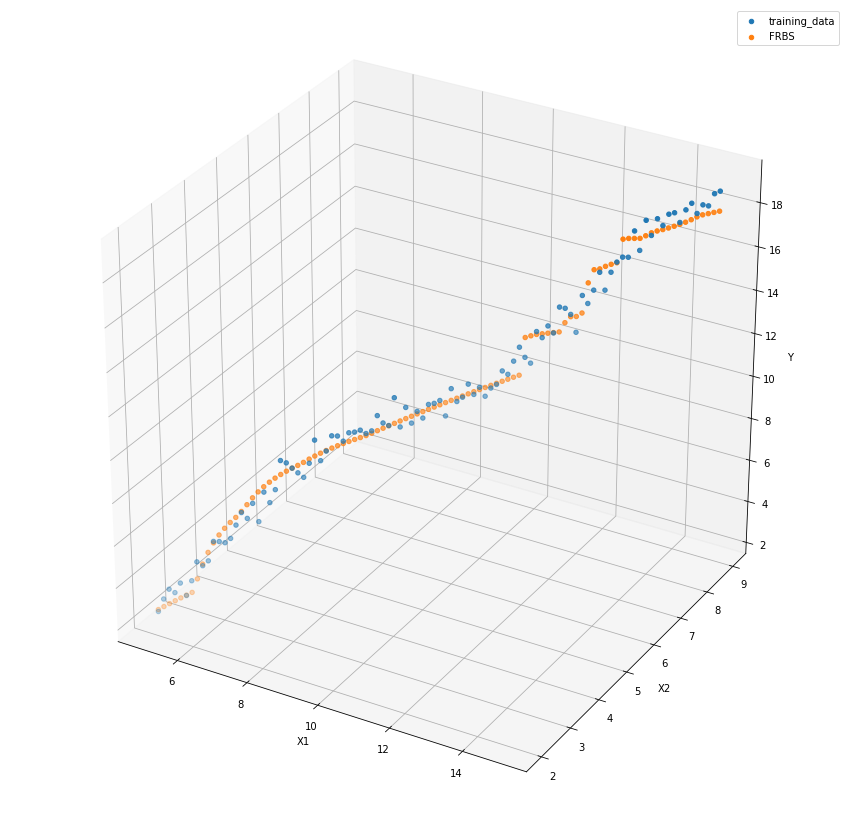

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')


best_indiv = LevenbergMarquardt(best_indiv, inp=inp2)
Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs, label='training_data')
ax.scatter(X1s, X2s, Ys, label='FRBS')
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.legend()

### TEST: (in plane) BMA

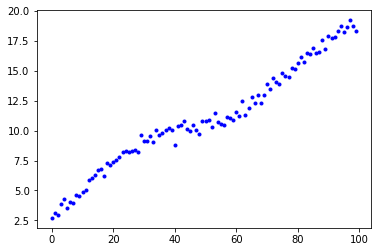

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

X1s = np.linspace(5, 15, 100)
X2s = np.linspace(2, 9, 100)


def f(x1, x2):
  return np.sin(x1) + 2*x2


desired_outputs = f(X1s, X2s) + rnd.normal(0,0.4, 100)
# desired_outputs = np.insert(desired_outputs, [25,26,27,79,80,82], [4,4.1,4.2,22,22.3, 22.34]) 
# X1s = np.insert(X1s, [25,26,27,79,80,82], [10, 10.1, 10.2, 5,5.5, 5.59]) 
# X2s = np.insert(X2s, [25,26,27,79,80,82], [2,2.1,2.2, 6,6.01,6.1]) 

plt.plot(desired_outputs, '.b')

observations = list(zip(X1s, X2s))

Text(0.5, 0, 'Y')

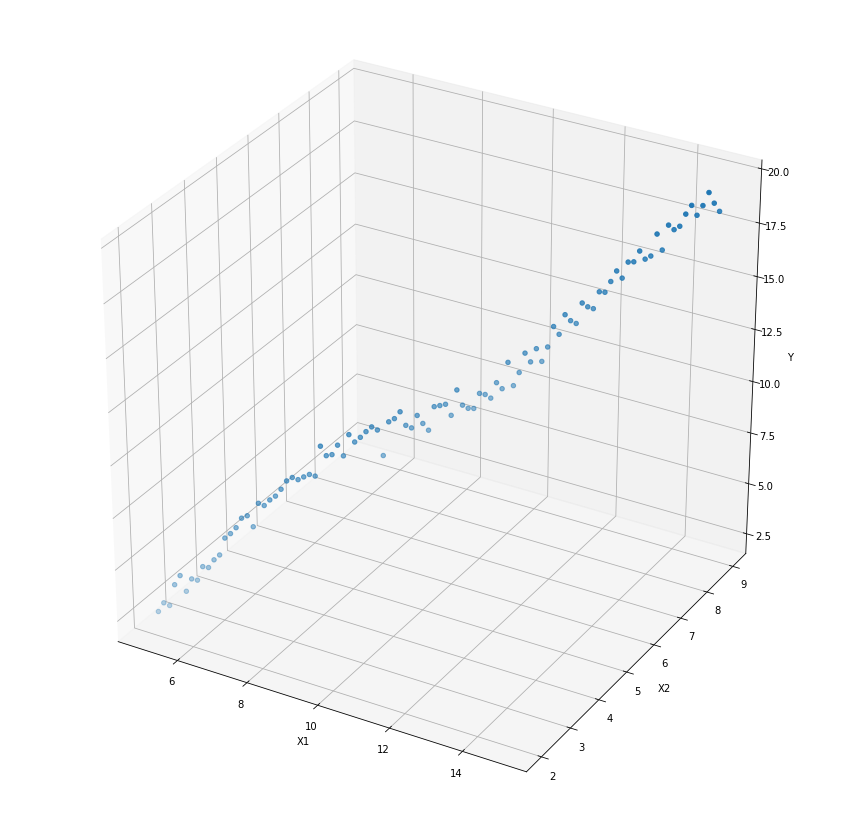

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

# Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs)
# ax.scatter(X1s, X2s, Ys)
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

inp2 = Input()
inp2.n_gen = 50
inp2.n_ind = 10
inp2.n_clone = 10
inp2.n_inf = 10
inp2.boundaries = np.array(boundaries)
inp2.observations = np.array(observations)
inp2.observation_dim = inp2.observations.shape[1]
inp2.desired_outputs = np.array(desired_outputs)
inp2.nr_rules = 12
# inp2.nr_rules= 2
inp2.lm_prob = 0.1
inp2.lm_iter = 25
inp2.gamma_init = 0.5

In [ ]:
best_indiv = bacterialMemeticEvoulution(inp2)

  2%|▏         | 1/50 [00:26<21:14, 26.00s/it]

best-err:  7.0332790079866


  4%|▍         | 2/50 [00:33<12:11, 15.24s/it]

best-err:  6.986406494608499


  6%|▌         | 3/50 [00:42<09:32, 12.18s/it]

best-err:  6.986406494608499


  8%|▊         | 4/50 [00:49<07:49, 10.21s/it]

best-err:  6.986406494608499


 10%|█         | 5/50 [01:18<12:51, 17.15s/it]

best-err:  5.8481868371346835


 12%|█▏        | 6/50 [01:59<18:27, 25.16s/it]

best-err:  5.8481868371346835


 14%|█▍        | 7/50 [02:28<18:52, 26.35s/it]

best-err:  5.712719834453542


 16%|█▌        | 8/50 [02:55<18:42, 26.72s/it]

best-err:  5.712719834453542


 18%|█▊        | 9/50 [03:20<17:44, 25.96s/it]

best-err:  5.712719834453542


 20%|██        | 10/50 [03:45<17:11, 25.79s/it]

best-err:  5.712719834453542


 22%|██▏       | 11/50 [03:55<13:36, 20.94s/it]

best-err:  5.712719834453542


 24%|██▍       | 12/50 [04:24<14:46, 23.32s/it]

best-err:  5.712719834453542


 26%|██▌       | 13/50 [04:47<14:17, 23.19s/it]

best-err:  5.712719834453542


 28%|██▊       | 14/50 [04:53<10:54, 18.19s/it]

best-err:  5.712719834453542


 30%|███       | 15/50 [05:12<10:39, 18.28s/it]

best-err:  5.712719834453542


 32%|███▏      | 16/50 [05:19<08:27, 14.92s/it]

best-err:  5.133349725016675


 34%|███▍      | 17/50 [05:25<06:39, 12.12s/it]

best-err:  5.133349725016675


 36%|███▌      | 18/50 [05:29<05:17,  9.92s/it]

best-err:  5.133349725016675


 38%|███▊      | 19/50 [05:35<04:31,  8.75s/it]

best-err:  5.133349725016675


 40%|████      | 20/50 [05:43<04:10,  8.36s/it]

best-err:  5.133349725016675


 42%|████▏     | 21/50 [06:11<06:52, 14.22s/it]

best-err:  4.880038011445115


 44%|████▍     | 22/50 [06:40<08:45, 18.77s/it]

best-err:  4.879550435288379


 46%|████▌     | 23/50 [06:45<06:31, 14.52s/it]

best-err:  4.879550435288379


 48%|████▊     | 24/50 [06:55<05:42, 13.16s/it]

best-err:  4.879550435288379


 50%|█████     | 25/50 [07:03<04:54, 11.77s/it]

best-err:  4.879550435288379


 52%|█████▏    | 26/50 [07:58<09:55, 24.79s/it]

best-err:  4.879550435288379


 54%|█████▍    | 27/50 [08:09<07:49, 20.42s/it]

best-err:  4.879550435288379


 56%|█████▌    | 28/50 [08:35<08:06, 22.13s/it]

best-err:  4.879550435288379


 58%|█████▊    | 29/50 [08:42<06:07, 17.52s/it]

best-err:  4.879550435288379


 60%|██████    | 30/50 [08:48<04:43, 14.18s/it]

best-err:  4.648695187386865


 62%|██████▏   | 31/50 [09:16<05:48, 18.34s/it]

best-err:  4.648695187386865


 64%|██████▍   | 32/50 [09:22<04:23, 14.66s/it]

best-err:  4.648695187386865


 66%|██████▌   | 33/50 [09:33<03:51, 13.63s/it]

best-err:  4.64730668181146


 68%|██████▊   | 34/50 [09:41<03:09, 11.83s/it]

best-err:  4.64730668181146


 70%|███████   | 35/50 [10:13<04:28, 17.87s/it]

best-err:  4.64730668181146


 72%|███████▏  | 36/50 [10:41<04:52, 20.88s/it]

best-err:  4.643617886130437


 74%|███████▍  | 37/50 [10:52<03:52, 17.87s/it]

best-err:  4.643617886130437


 76%|███████▌  | 38/50 [11:41<05:29, 27.44s/it]

best-err:  4.643617886130437


 78%|███████▊  | 39/50 [12:20<05:38, 30.80s/it]

best-err:  4.643617886130437


 80%|████████  | 40/50 [12:46<04:52, 29.26s/it]

best-err:  4.236948174417321


 82%|████████▏ | 41/50 [13:13<04:18, 28.72s/it]

best-err:  4.219165282806485


 84%|████████▍ | 42/50 [13:22<03:02, 22.87s/it]

best-err:  4.219165282806485


 86%|████████▌ | 43/50 [13:52<02:54, 24.99s/it]

best-err:  4.219117621285406


 88%|████████▊ | 44/50 [14:19<02:33, 25.57s/it]

best-err:  4.219117621285406


 90%|█████████ | 45/50 [14:47<02:10, 26.13s/it]

best-err:  4.219117621285406


 92%|█████████▏| 46/50 [14:56<01:24, 21.19s/it]

best-err:  4.219117621285406


 94%|█████████▍| 47/50 [15:02<00:49, 16.61s/it]

best-err:  4.219117621285406


 96%|█████████▌| 48/50 [15:29<00:39, 19.55s/it]

best-err:  4.219117621285406


 98%|█████████▊| 49/50 [15:55<00:21, 21.45s/it]

best-err:  4.219117621285406


100%|██████████| 50/50 [16:19<00:00, 19.59s/it]

best-err:  4.219117621285406


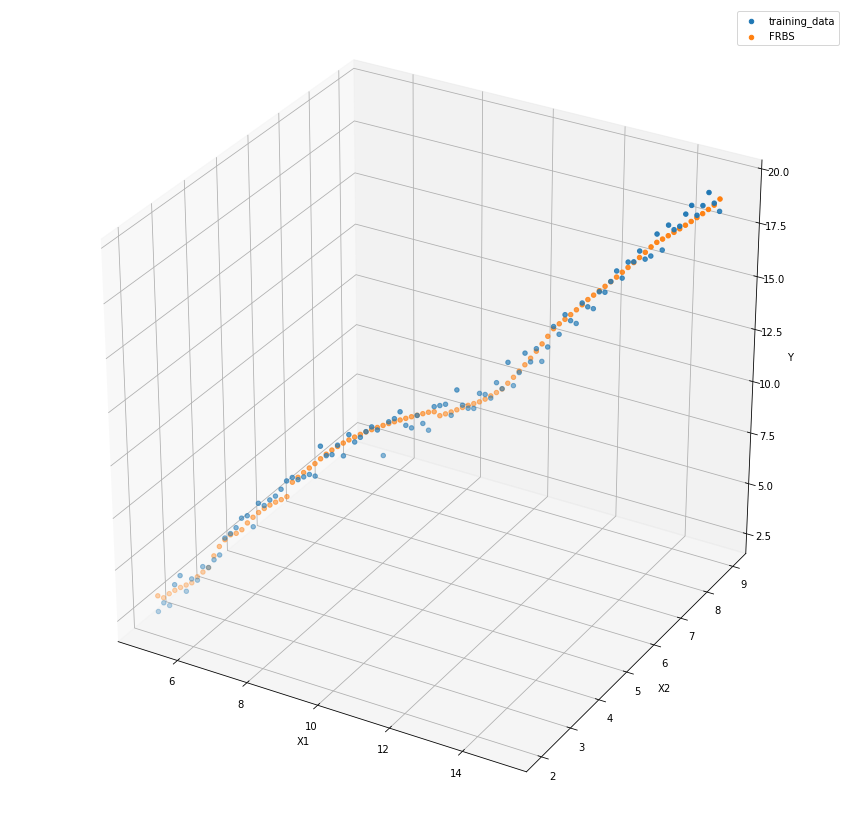

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs, label='training_data')
ax.scatter(X1s, X2s, Ys, label='FRBS')
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.legend()

### TEST: (meshgrid) BMA

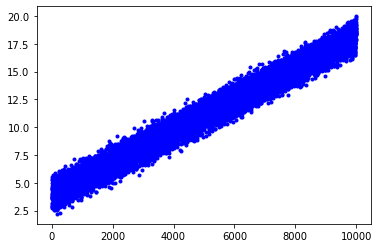

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

x1s = np.linspace(5, 15, 100)
x2s = np.linspace(2, 9, 100)

X1s, X2s = np.meshgrid(x1s,x2s)
X1s = np.ravel(X1s)
X2s = np.ravel(X2s)


def f(x1, x2):
  return np.sin(x1) + 2*x2


desired_outputs = f(X1s, X2s) + rnd.normal(0,0.4, 10000)
# desired_outputs = np.insert(desired_outputs, [25,26,27,79,80,82], [4,4.1,4.2,22,22.3, 22.34]) 
# X1s = np.insert(X1s, [25,26,27,79,80,82], [10, 10.1, 10.2, 5,5.5, 5.59]) 
# X2s = np.insert(X2s, [25,26,27,79,80,82], [2,2.1,2.2, 6,6.01,6.1]) 

plt.plot(desired_outputs, '.b')

observations = list(zip(X1s, X2s))

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

x1s = np.linspace(5, 15, 15)
x2s = np.linspace(2, 9, 15)

X1s, X2s = np.meshgrid(x1s,x2s)
X1s = np.ravel(X1s)
X2s = np.ravel(X2s)


def f(x1, x2):
  return np.sin(x1) + 2*x2


desired_outputs = f(X1s, X2s) + rnd.normal(0,0.4, 255)
# desired_outputs = np.insert(desired_outputs, [25,26,27,79,80,82], [4,4.1,4.2,22,22.3, 22.34]) 
# X1s = np.insert(X1s, [25,26,27,79,80,82], [10, 10.1, 10.2, 5,5.5, 5.59]) 
# X2s = np.insert(X2s, [25,26,27,79,80,82], [2,2.1,2.2, 6,6.01,6.1]) 

plt.plot(desired_outputs, '.b')

observations = list(zip(X1s, X2s))

Text(0.5, 0, 'Y')

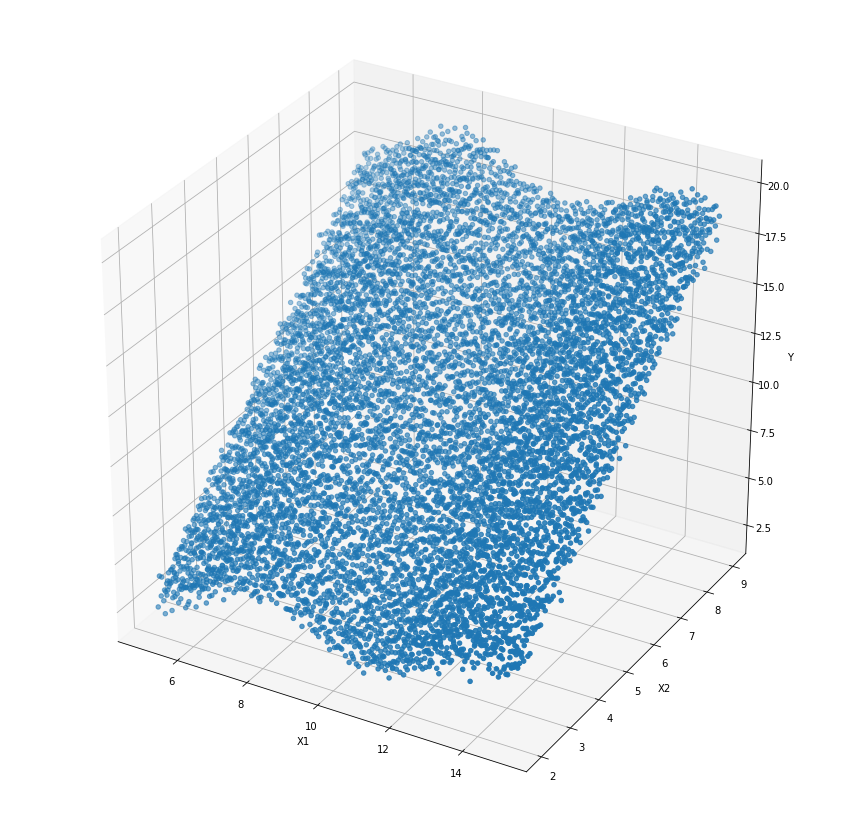

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

# Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs)
# ax.scatter(X1s, X2s, Ys)
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

inp2 = Input()
inp2.n_gen = 10
inp2.n_ind = 5
inp2.n_clone = 5
inp2.n_inf = 5
inp2.boundaries = np.array(boundaries)
inp2.observations = np.array(observations)
inp2.observation_dim = inp2.observations.shape[1]
inp2.desired_outputs = np.array(desired_outputs)
inp2.nr_rules = 5
# inp2.nr_rules= 2
inp2.lm_prob = 0.1
inp2.lm_iter = 7
inp2.gamma_init = 0.5

In [ ]:
best_indiv = bacterialMemeticEvoulution(inp2)

 10%|█         | 1/10 [00:14<02:12, 14.76s/it]

best-err:  307.4948372086256


 20%|██        | 2/10 [10:17<48:04, 360.51s/it]

best-err:  240.88416366506178


 30%|███       | 3/10 [10:31<23:35, 202.24s/it]

best-err:  240.88416366506178


 40%|████      | 4/10 [10:48<12:54, 129.05s/it]

best-err:  240.88416366506178


 50%|█████     | 5/10 [20:53<25:04, 300.86s/it]

best-err:  193.41631575695158


 60%|██████    | 6/10 [31:18<27:24, 411.14s/it]

best-err:  181.64566772494254


 70%|███████   | 7/10 [31:35<14:06, 282.19s/it]

best-err:  181.64566772494254


 80%|████████  | 8/10 [31:52<06:35, 197.79s/it]

best-err:  181.64566772494254


 90%|█████████ | 9/10 [41:58<05:25, 325.48s/it]

best-err:  181.64566772494254


100%|██████████| 10/10 [42:11<00:00, 253.14s/it]

best-err:  181.64566772494254


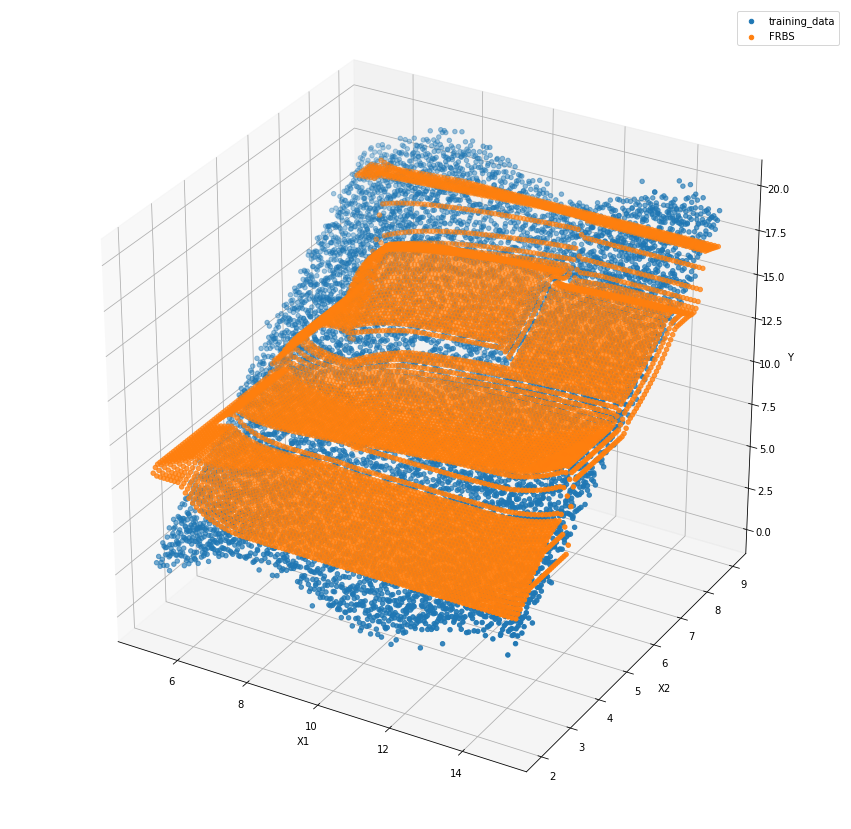

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs, label='training_data')
ax.scatter(X1s, X2s, Ys, label='FRBS')
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.legend()

In [ ]:
import plotly.graph_objects as go
import numpy as np
import plotly.express as px
import pandas as pd

df = pd.DataFrame(dict(x1=X1s, x2=X2s, y=desired_outputs))
df2 = pd.DataFrame(dict(x1=X1s, x2=X2s, y=Ys))

# in_outlier = np.array(list(map(lambda el: 'outlier' if el=='red' else 'inlier', colors)))

fig = px.scatter_3d(df, x='x1', y='x2', z='y')
fig.add_scatter3d(x=df2['x1'], y=df2['x2'], z=df2['y'], name='FAPP')

df3 = pd.DataFrame(dict(x1=X1s, x2=X2s, y=f(X1s,X2s)))
fig.add_scatter3d(x=df3['x1'], y=df3['x2'], z=df3['y'], name='ground_truth')
fig.update_traces(marker_size = 2)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),scene=dict(aspectmode='cube')) #data
fig.show()

# Tasks:

 l-m, bma-parall,  sub-sampl, rule-reduce, autoenc, defuzz-other